# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [273]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


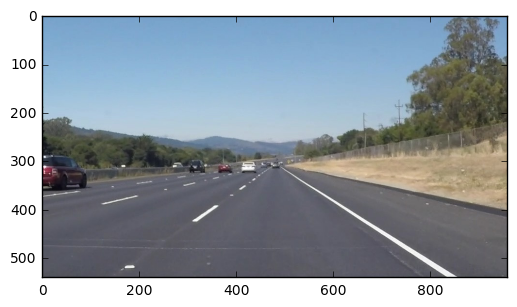

In [274]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [275]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def merge_and_draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    # We segregate the lanes based on slope
    # Negative slope - Left lane /
    # Positive slope - Right Lane \
    # This actually has the opposite sign as a line with
    # similar orientation if the axis is a normal one
    upper_y = 100000
    left_lines, left_slopes, right_lines, right_slopes = [], [], [], []
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = find_slope(x1, y1, x2, y2)
            if slope == -2 or abs(slope) < 0.2: continue
            upper_y = min(upper_y, y1, y2)
            if slope < 0: 
                left_lines.append(line)
                left_slopes.append(slope)
            else: 
                right_lines.append(line)
                right_slopes.append(slope)
                
    lleft_x, lleft_y, lright_x, lright_y, lslope = merge_lines2(left_lines, left_slopes)
    rleft_x, rleft_y, rright_x, rright_y, rslope = merge_lines2(right_lines, right_slopes)
    
    # Now, for actually drawing the lines, we're going to use
    # the bottom of the screen as the beginning of our camera
    # perspective and the smallest y as the top of our line.
    # The hope here is that we'll be able to detect the top of
    # at least one of the lanes properly
    lower_y = img.shape[0] - 1
#     upper_y = min(lleft_y, lright_y, rleft_y, rright_y)
    
    print('Lower: ', lower_y, ', Upper: ', upper_y)
    
    # Given the y values, now we find the corresponding x values
    lleft_x, lright_x = find_x(lslope, lright_x, lright_y, [lower_y, upper_y])
    rleft_x, rright_x = find_x(rslope, rright_x, rright_y, [upper_y, lower_y])
    print('New rright_x: ', rright_x)

    final_lines = [[[lleft_x, lower_y, lright_x, upper_y]], [[rleft_x, upper_y, rright_x, lower_y]]]
    
    print('Final lines: ', final_lines, ', lslope: ', lslope, ', rslope: ', rslope)
    
    draw_lines(img, final_lines, color, thickness)

    
def find_x(slope, x1, y1, y2_values):
    return [int((y2-y1)/slope+x1) for y2 in y2_values]

def find_slope(x1, y1, x2, y2):
    if x1 == x2 or y1 == y2: return -2
    return round((y2 - y1) / (x2 - x1), 2)

def line_length(line):
    return math.hypot(line[0][0]-line[0][2], line[0][1]-line[0][3])
            
def merge_lines(lines, slopes):
            
    hist, bin_edges = np.histogram(slopes)
    
    max_freq = 0
    max_freq_index = -1
    for i, f in enumerate(hist):
        if f > max_freq:
            max_freq = f
            max_freq_index = i
           
    print('Maximum Frequency Index: ', max_freq_index)    
    slope_sum, slope_count, left_x, left_y, right_x, right_y = 0, 0, 9999, lines[0][0][1], 0, lines[0][0][1]
    longest_line_length, longest_line = 0, []
    for index, line in enumerate(lines):
        length = line_length(line)
        if length > longest_line_length:
            longest_line_length = length;
            longest_line = line
            
        for x1,y1,x2,y2 in line:
            if slopes[index] >= bin_edges[max_freq_index] and slopes[index] <= bin_edges[max_freq_index+1]:
                slope_sum = slope_sum + slopes[index]
                slope_count = slope_count + 1
                left_x = min(left_x, x1, x2)
                right_x = max(right_x, x1, x2)
                if slopes[index] < 0:
                    left_y = max(left_y, y1, y2)
                    right_y = min(right_y, y1, y2)
                else:
                    left_y = min(left_y, y1, y2)
                    right_y = max(right_y, y1, y2)
                    
    average_slope = slope_sum / slope_count
                    
    print("Hist: ", hist)
    print("Edges: ", bin_edges)
    print('Min: ', left_x, ',', left_y, ',', right_x, ',', right_y)
    
    slope = find_slope(left_x, left_y, right_x, right_y)
    return left_x, left_y, right_x, right_y, slope

def merge_lines2(lines, slopes):
            
    hist, bin_edges = np.histogram(slopes)
    
    max_freq = 0
    max_freq_index = -1
    for i, f in enumerate(hist):
        if f > max_freq:
            max_freq = f
            max_freq_index = i
           
    print('Maximum Frequency Index: ', max_freq_index)    
    slope_sum, slope_count, left_x, left_y, right_x, right_y = 0.0, 0, 9999, lines[0][0][1], 0, lines[0][0][1]
    longest_line_length, longest_line = 0, []
    sum_x, sum_y, line_count = 0, 0, 0
    weighted_sum_x, weighted_sum_y, weighted_slope = 0,0, 0.0
    line_length_sum = 0
    for index, line in enumerate(lines):
        length = line_length(line)
        line_length_sum = line_length_sum + length

        for x1,y1,x2,y2 in line:
            line_count = line_count + 1
            sum_x = sum_x + x1 + x2
            sum_y = sum_y + y1 + y2
            slope_sum = slope_sum + slopes[index]
            
            weighted_sum_x = weighted_sum_x + (x1 * length) + (x2 * length)
            weighted_sum_y = weighted_sum_y + (y1 * length) + (y2 * length)
            weighted_slope = weighted_slope + (slopes[index] * length)

            if slopes[index] >= bin_edges[max_freq_index] and slopes[index] <= bin_edges[max_freq_index+1]:
                slope_count = slope_count + 1
                left_x = min(left_x, x1, x2)
                right_x = max(right_x, x1, x2)
                if slopes[index] < 0:
                    left_y = max(left_y, y1, y2)
                    right_y = min(right_y, y1, y2)
                else:
                    left_y = min(left_y, y1, y2)
                    right_y = max(right_y, y1, y2)
                    
    average_slope = slope_sum / line_count
    average_x = int(sum_x / (line_count * 2))
    average_y = int(sum_y / (line_count * 2))
    
    wavg_x = int(weighted_sum_x / (line_length_sum*2))
    wavg_y = int(weighted_sum_y / (line_length_sum*2))
    wslope = weighted_slope / line_length_sum
                    
    print("Hist2: ", hist)
    print("Edges2: ", bin_edges)
    print('Average slope: ', average_slope, ', x: ', average_x, ', y: ', average_y)
    print('Weighted Average slope: ', wslope, ', x: ', wavg_x, ', y: ', wavg_y)
    
#     return average_x, average_y, average_x, average_y, average_slope
    return wavg_x, wavg_y, wavg_x, wavg_y, wslope


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [108]:
import os
os.listdir("test_images/")


['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

Mean:  17.9226716821
std:  39.7164760107
Maximum Frequency Index:  9
Hist2:  [1 0 0 1 0 0 0 0 0 2]
Edges2:  [-0.73  -0.724 -0.718 -0.712 -0.706 -0.7   -0.694 -0.688 -0.682 -0.676
 -0.67 ]
Average slope:  -0.695 , x:  340 , y:  405
Weighted Average slope:  -0.695679858365 , x:  338 , y:  406
Maximum Frequency Index:  9
Hist2:  [3 0 0 0 0 0 2 0 0 4]
Edges2:  [ 0.62   0.623  0.626  0.629  0.632  0.635  0.638  0.641  0.644  0.647
  0.65 ]
Average slope:  0.637777777778 , x:  651 , y:  418
Weighted Average slope:  0.635922130391 , x:  673 , y:  431
Lower:  539 , Upper:  320
New rright_x:  842
Final lines:  [[[146, 539, 461, 320]], [[498, 320, 842, 539]]] , lslope:  -0.695679858365 , rslope:  0.635922130391
Mean:  17.7440837191
std:  39.3870608452
Maximum Frequency Index:  0
Hist2:  [2 0 0 0 0 2 0 0 0 1]
Edges2:  [-0.82  -0.809 -0.798 -0.787 -0.776 -0.765 -0.754 -0.743 -0.732 -0.721
 -0.71 ]
Average slope:  -0.772 , x:  315 , y:  436
Weighted Average slope:  -0.783013875935 , x:  318 , y:  4

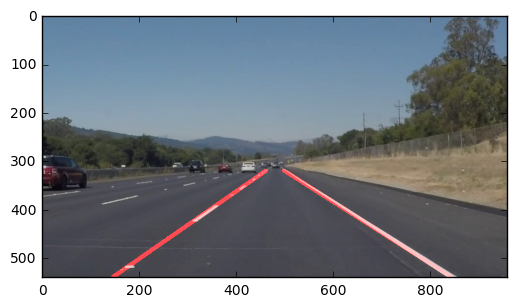

In [287]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

from math import hypot


def process_image(image):
    gray_img = grayscale(image)

    # This effectively acts as our field of vision/interest
    height, width = image.shape[0], image.shape[1]
    roi_vertices = np.array([[(0+100, height), (width/2-20, height/2+50),
                          (width/2+20, height/2+50), (width-50, height)]], 
                        dtype=np.int32)
    
    roi_gray_img = region_of_interest(gray_img, roi_vertices)
    roi_gray_img_mean = np.mean(roi_gray_img)
    roi_gray_img_std = np.std(roi_gray_img)
    print("Mean: ", roi_gray_img_mean)
    print("std: ", roi_gray_img_std)

    blur_window = 3
    blur_img = gaussian_blur(gray_img, 3)
#     canny_img = canny(gray_img, 10, 100)
    canny_img = canny(gray_img, roi_gray_img_mean, roi_gray_img_std*blur_window)
    roi_canny_img = region_of_interest(canny_img, roi_vertices)
    lines = hough_lines(roi_canny_img, 1, np.pi/180, 10, 1, 1)
    
    lines_img = np.zeros_like(image)
#     draw_lines(lines_img, [l for l in lines if line_length(l) > 20], thickness = 8)
    merge_and_draw_lines(lines_img, [l for l in lines if line_length(l) > 20], thickness=8)
    return weighted_img(lines_img, image)


def singleImage():
    input_image = mpimg.imread("test_images/solidWhiteRight.jpg")
    output = process_image(input_image)
    plt.imshow(output)
    
def processTestImages():
    for imgPath in os.listdir("test_images/"):
        # Got some .DS_Store files in this folder
        if(not imgPath.endswith("jpg")): continue
        output = process_image(mpimg.imread("test_images/" + imgPath))
        mpimg.imsave("test_output/" + imgPath, output, format='jpg', cmap='gray')

singleImage()

processTestImages()


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [277]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
# def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

#     return result

Let's try the one with the solid white lane on the right first ...

In [278]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Mean:  18.1146296296
Maximum Frequency Index:  0
Hist2:  [2 2 0 0 0 0 1 0 0 1]
Edges2:  [-0.76  -0.754 -0.748 -0.742 -0.736 -0.73  -0.724 -0.718 -0.712 -0.706 -0.7  ]
Average slope:  -0.74 , x:  238 , y:  480
Weighted Average slope:  -0.744031949419 , x:  246 , y:  474
Maximum Frequency Index:  7
Hist2:  [1 0 2 0 0 3 0 4 0 1]
Edges2:  [ 0.59   0.594  0.598  0.602  0.606  0.61   0.614  0.618  0.622  0.626
  0.63 ]
Average slope:  0.611818181818 , x:  669 , y:  423
Weighted Average slope:  0.610735243961 , x:  692 , y:  436
Lower:  539 , Upper:  324
New rright_x:  860
Final lines:  [[[158, 539, 447, 324]], [[508, 324, 860, 539]]] , lslope:  -0.744031949419 , rslope:  0.610735243961
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4



  2%|▏         | 4/222 [00:00<00:06, 34.74it/s]

Mean:  18.1146296296
Maximum Frequency Index:  0
Hist2:  [2 2 0 0 0 0 1 0 0 1]
Edges2:  [-0.76  -0.754 -0.748 -0.742 -0.736 -0.73  -0.724 -0.718 -0.712 -0.706 -0.7  ]
Average slope:  -0.74 , x:  238 , y:  480
Weighted Average slope:  -0.744031949419 , x:  246 , y:  474
Maximum Frequency Index:  7
Hist2:  [1 0 2 0 0 3 0 4 0 1]
Edges2:  [ 0.59   0.594  0.598  0.602  0.606  0.61   0.614  0.618  0.622  0.626
  0.63 ]
Average slope:  0.611818181818 , x:  669 , y:  423
Weighted Average slope:  0.610735243961 , x:  692 , y:  436
Lower:  539 , Upper:  324
New rright_x:  860
Final lines:  [[[158, 539, 447, 324]], [[508, 324, 860, 539]]] , lslope:  -0.744031949419 , rslope:  0.610735243961
Mean:  18.2045216049
Maximum Frequency Index:  0
Hist2:  [1 1 1 0 0 1 0 1 1 1]
Edges2:  [-0.79  -0.781 -0.772 -0.763 -0.754 -0.745 -0.736 -0.727 -0.718 -0.709 -0.7  ]
Average slope:  -0.744285714286 , x:  234 , y:  483
Weighted Average slope:  -0.738743166381 , x:  226 , y:  487
Maximum Frequency Index:  3
His


  5%|▌         | 12/222 [00:00<00:06, 34.91it/s]

Mean:  17.6651986883
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [-0.75  -0.748 -0.746 -0.744 -0.742 -0.74  -0.738 -0.736 -0.734 -0.732
 -0.73 ]
Average slope:  -0.74 , x:  330 , y:  411
Weighted Average slope:  -0.74261431951 , x:  332 , y:  410
Maximum Frequency Index:  0
Hist2:  [3 2 0 1 0 1 0 0 2 1]
Edges2:  [ 0.59   0.596  0.602  0.608  0.614  0.62   0.626  0.632  0.638  0.644
  0.65 ]
Average slope:  0.613 , x:  694 , y:  438
Weighted Average slope:  0.611401495988 , x:  697 , y:  439
Lower:  539 , Upper:  330
New rright_x:  860
Final lines:  [[[158, 539, 439, 330]], [[518, 330, 860, 539]]] , lslope:  -0.74261431951 , rslope:  0.611401495988
Mean:  17.6805324074
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [-0.75  -0.745 -0.74  -0.735 -0.73  -0.725 -0.72  -0.715 -0.71  -0.705 -0.7  ]
Average slope:  -0.725 , x:  323 , y:  417
Weighted Average slope:  -0.727675848594 , x:  323 , y:  418
Maximum Frequency Index:  2
Hist2:  [2 1 3 0 0 1 3


 10%|▉         | 22/222 [00:00<00:04, 40.25it/s]

Maximum Frequency Index:  5
Hist2:  [0 0 0 0 0 1 0 0 0 0]
Edges2:  [-1.25 -1.15 -1.05 -0.95 -0.85 -0.75 -0.65 -0.55 -0.45 -0.35 -0.25]
Average slope:  -0.75 , x:  378 , y:  376
Weighted Average slope:  -0.75 , x:  378 , y:  376
Maximum Frequency Index:  0
Hist2:  [5 0 0 0 1 0 0 3 0 2]
Edges2:  [ 0.62   0.627  0.634  0.641  0.648  0.655  0.662  0.669  0.676  0.683
  0.69 ]
Average slope:  0.649090909091 , x:  676 , y:  429
Weighted Average slope:  0.641310346957 , x:  705 , y:  445
Lower:  539 , Upper:  341
New rright_x:  851
Final lines:  [[[160, 539, 424, 341]], [[542, 341, 851, 539]]] , lslope:  -0.75 , rslope:  0.641310346957
Mean:  17.5734567901
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 0 0 1 0 0 2]
Edges2:  [-0.72  -0.715 -0.71  -0.705 -0.7   -0.695 -0.69  -0.685 -0.68  -0.675
 -0.67 ]
Average slope:  -0.6875 , x:  367 , y:  382
Weighted Average slope:  -0.686685468995 , x:  367 , y:  381
Maximum Frequency Index:  0
Hist2:  [4 0 0 0 4 1 0 0 0 1]
Edges2:  [ 0.61   0.625  0.64   


 15%|█▍        | 33/222 [00:00<00:04, 42.78it/s]

Mean:  17.8826813272
Maximum Frequency Index:  3
Hist2:  [2 0 1 3 0 0 0 0 0 1]
Edges2:  [-0.76  -0.747 -0.734 -0.721 -0.708 -0.695 -0.682 -0.669 -0.656 -0.643
 -0.63 ]
Average slope:  -0.717142857143 , x:  262 , y:  462
Weighted Average slope:  -0.718990845653 , x:  238 , y:  481
Maximum Frequency Index:  7
Hist2:  [1 0 2 0 0 1 0 3 0 3]
Edges2:  [ 0.61   0.614  0.618  0.622  0.626  0.63   0.634  0.638  0.642  0.646
  0.65 ]
Average slope:  0.635 , x:  675 , y:  431
Weighted Average slope:  0.635779401425 , x:  679 , y:  433
Lower:  539 , Upper:  322
New rright_x:  845
Final lines:  [[[157, 539, 459, 322]], [[504, 322, 845, 539]]] , lslope:  -0.718990845653 , rslope:  0.635779401425
Mean:  17.7507098765
Maximum Frequency Index:  0
Hist2:  [1 0 0 1 0 0 0 0 1 1]
Edges2:  [-0.75  -0.744 -0.738 -0.732 -0.726 -0.72  -0.714 -0.708 -0.702 -0.696
 -0.69 ]
Average slope:  -0.7175 , x:  283 , y:  446
Weighted Average slope:  -0.716004408288 , x:  237 , y:  479
Maximum Frequency Index:  9
Hist2:  


 17%|█▋        | 38/222 [00:00<00:04, 41.63it/s]

Mean:  17.8609741512
Maximum Frequency Index:  0
Hist2:  [1 0 1 0 0 0 0 0 0 1]
Edges2:  [-0.75  -0.745 -0.74  -0.735 -0.73  -0.725 -0.72  -0.715 -0.71  -0.705 -0.7  ]
Average slope:  -0.73 , x:  261 , y:  465
Weighted Average slope:  -0.721753635021 , x:  251 , y:  470
Maximum Frequency Index:  3
Hist2:  [1 1 0 3 0 1 1 0 1 2]
Edges2:  [ 0.6    0.606  0.612  0.618  0.624  0.63   0.636  0.642  0.648  0.654
  0.66 ]
Average slope:  0.631 , x:  643 , y:  410
Weighted Average slope:  0.634711660782 , x:  678 , y:  433
Lower:  539 , Upper:  322
New rright_x:  845
Final lines:  [[[155, 539, 456, 322]], [[503, 322, 845, 539]]] , lslope:  -0.721753635021 , rslope:  0.634711660782
Mean:  17.9700559414
Maximum Frequency Index:  8
Hist2:  [1 0 1 0 0 0 1 0 2 1]
Edges2:  [-0.74  -0.735 -0.73  -0.725 -0.72  -0.715 -0.71  -0.705 -0.7   -0.695
 -0.69 ]
Average slope:  -0.711666666667 , x:  246 , y:  472
Weighted Average slope:  -0.711700099502 , x:  226 , y:  487
Maximum Frequency Index:  0
Hist2:  [5 


 20%|█▉        | 44/222 [00:01<00:03, 45.21it/s]

Maximum Frequency Index:  9
Hist2:  [1 0 0 0 0 0 0 0 0 2]
Edges2:  [-0.83  -0.817 -0.804 -0.791 -0.778 -0.765 -0.752 -0.739 -0.726 -0.713 -0.7  ]
Average slope:  -0.746666666667 , x:  350 , y:  394
Weighted Average slope:  -0.734978700849 , x:  349 , y:  394
Maximum Frequency Index:  3
Hist2:  [1 2 1 3 0 2 2 0 1 1]
Edges2:  [ 0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68  0.69  0.7   0.71]
Average slope:  0.650769230769 , x:  674 , y:  430
Weighted Average slope:  0.645329862924 , x:  694 , y:  442
Lower:  539 , Upper:  336
New rright_x:  844
Final lines:  [[[151, 539, 427, 336]], [[529, 336, 844, 539]]] , lslope:  -0.734978700849 , rslope:  0.645329862924
Mean:  17.5493981481
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 1 0 0 0 1]
Edges2:  [-0.74  -0.736 -0.732 -0.728 -0.724 -0.72  -0.716 -0.712 -0.708 -0.704 -0.7  ]
Average slope:  -0.72 , x:  338 , y:  403
Weighted Average slope:  -0.719236188661 , x:  338 , y:  402
Maximum Frequency Index:  9
Hist2:  [1 0 1 1 0 2 0 1 0 3]
Edges2


 22%|██▏       | 49/222 [00:01<00:04, 37.39it/s]

[ 0.59   0.599  0.608  0.617  0.626  0.635  0.644  0.653  0.662  0.671
  0.68 ]
Average slope:  0.641 , x:  688 , y:  437
Weighted Average slope:  0.649046850192 , x:  691 , y:  440
Lower:  539 , Upper:  333
New rright_x:  843
Final lines:  [[[148, 539, 434, 333]], [[526, 333, 843, 539]]] , lslope:  -0.72163141879 , rslope:  0.649046850192
Mean:  17.5962885802
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 1 1]
Edges2:  [-0.78  -0.775 -0.77  -0.765 -0.76  -0.755 -0.75  -0.745 -0.74  -0.735
 -0.73 ]
Average slope:  -0.75 , x:  309 , y:  423
Weighted Average slope:  -0.743462901642 , x:  307 , y:  425
Maximum Frequency Index:  8
Hist2:  [1 1 2 0 0 0 0 2 3 1]
Edges2:  [ 0.61   0.618  0.626  0.634  0.642  0.65   0.658  0.666  0.674  0.682
  0.69 ]
Average slope:  0.656 , x:  688 , y:  439
Weighted Average slope:  0.647809869025 , x:  690 , y:  439
Lower:  539 , Upper:  336
New rright_x:  844
Final lines:  [[[153, 539, 426, 336]], [[531, 336, 844, 539]]] , lslope:  -0.743462901642 , r

Mean:  17.885773534
Maximum Frequency Index:  6
Hist2:  [1 0 1 0 1 0 2 1 1 2]
Edges2:  [-0.81  -0.795 -0.78  -0.765 -0.75  -0.735 -0.72  -0.705 -0.69  -0.675
 -0.66 ]
Average slope:  -0.718888888889 , x:  229 , y:  480
Weighted Average slope:  -0.71814889934 , x:  225 , y:  483
Maximum Frequency Index:  9
Hist2:  [1 0 0 1 1 1 1 0 0 3]
Edges2:  [ 0.57  0.58  0.59  0.6   0.61  0.62  0.63  0.64  0.65  0.66  0.67]
Average slope:  0.63 , x:  676 , y:  430
Weighted Average slope:  0.645398229084 , x:  682 , y:  435
Lower:  539 , Upper:  331
New rright_x:  843
Final lines:  [[[147, 539, 436, 331]], [[520, 331, 843, 539]]] , lslope:  -0.71814889934 , rslope:  0.645398229084



 24%|██▍       | 53/222 [00:01<00:05, 32.91it/s]

Mean:  17.794224537
Maximum Frequency Index:  3
Hist2:  [1 0 0 2 2 0 1 0 1 1]
Edges2:  [-0.76  -0.749 -0.738 -0.727 -0.716 -0.705 -0.694 -0.683 -0.672 -0.661
 -0.65 ]
Average slope:  -0.70375 , x:  226 , y:  481
Weighted Average slope:  -0.706478285947 , x:  214 , y:  491
Maximum Frequency Index:  4
Hist2:  [1 1 1 0 2 1 0 2 2 2]
Edges2:  [ 0.6    0.607  0.614  0.621  0.628  0.635  0.642  0.649  0.656  0.663
  0.67 ]
Average slope:  0.640833333333 , x:  652 , y:  417
Weighted Average slope:  0.639144812089 , x:  684 , y:  436
Lower:  539 , Upper:  329
New rright_x:  845
Final lines:  [[[146, 539, 443, 329]], [[516, 329, 845, 539]]] , lslope:  -0.706478285947 , rslope:  0.639144812089
Mean:  17.6756847994
Maximum Frequency Index:  0
Hist2:  [2 0 0 0 0 0 1 0 1 2]
Edges2:  [-0.72  -0.715 -0.71  -0.705 -0.7   -0.695 -0.69  -0.685 -0.68  -0.675
 -0.67 ]
Average slope:  -0.691666666667 , x:  251 , y:  461
Weighted Average slope:  -0.69519779743 , x:  226 , y:  479
Maximum Frequency Index:  8



 27%|██▋       | 61/222 [00:01<00:04, 32.34it/s]

Mean:  17.2673032407
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 1 0 0 1]
Edges2:  [-0.71  -0.704 -0.698 -0.692 -0.686 -0.68  -0.674 -0.668 -0.662 -0.656
 -0.65 ]
Average slope:  -0.676666666667 , x:  336 , y:  403
Weighted Average slope:  -0.683413245587 , x:  334 , y:  404
Maximum Frequency Index:  4
Hist2:  [1 0 1 0 7 0 0 0 1 3]
Edges2:  [ 0.6    0.605  0.61   0.615  0.62   0.625  0.63   0.635  0.64   0.645
  0.65 ]
Average slope:  0.626153846154 , x:  668 , y:  427
Weighted Average slope:  0.629127016226 , x:  674 , y:  430
Lower:  539 , Upper:  324
New rright_x:  847
Final lines:  [[[136, 539, 451, 324]], [[505, 324, 847, 539]]] , lslope:  -0.683413245587 , rslope:  0.629127016226
Mean:  17.2791068673
Maximum Frequency Index:  0
Hist2:  [1 0 1 0 0 1 0 0 0 1]
Edges2:  [-0.73  -0.722 -0.714 -0.706 -0.698 -0.69  -0.682 -0.674 -0.666 -0.658
 -0.65 ]
Average slope:  -0.695 , x:  349 , y:  395
Weighted Average slope:  -0.705430731126 , x:  334 , y:  405
Maximum Frequency Index:  2



 29%|██▉       | 65/222 [00:01<00:05, 30.28it/s]

Maximum Frequency Index:  9
Hist2:  [1 0 0 1 0 0 1 0 0 2]
Edges2:  [-0.76  -0.751 -0.742 -0.733 -0.724 -0.715 -0.706 -0.697 -0.688 -0.679
 -0.67 ]
Average slope:  -0.706 , x:  204 , y:  493
Weighted Average slope:  -0.699326603117 , x:  198 , y:  500
Maximum Frequency Index:  7
Hist2:  [2 0 1 0 0 1 2 3 2 1]
Edges2:  [ 0.59   0.599  0.608  0.617  0.626  0.635  0.644  0.653  0.662  0.671
  0.68 ]
Average slope:  0.644166666667 , x:  650 , y:  417
Weighted Average slope:  0.653321632224 , x:  673 , y:  433
Lower:  539 , Upper:  328
New rright_x:  835
Final lines:  [[[142, 539, 443, 328]], [[512, 328, 835, 539]]] , lslope:  -0.699326603117 , rslope:  0.653321632224
Mean:  17.5734471451
Maximum Frequency Index:  4
Hist2:  [1 0 0 0 2 1 0 0 1 1]
Edges2:  [-0.74  -0.728 -0.716 -0.704 -0.692 -0.68  -0.668 -0.656 -0.644 -0.632
 -0.62 ]
Average slope:  -0.671666666667 , x:  242 , y:  466
Weighted Average slope:  -0.686115009222 , x:  232 , y:  475
Maximum Frequency Index:  0
Hist2:  [2 0 2 0 0 2 


 31%|███       | 69/222 [00:01<00:04, 30.96it/s]

Mean:  17.2829243827
Maximum Frequency Index:  0
Hist2:  [1 0 0 1 0 0 0 0 0 1]
Edges2:  [-0.7   -0.695 -0.69  -0.685 -0.68  -0.675 -0.67  -0.665 -0.66  -0.655
 -0.65 ]
Average slope:  -0.676666666667 , x:  330 , y:  404
Weighted Average slope:  -0.679527982822 , x:  330 , y:  404
Maximum Frequency Index:  9
Hist2:  [2 0 2 0 0 1 0 1 0 3]
Edges2:  [ 0.63   0.634  0.638  0.642  0.646  0.65   0.654  0.658  0.662  0.666
  0.67 ]
Average slope:  0.651111111111 , x:  665 , y:  427
Weighted Average slope:  0.654785938039 , x:  675 , y:  434
Lower:  539 , Upper:  320
New rright_x:  835
Final lines:  [[[131, 539, 453, 320]], [[500, 320, 835, 539]]] , lslope:  -0.679527982822 , rslope:  0.654785938039



 33%|███▎      | 73/222 [00:02<00:04, 30.61it/s]

Mean:  17.2845601852
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 1 0 0 1 1]
Edges2:  [-0.69  -0.683 -0.676 -0.669 -0.662 -0.655 -0.648 -0.641 -0.634 -0.627
 -0.62 ]
Average slope:  -0.6475 , x:  310 , y:  417
Weighted Average slope:  -0.652038237265 , x:  314 , y:  415
Maximum Frequency Index:  2
Hist2:  [2 0 5 1 2 1 3 1 0 1]
Edges2:  [ 0.61   0.625  0.64   0.655  0.67   0.685  0.7    0.715  0.73   0.745
  0.76 ]
Average slope:  0.673125 , x:  675 , y:  435
Weighted Average slope:  0.66750087452 , x:  681 , y:  438
Lower:  539 , Upper:  327
New rright_x:  832
Final lines:  [[[123, 539, 448, 327]], [[514, 327, 832, 539]]] , lslope:  -0.652038237265 , rslope:  0.66750087452
Mean:  17.3266917438
Maximum Frequency Index:  8
Hist2:  [1 0 0 0 0 0 0 0 2 1]
Edges2:  [-0.7   -0.692 -0.684 -0.676 -0.668 -0.66  -0.652 -0.644 -0.636 -0.628
 -0.62 ]
Average slope:  -0.645 , x:  290 , y:  430
Weighted Average slope:  -0.65620039163 , x:  294 , y:  428
Maximum Frequency Index:  2
Hist2:  [1 0 2 0 

Maximum Frequency Index:  2
Hist2:  [1 0 2 2 0 2 0 0 1 1]
Edges2:  [-0.7   -0.691 -0.682 -0.673 -0.664 -0.655 -0.646 -0.637 -0.628 -0.619
 -0.61 ]
Average slope:  -0.658888888889 , x:  262 , y:  451
Weighted Average slope:  -0.661302776735 , x:  233 , y:  471
Maximum Frequency Index:  2
Hist2:  [3 2 4 0 0 0 0 0 0 1]
Edges2:  [ 0.64   0.651  0.662  0.673  0.684  0.695  0.706  0.717  0.728  0.739
  0.75 ]
Average slope:  0.669 , x:  659 , y:  424
Weighted Average slope:  0.662494058608 , x:  670 , y:  432
Lower:  539 , Upper:  327
New rright_x:  831
Final lines:  [[[130, 539, 450, 327]], [[511, 327, 831, 539]]] , lslope:  -0.661302776735 , rslope:  0.662494058608
Mean:  17.4988503086



 36%|███▋      | 81/222 [00:02<00:04, 30.97it/s]

Maximum Frequency Index:  0
Hist2:  [4 0 0 1 0 0 0 0 0 1]
Edges2:  [-0.65  -0.647 -0.644 -0.641 -0.638 -0.635 -0.632 -0.629 -0.626 -0.623
 -0.62 ]
Average slope:  -0.643333333333 , x:  213 , y:  483
Weighted Average slope:  -0.643720796928 , x:  196 , y:  494
Maximum Frequency Index:  1
Hist2:  [1 3 1 3 0 0 0 0 0 1]
Edges2:  [ 0.63   0.643  0.656  0.669  0.682  0.695  0.708  0.721  0.734  0.747
  0.76 ]
Average slope:  0.67 , x:  636 , y:  411
Weighted Average slope:  0.662723532633 , x:  667 , y:  430
Lower:  539 , Upper:  322
New rright_x:  831
Final lines:  [[[126, 539, 463, 322]], [[504, 322, 831, 539]]] , lslope:  -0.643720796928 , rslope:  0.662723532633
Mean:  17.3649382716
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 1 0 0 0 1]
Edges2:  [-0.68  -0.674 -0.668 -0.662 -0.656 -0.65  -0.644 -0.638 -0.632 -0.626
 -0.62 ]
Average slope:  -0.65 , x:  218 , y:  478
Weighted Average slope:  -0.647010859185 , x:  205 , y:  486
Maximum Frequency Index:  1
Hist2:  [1 4 0 0 0 2 0 0 0 3]
Ed


 38%|███▊      | 85/222 [00:02<00:04, 29.67it/s]

[3 0 0 2 0 5 0 0 0 1]
Edges2:  [ 0.67   0.676  0.682  0.688  0.694  0.7    0.706  0.712  0.718  0.724
  0.73 ]
Average slope:  0.692727272727 , x:  681 , y:  441
Weighted Average slope:  0.689485431457 , x:  667 , y:  433
Lower:  539 , Upper:  321
New rright_x:  820
Final lines:  [[[117, 539, 455, 321]], [[504, 321, 820, 539]]] , lslope:  -0.644407283729 , rslope:  0.689485431457
Mean:  17.4642650463
Maximum Frequency Index:  9
Hist2:  [1 1 0 0 0 0 0 0 0 2]
Edges2:  [-0.71  -0.699 -0.688 -0.677 -0.666 -0.655 -0.644 -0.633 -0.622 -0.611 -0.6  ]
Average slope:  -0.6525 , x:  296 , y:  425
Weighted Average slope:  -0.649119787312 , x:  297 , y:  424
Maximum Frequency Index:  0
Hist2:  [4 1 3 0 0 3 0 3 1 1]
Edges2:  [ 0.63   0.637  0.644  0.651  0.658  0.665  0.672  0.679  0.686  0.693  0.7  ]
Average slope:  0.659375 , x:  662 , y:  430
Weighted Average slope:  0.661126484116 , x:  682 , y:  443
Lower:  539 , Upper:  320
New rright_x:  827
Final lines:  [[[119, 539, 457, 320]], [[495, 320


 42%|████▏     | 93/222 [00:02<00:04, 30.75it/s]

Mean:  17.4005594136
Maximum Frequency Index:  4
Hist2:  [1 1 0 0 2 0 0 1 1 1]
Edges2:  [-0.7  -0.69 -0.68 -0.67 -0.66 -0.65 -0.64 -0.63 -0.62 -0.61 -0.6 ]
Average slope:  -0.648571428571 , x:  274 , y:  441
Weighted Average slope:  -0.65351992289 , x:  244 , y:  462
Maximum Frequency Index:  3
Hist2:  [2 0 0 4 0 0 2 0 0 2]
Edges2:  [ 0.67   0.673  0.676  0.679  0.682  0.685  0.688  0.691  0.694  0.697  0.7  ]
Average slope:  0.684 , x:  637 , y:  413
Weighted Average slope:  0.68672152889 , x:  669 , y:  435
Lower:  539 , Upper:  320
New rright_x:  820
Final lines:  [[[126, 539, 461, 320]], [[501, 320, 820, 539]]] , lslope:  -0.65351992289 , rslope:  0.68672152889
Mean:  17.2027758488
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [-0.64  -0.632 -0.624 -0.616 -0.608 -0.6   -0.592 -0.584 -0.576 -0.568
 -0.56 ]
Average slope:  -0.6 , x:  365 , y:  381
Weighted Average slope:  -0.609425293139 , x:  364 , y:  381
Maximum Frequency Index:  3
Hist2:  [1 0 1 3 0 0 1 2 1 2


 44%|████▎     | 97/222 [00:02<00:04, 28.47it/s]

Mean:  17.3325289352
Maximum Frequency Index:  0
Hist2:  [2 0 0 0 0 0 1 0 0 1]
Edges2:  [-0.67  -0.667 -0.664 -0.661 -0.658 -0.655 -0.652 -0.649 -0.646 -0.643
 -0.64 ]
Average slope:  -0.6575 , x:  268 , y:  445
Weighted Average slope:  -0.655569512746 , x:  271 , y:  443
Maximum Frequency Index:  1
Hist2:  [2 3 1 1 2 1 1 1 0 1]
Edges2:  [ 0.67   0.681  0.692  0.703  0.714  0.725  0.736  0.747  0.758  0.769
  0.78 ]
Average slope:  0.713076923077 , x:  700 , y:  454
Weighted Average slope:  0.713567499448 , x:  674 , y:  437
Lower:  539 , Upper:  343
New rright_x:  816
Final lines:  [[[124, 539, 423, 343]], [[542, 343, 816, 539]]] , lslope:  -0.655569512746 , rslope:  0.713567499448
Mean:  17.4441878858
Maximum Frequency Index:  5
Hist2:  [1 0 1 0 0 3 0 0 0 2]
Edges2:  [-0.67  -0.666 -0.662 -0.658 -0.654 -0.65  -0.646 -0.642 -0.638 -0.634
 -0.63 ]
Average slope:  -0.648571428571 , x:  275 , y:  442
Weighted Average slope:  -0.650943034388 , x:  259 , y:  451
Maximum Frequency Index:  6


 45%|████▌     | 101/222 [00:02<00:03, 30.42it/s]

Mean:  17.2978607253
Maximum Frequency Index:  0
Hist2:  [2 0 0 1 0 1 0 0 0 1]
Edges2:  [-0.67  -0.664 -0.658 -0.652 -0.646 -0.64  -0.634 -0.628 -0.622 -0.616
 -0.61 ]
Average slope:  -0.648 , x:  236 , y:  465
Weighted Average slope:  -0.649672570954 , x:  219 , y:  476
Maximum Frequency Index:  1
Hist2:  [1 2 0 0 0 0 1 0 2 1]
Edges2:  [ 0.67   0.676  0.682  0.688  0.694  0.7    0.706  0.712  0.718  0.724
  0.73 ]
Average slope:  0.701428571429 , x:  682 , y:  441
Weighted Average slope:  0.703641316025 , x:  678 , y:  438
Lower:  539 , Upper:  337
New rright_x:  821
Final lines:  [[[122, 539, 432, 337]], [[534, 337, 821, 539]]] , lslope:  -0.649672570954 , rslope:  0.703641316025



 47%|████▋     | 105/222 [00:03<00:04, 28.03it/s]

Mean:  17.0734934414
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [-0.67  -0.663 -0.656 -0.649 -0.642 -0.635 -0.628 -0.621 -0.614 -0.607 -0.6  ]
Average slope:  -0.635 , x:  367 , y:  382
Weighted Average slope:  -0.633683912499 , x:  367 , y:  381
Maximum Frequency Index:  0
Hist2:  [3 0 0 0 2 0 0 2 0 1]
Edges2:  [ 0.67   0.681  0.692  0.703  0.714  0.725  0.736  0.747  0.758  0.769
  0.78 ]
Average slope:  0.7175 , x:  655 , y:  423
Weighted Average slope:  0.699030400485 , x:  687 , y:  444
Lower:  539 , Upper:  346
New rright_x:  822
Final lines:  [[[117, 539, 422, 346]], [[546, 346, 822, 539]]] , lslope:  -0.633683912499 , rslope:  0.699030400485
Mean:  17.1522646605
Maximum Frequency Index:  5
Hist2:  [0 0 0 0 0 2 0 0 0 0]
Edges2:  [-1.16 -1.06 -0.96 -0.86 -0.76 -0.66 -0.56 -0.46 -0.36 -0.26 -0.16]
Average slope:  -0.66 , x:  358 , y:  389
Weighted Average slope:  -0.66 , x:  357 , y:  389
Maximum Frequency Index:  2
Hist2:  [1 0 3 0 2 0 2 1 2 3]
Edges2:  [ 

[2 0 0 0 0 0 0 0 0 1]
Edges2:  [-0.69  -0.688 -0.686 -0.684 -0.682 -0.68  -0.678 -0.676 -0.674 -0.672
 -0.67 ]
Average slope:  -0.683333333333 , x:  327 , y:  411
Weighted Average slope:  -0.681875746883 , x:  325 , y:  412
Maximum Frequency Index:  0
Hist2:  [4 0 1 0 0 1 0 4 0 1]
Edges2:  [ 0.67   0.674  0.678  0.682  0.686  0.69   0.694  0.698  0.702  0.706
  0.71 ]
Average slope:  0.687272727273 , x:  686 , y:  441
Weighted Average slope:  0.687901697876 , x:  684 , y:  441
Lower:  539 , Upper:  333
New rright_x:  826
Final lines:  [[[138, 539, 440, 333]], [[527, 333, 826, 539]]] , lslope:  -0.681875746883 , rslope:  0.687901697876
Mean:  17.3114949846



 49%|████▊     | 108/222 [00:03<00:04, 28.30it/s]

Maximum Frequency Index:  0
Hist2:  [1 0 0 1 1 0 0 0 0 1]
Edges2:  [-0.75 -0.74 -0.73 -0.72 -0.71 -0.7  -0.69 -0.68 -0.67 -0.66 -0.65]
Average slope:  -0.7075 , x:  310 , y:  424
Weighted Average slope:  -0.692600918702 , x:  308 , y:  424
Maximum Frequency Index:  3
Hist2:  [1 1 0 5 1 0 0 1 1 1]
Edges2:  [ 0.62   0.629  0.638  0.647  0.656  0.665  0.674  0.683  0.692  0.701
  0.71 ]
Average slope:  0.66 , x:  675 , y:  431
Weighted Average slope:  0.675164862425 , x:  691 , y:  445
Lower:  539 , Upper:  337
New rright_x:  830
Final lines:  [[[141, 539, 433, 337]], [[531, 337, 830, 539]]] , lslope:  -0.692600918702 , rslope:  0.675164862425
Mean:  17.4025482253
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 0 1 0 0 0 2]
Edges2:  [-0.74  -0.733 -0.726 -0.719 -0.712 -0.705 -0.698 -0.691 -0.684 -0.677
 -0.67 ]
Average slope:  -0.695 , x:  284 , y:  439
Weighted Average slope:  -0.685692400472 , x:  280 , y:  441
Maximum Frequency Index:  5
Hist2:  [1 0 0 0 0 3 0 1 1 2]
Edges2:  [ 0.63   0.6


 50%|█████     | 112/222 [00:03<00:03, 29.63it/s]

Mean:  17.6985570988



 52%|█████▏    | 116/222 [00:03<00:03, 28.53it/s]

Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 1 0 0 1]
Edges2:  [-0.71  -0.702 -0.694 -0.686 -0.678 -0.67  -0.662 -0.654 -0.646 -0.638
 -0.63 ]
Average slope:  -0.666666666667 , x:  235 , y:  473
Weighted Average slope:  -0.663965098084 , x:  212 , y:  487
Maximum Frequency Index:  4
Hist2:  [1 0 0 0 3 0 2 0 0 1]
Edges2:  [ 0.65   0.655  0.66   0.665  0.67   0.675  0.68   0.685  0.69   0.695  0.7  ]
Average slope:  0.674285714286 , x:  653 , y:  418
Weighted Average slope:  0.679079818984 , x:  673 , y:  431
Lower:  539 , Upper:  343
New rright_x:  832
Final lines:  [[[133, 539, 428, 343]], [[543, 343, 832, 539]]] , lslope:  -0.663965098084 , rslope:  0.679079818984
Mean:  17.568902392
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [-0.68  -0.673 -0.666 -0.659 -0.652 -0.645 -0.638 -0.631 -0.624 -0.617
 -0.61 ]
Average slope:  -0.645 , x:  369 , y:  381
Weighted Average slope:  -0.642264263753 , x:  369 , y:  381
Maximum Frequency Index:  0
Hist2:  [3 3 0 2 0 2 1 


 56%|█████▌    | 124/222 [00:03<00:03, 29.90it/s]

Mean:  17.7769251543
Maximum Frequency Index:  0
Hist2:  [2 0 0 0 0 0 0 0 2 1]
Edges2:  [-0.73 -0.72 -0.71 -0.7  -0.69 -0.68 -0.67 -0.66 -0.65 -0.64 -0.63]
Average slope:  -0.678 , x:  291 , y:  433
Weighted Average slope:  -0.689949220203 , x:  293 , y:  432
Maximum Frequency Index:  7
Hist2:  [2 0 2 0 1 0 0 3 2 1]
Edges2:  [ 0.62   0.627  0.634  0.641  0.648  0.655  0.662  0.669  0.676  0.683
  0.69 ]
Average slope:  0.657272727273 , x:  676 , y:  433
Weighted Average slope:  0.654291278391 , x:  668 , y:  426
Lower:  539 , Upper:  329
New rright_x:  840
Final lines:  [[[137, 539, 442, 329]], [[519, 329, 840, 539]]] , lslope:  -0.689949220203 , rslope:  0.654291278391
Mean:  17.8713001543
Maximum Frequency Index:  8
Hist2:  [1 1 0 0 0 0 0 0 2 1]
Edges2:  [-0.71  -0.703 -0.696 -0.689 -0.682 -0.675 -0.668 -0.661 -0.654 -0.647
 -0.64 ]
Average slope:  -0.67 , x:  258 , y:  456
Weighted Average slope:  -0.67627526775 , x:  261 , y:  455
Maximum Frequency Index:  4
Hist2:  [1 0 0 1 4 3 0 


 58%|█████▊    | 128/222 [00:03<00:03, 29.16it/s]

Maximum Frequency Index:  5
Hist2:  [0 0 0 0 0 1 0 0 0 0]
Edges2:  [-1.14 -1.04 -0.94 -0.84 -0.74 -0.64 -0.54 -0.44 -0.34 -0.24 -0.14]
Average slope:  -0.64 , x:  371 , y:  381
Weighted Average slope:  -0.64 , x:  371 , y:  381
Maximum Frequency Index:  9
Hist2:  [2 0 0 0 1 0 1 0 1 4]
Edges2:  [ 0.6    0.605  0.61   0.615  0.62   0.625  0.63   0.635  0.64   0.645
  0.65 ]
Average slope:  0.632222222222 , x:  701 , y:  446
Weighted Average slope:  0.63460741212 , x:  690 , y:  438
Lower:  539 , Upper:  332
New rright_x:  849
Final lines:  [[[124, 539, 447, 332]], [[522, 332, 849, 539]]] , lslope:  -0.64 , rslope:  0.63460741212
Mean:  17.6611323302
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [-0.72  -0.708 -0.696 -0.684 -0.672 -0.66  -0.648 -0.636 -0.624 -0.612 -0.6  ]
Average slope:  -0.66 , x:  362 , y:  389
Weighted Average slope:  -0.672665109976 , x:  363 , y:  389
Maximum Frequency Index:  4
Hist2:  [1 0 0 0 4 0 2 0 0 3]
Edges2:  [ 0.6    0.605  0.61   0.615


 59%|█████▉    | 132/222 [00:04<00:02, 30.54it/s]

Mean:  17.7849768519
Maximum Frequency Index:  9
Hist2:  [1 0 1 0 0 0 1 0 0 3]
Edges2:  [-0.72  -0.715 -0.71  -0.705 -0.7   -0.695 -0.69  -0.685 -0.68  -0.675
 -0.67 ]
Average slope:  -0.688333333333 , x:  316 , y:  425
Weighted Average slope:  -0.686311772751 , x:  306 , y:  432
Maximum Frequency Index:  1
Hist2:  [1 3 3 2 1 1 2 2 3 2]
Edges2:  [ 0.57  0.58  0.59  0.6   0.61  0.62  0.63  0.64  0.65  0.66  0.67]
Average slope:  0.6165 , x:  671 , y:  424
Weighted Average slope:  0.624706663246 , x:  682 , y:  433
Lower:  539 , Upper:  320
New rright_x:  851
Final lines:  [[[150, 539, 469, 320]], [[501, 320, 851, 539]]] , lslope:  -0.686311772751 , rslope:  0.624706663246
Mean:  17.8649787809



 61%|██████▏   | 136/222 [00:04<00:02, 30.01it/s]

Maximum Frequency Index:  1
Hist2:  [1 2 0 0 0 0 1 0 0 2]
Edges2:  [-0.78  -0.769 -0.758 -0.747 -0.736 -0.725 -0.714 -0.703 -0.692 -0.681
 -0.67 ]
Average slope:  -0.725 , x:  296 , y:  439
Weighted Average slope:  -0.712495942609 , x:  277 , y:  452
Maximum Frequency Index:  0
Hist2:  [3 0 2 0 0 1 0 0 0 3]
Edges2:  [ 0.61   0.614  0.618  0.622  0.626  0.63   0.634  0.638  0.642  0.646
  0.65 ]
Average slope:  0.627777777778 , x:  690 , y:  437
Weighted Average slope:  0.633517441655 , x:  686 , y:  435
Lower:  539 , Upper:  320
New rright_x:  850
Final lines:  [[[154, 539, 462, 320]], [[504, 320, 850, 539]]] , lslope:  -0.712495942609 , rslope:  0.633517441655
Mean:  17.999068287
Maximum Frequency Index:  9
Hist2:  [1 1 2 1 0 1 1 1 0 3]
Edges2:  [-0.76  -0.747 -0.734 -0.721 -0.708 -0.695 -0.682 -0.669 -0.656 -0.643
 -0.63 ]
Average slope:  -0.690909090909 , x:  234 , y:  481
Weighted Average slope:  -0.69601199831 , x:  236 , y:  480
Maximum Frequency Index:  6
Hist2:  [1 0 0 0 1 1 4 

Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [-0.71  -0.706 -0.702 -0.698 -0.694 -0.69  -0.686 -0.682 -0.678 -0.674
 -0.67 ]
Average slope:  -0.69 , x:  376 , y:  378
Weighted Average slope:  -0.69152682275 , x:  376 , y:  378
Maximum Frequency Index:  0
Hist2:  [2 1 1 1 2 0 1 2 2 2]
Edges2:  [ 0.56   0.571  0.582  0.593  0.604  0.615  0.626  0.637  0.648  0.659
  0.67 ]
Average slope:  0.618571428571 , x:  709 , y:  446
Weighted Average slope:  0.621311483876 , x:  722 , y:  455
Lower:  539 , Upper:  344
New rright_x:  857
Final lines:  [[[143, 539, 425, 344]], [[543, 344, 857, 539]]] , lslope:  -0.69152682275 , rslope:  0.621311483876



 63%|██████▎   | 140/222 [00:04<00:02, 28.97it/s]

Mean:  17.4852411265
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [-0.71  -0.709 -0.708 -0.707 -0.706 -0.705 -0.704 -0.703 -0.702 -0.701 -0.7  ]
Average slope:  -0.705 , x:  365 , y:  388
Weighted Average slope:  -0.703866068916 , x:  366 , y:  388
Maximum Frequency Index:  4
Hist2:  [1 0 2 0 3 0 1 0 2 1]
Edges2:  [ 0.61   0.615  0.62   0.625  0.63   0.635  0.64   0.645  0.65   0.655
  0.66 ]
Average slope:  0.634 , x:  692 , y:  436
Weighted Average slope:  0.635919471301 , x:  699 , y:  442
Lower:  539 , Upper:  339
New rright_x:  851
Final lines:  [[[151, 539, 435, 339]], [[537, 339, 851, 539]]] , lslope:  -0.703866068916 , rslope:  0.635919471301
Mean:  17.5187364969
Maximum Frequency Index:  0
Hist2:  [1 1 0 0 0 0 0 0 0 1]
Edges2:  [-0.71  -0.704 -0.698 -0.692 -0.686 -0.68  -0.674 -0.668 -0.662 -0.656
 -0.65 ]
Average slope:  -0.686666666667 , x:  357 , y:  394
Weighted Average slope:  -0.688954576953 , x:  358 , y:  394
Maximum Frequency Index:  0
Hist2:  [6


 67%|██████▋   | 148/222 [00:04<00:02, 31.25it/s]

Mean:  17.8298109568
Maximum Frequency Index:  6
Hist2:  [1 1 0 0 0 0 2 0 0 1]
Edges2:  [-0.76  -0.752 -0.744 -0.736 -0.728 -0.72  -0.712 -0.704 -0.696 -0.688
 -0.68 ]
Average slope:  -0.722 , x:  279 , y:  454
Weighted Average slope:  -0.720982117834 , x:  275 , y:  457
Maximum Frequency Index:  9
Hist2:  [1 0 1 0 0 2 0 2 0 4]
Edges2:  [ 0.61   0.614  0.618  0.622  0.626  0.63   0.634  0.638  0.642  0.646
  0.65 ]
Average slope:  0.637 , x:  638 , y:  404
Weighted Average slope:  0.636666841689 , x:  682 , y:  432
Lower:  539 , Upper:  325
New rright_x:  850
Final lines:  [[[161, 539, 458, 325]], [[513, 325, 850, 539]]] , lslope:  -0.720982117834 , rslope:  0.636666841689
Mean:  17.955470679
Maximum Frequency Index:  6
Hist2:  [1 0 0 0 0 0 2 0 0 1]
Edges2:  [-0.75  -0.742 -0.734 -0.726 -0.718 -0.71  -0.702 -0.694 -0.686 -0.678
 -0.67 ]
Average slope:  -0.705 , x:  242 , y:  477
Weighted Average slope:  -0.717938999775 , x:  237 , y:  482
Maximum Frequency Index:  4
Hist2:  [1 0 0 1 3 


 70%|███████   | 156/222 [00:04<00:02, 32.71it/s]

Mean:  17.5042785494
Maximum Frequency Index:  0
Hist2:  [2 0 0 0 0 0 0 0 0 1]
Edges2:  [-0.77  -0.769 -0.768 -0.767 -0.766 -0.765 -0.764 -0.763 -0.762 -0.761
 -0.76 ]
Average slope:  -0.766666666667 , x:  354 , y:  401
Weighted Average slope:  -0.76545121401 , x:  354 , y:  401
Maximum Frequency Index:  8
Hist2:  [1 1 0 0 2 1 0 2 3 1]
Edges2:  [ 0.57   0.579  0.588  0.597  0.606  0.615  0.624  0.633  0.642  0.651
  0.66 ]
Average slope:  0.625454545455 , x:  706 , y:  442
Weighted Average slope:  0.637249803475 , x:  711 , y:  447
Lower:  539 , Upper:  339
New rright_x:  855
Final lines:  [[[173, 539, 434, 339]], [[541, 339, 855, 539]]] , lslope:  -0.76545121401 , rslope:  0.637249803475
Mean:  17.5252604167
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 1 1]
Edges2:  [-0.8   -0.791 -0.782 -0.773 -0.764 -0.755 -0.746 -0.737 -0.728 -0.719
 -0.71 ]
Average slope:  -0.743333333333 , x:  336 , y:  410
Weighted Average slope:  -0.743993350929 , x:  335 , y:  411
Maximum Frequency Ind


 74%|███████▍  | 164/222 [00:05<00:01, 32.68it/s]

Mean:  17.825314429
Maximum Frequency Index:  6
Hist2:  [1 1 0 1 0 0 2 0 0 1]
Edges2:  [-0.81  -0.794 -0.778 -0.762 -0.746 -0.73  -0.714 -0.698 -0.682 -0.666
 -0.65 ]
Average slope:  -0.736666666667 , x:  267 , y:  465
Weighted Average slope:  -0.743543133411 , x:  240 , y:  484
Maximum Frequency Index:  2
Hist2:  [2 0 4 0 0 1 0 0 0 1]
Edges2:  [ 0.59   0.594  0.598  0.602  0.606  0.61   0.614  0.618  0.622  0.626
  0.63 ]
Average slope:  0.6025 , x:  734 , y:  456
Weighted Average slope:  0.607273571187 , x:  725 , y:  450
Lower:  539 , Upper:  346
New rright_x:  871
Final lines:  [[[166, 539, 425, 346]], [[553, 346, 871, 539]]] , lslope:  -0.743543133411 , rslope:  0.607273571187
Mean:  17.6708603395
Maximum Frequency Index:  9
Hist2:  [1 0 1 0 1 0 0 0 0 3]
Edges2:  [-0.8  -0.79 -0.78 -0.77 -0.76 -0.75 -0.74 -0.73 -0.72 -0.71 -0.7 ]
Average slope:  -0.741666666667 , x:  299 , y:  441
Weighted Average slope:  -0.737856210375 , x:  284 , y:  451
Maximum Frequency Index:  0
Hist2:  [3 0


 77%|███████▋  | 172/222 [00:05<00:01, 32.61it/s]

Mean:  17.5552642747
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [-0.79  -0.779 -0.768 -0.757 -0.746 -0.735 -0.724 -0.713 -0.702 -0.691
 -0.68 ]
Average slope:  -0.735 , x:  341 , y:  416
Weighted Average slope:  -0.761623038366 , x:  339 , y:  419
Maximum Frequency Index:  7
Hist2:  [2 0 1 0 0 0 0 3 0 1]
Edges2:  [ 0.57   0.574  0.578  0.582  0.586  0.59   0.594  0.598  0.602  0.606
  0.61 ]
Average slope:  0.59 , x:  689 , y:  430
Weighted Average slope:  0.589230507609 , x:  704 , y:  437
Lower:  539 , Upper:  329
New rright_x:  877
Final lines:  [[[181, 539, 457, 329]], [[520, 329, 877, 539]]] , lslope:  -0.761623038366 , rslope:  0.589230507609
Mean:  17.5945987654
Maximum Frequency Index:  0
Hist2:  [1 1 0 0 0 0 0 1 1 1]
Edges2:  [-0.81 -0.8  -0.79 -0.78 -0.77 -0.76 -0.75 -0.74 -0.73 -0.72 -0.71]
Average slope:  -0.758 , x:  317 , y:  435
Weighted Average slope:  -0.761927714516 , x:  316 , y:  436
Maximum Frequency Index:  6
Hist2:  [1 0 0 0 1 0 3 0 0 2]
E


 79%|███████▉  | 176/222 [00:05<00:01, 31.51it/s]

Maximum Frequency Index:  0
Hist2:  [1 1 0 0 0 0 0 0 1 1]
Edges2:  [-0.82  -0.813 -0.806 -0.799 -0.792 -0.785 -0.778 -0.771 -0.764 -0.757
 -0.75 ]
Average slope:  -0.785 , x:  297 , y:  450
Weighted Average slope:  -0.785584679584 , x:  274 , y:  468
Maximum Frequency Index:  6
Hist2:  [1 0 2 1 1 0 3 0 0 2]
Edges2:  [ 0.55  0.56  0.57  0.58  0.59  0.6   0.61  0.62  0.63  0.64  0.65]
Average slope:  0.603 , x:  668 , y:  418
Weighted Average slope:  0.593624735929 , x:  699 , y:  435
Lower:  539 , Upper:  339
New rright_x:  874
Final lines:  [[[183, 539, 438, 339]], [[537, 339, 874, 539]]] , lslope:  -0.785584679584 , rslope:  0.593624735929
Mean:  17.378128858
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [-0.8   -0.797 -0.794 -0.791 -0.788 -0.785 -0.782 -0.779 -0.776 -0.773
 -0.77 ]
Average slope:  -0.785 , x:  386 , y:  381
Weighted Average slope:  -0.784384901645 , x:  385 , y:  381
Maximum Frequency Index:  8
Hist2:  [1 0 1 0 0 0 2 0 3 2]
Edges2:  [ 0.55   0.55


 83%|████████▎ | 184/222 [00:05<00:01, 33.35it/s]

Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 1 1 0 0 1]
Edges2:  [-0.84  -0.827 -0.814 -0.801 -0.788 -0.775 -0.762 -0.749 -0.736 -0.723
 -0.71 ]
Average slope:  -0.7675 , x:  314 , y:  436
Weighted Average slope:  -0.787969884836 , x:  317 , y:  435
Maximum Frequency Index:  0
Hist2:  [4 2 0 0 0 0 0 0 0 1]
Edges2:  [ 0.58   0.594  0.608  0.622  0.636  0.65   0.664  0.678  0.692  0.706
  0.72 ]
Average slope:  0.608571428571 , x:  684 , y:  426
Weighted Average slope:  0.596373988269 , x:  724 , y:  449
Lower:  539 , Upper:  359
New rright_x:  874
Final lines:  [[[185, 539, 413, 359]], [[573, 359, 874, 539]]] , lslope:  -0.787969884836 , rslope:  0.596373988269
Mean:  17.7405439815
Maximum Frequency Index:  9
Hist2:  [1 0 0 1 0 0 0 0 0 2]
Edges2:  [-0.88  -0.868 -0.856 -0.844 -0.832 -0.82  -0.808 -0.796 -0.784 -0.772
 -0.76 ]
Average slope:  -0.8125 , x:  295 , y:  454
Weighted Average slope:  -0.804011115815 , x:  295 , y:  453
Maximum Frequency Index:  2
Hist2:  [1 1 2 2 1 1 1 0 1 2


 86%|████████▋ | 192/222 [00:05<00:00, 34.13it/s]

Maximum Frequency Index:  9
Hist2:  [1 0 0 0 0 0 0 0 0 2]
Edges2:  [-0.91  -0.898 -0.886 -0.874 -0.862 -0.85  -0.838 -0.826 -0.814 -0.802
 -0.79 ]
Average slope:  -0.83 , x:  334 , y:  420
Weighted Average slope:  -0.830462827284 , x:  333 , y:  420
Maximum Frequency Index:  4
Hist2:  [1 0 0 0 4 0 0 0 0 3]
Edges2:  [ 0.56   0.564  0.568  0.572  0.576  0.58   0.584  0.588  0.592  0.596  0.6  ]
Average slope:  0.585 , x:  745 , y:  461
Weighted Average slope:  0.59002174278 , x:  730 , y:  451
Lower:  539 , Upper:  352
New rright_x:  879
Final lines:  [[[189, 539, 414, 352]], [[562, 352, 879, 539]]] , lslope:  -0.830462827284 , rslope:  0.59002174278
Mean:  17.3761246142
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [-0.85  -0.841 -0.832 -0.823 -0.814 -0.805 -0.796 -0.787 -0.778 -0.769
 -0.76 ]
Average slope:  -0.805 , x:  371 , y:  390
Weighted Average slope:  -0.804416278105 , x:  370 , y:  390
Maximum Frequency Index:  9
Hist2:  [1 0 2 0 0 0 0 0 0 3]
Edges2:  [ 0.


 90%|█████████ | 200/222 [00:06<00:00, 33.13it/s]

[ 0.5    0.508  0.516  0.524  0.532  0.54   0.548  0.556  0.564  0.572
  0.58 ]
Average slope:  0.56 , x:  705 , y:  437
Weighted Average slope:  0.566056330574 , x:  725 , y:  447
Lower:  539 , Upper:  322
New rright_x:  887
Final lines:  [[[185, 539, 461, 322]], [[504, 322, 887, 539]]] , lslope:  -0.786814932312 , rslope:  0.566056330574
Mean:  17.8786902006
Maximum Frequency Index:  0
Hist2:  [1 0 1 1 0 0 1 1 0 1]
Edges2:  [-0.93  -0.902 -0.874 -0.846 -0.818 -0.79  -0.762 -0.734 -0.706 -0.678
 -0.65 ]
Average slope:  -0.793333333333 , x:  279 , y:  468
Weighted Average slope:  -0.791606330578 , x:  258 , y:  482
Maximum Frequency Index:  4
Hist2:  [1 0 1 0 4 0 0 1 0 1]
Edges2:  [ 0.56   0.564  0.568  0.572  0.576  0.58   0.584  0.588  0.592  0.596  0.6  ]
Average slope:  0.58 , x:  731 , y:  452
Weighted Average slope:  0.582146653153 , x:  725 , y:  448
Lower:  539 , Upper:  320
New rright_x:  881
Final lines:  [[[185, 539, 462, 320]], [[505, 320, 881, 539]]] , lslope:  -0.79160633


 92%|█████████▏| 204/222 [00:06<00:00, 31.66it/s]

Mean:  17.6092746914
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [-0.88  -0.865 -0.85  -0.835 -0.82  -0.805 -0.79  -0.775 -0.76  -0.745
 -0.73 ]
Average slope:  -0.805 , x:  365 , y:  397
Weighted Average slope:  -0.779663533833 , x:  362 , y:  397
Maximum Frequency Index:  2
Hist2:  [1 1 3 0 1 0 0 2 2 1]
Edges2:  [ 0.54   0.547  0.554  0.561  0.568  0.575  0.582  0.589  0.596  0.603
  0.61 ]
Average slope:  0.575454545455 , x:  722 , y:  444
Weighted Average slope:  0.579890344325 , x:  723 , y:  445
Lower:  539 , Upper:  326
New rright_x:  885
Final lines:  [[[179, 539, 453, 326]], [[517, 326, 885, 539]]] , lslope:  -0.779663533833 , rslope:  0.579890344325
Mean:  17.6549884259
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [-0.82  -0.819 -0.818 -0.817 -0.816 -0.815 -0.814 -0.813 -0.812 -0.811
 -0.81 ]
Average slope:  -0.815 , x:  346 , y:  407
Weighted Average slope:  -0.814596082433 , x:  345 , y:  408
Maximum Frequency Index:  0
Hist2:  [


 95%|█████████▌| 212/222 [00:06<00:00, 32.21it/s]

Mean:  17.8005652006
Maximum Frequency Index:  0
Hist2:  [2 1 2 1 2 0 0 0 0 1]
Edges2:  [-0.9   -0.875 -0.85  -0.825 -0.8   -0.775 -0.75  -0.725 -0.7   -0.675
 -0.65 ]
Average slope:  -0.821111111111 , x:  278 , y:  465
Weighted Average slope:  -0.819819115294 , x:  268 , y:  472
Maximum Frequency Index:  2
Hist2:  [1 0 2 0 0 0 1 1 2 1]
Edges2:  [ 0.53  0.54  0.55  0.56  0.57  0.58  0.59  0.6   0.61  0.62  0.63]
Average slope:  0.58375 , x:  795 , y:  483
Weighted Average slope:  0.58125628299 , x:  782 , y:  476
Lower:  539 , Upper:  320
New rright_x:  890
Final lines:  [[[186, 539, 453, 320]], [[513, 320, 890, 539]]] , lslope:  -0.819819115294 , rslope:  0.58125628299
Mean:  17.6004089506
Maximum Frequency Index:  0
Hist2:  [1 0 0 1 0 1 1 0 0 1]
Edges2:  [-0.85  -0.837 -0.824 -0.811 -0.798 -0.785 -0.772 -0.759 -0.746 -0.733
 -0.72 ]
Average slope:  -0.784 , x:  251 , y:  485
Weighted Average slope:  -0.789667740879 , x:  237 , y:  497
Maximum Frequency Index:  8
Hist2:  [1 0 0 0 0 0 


 97%|█████████▋| 216/222 [00:06<00:00, 31.20it/s]

Maximum Frequency Index:  0
Hist2:  [1 1 0 0 0 0 0 0 0 1]
Edges2:  [-0.79  -0.783 -0.776 -0.769 -0.762 -0.755 -0.748 -0.741 -0.734 -0.727
 -0.72 ]
Average slope:  -0.763333333333 , x:  362 , y:  397
Weighted Average slope:  -0.76748952872 , x:  362 , y:  397
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 0 0 2 1 2 3]
Edges2:  [ 0.47   0.482  0.494  0.506  0.518  0.53   0.542  0.554  0.566  0.578
  0.59 ]
Average slope:  0.558888888889 , x:  720 , y:  443
Weighted Average slope:  0.5653465152 , x:  736 , y:  451
Lower:  539 , Upper:  328
New rright_x:  891
Final lines:  [[[176, 539, 451, 328]], [[518, 328, 891, 539]]] , lslope:  -0.76748952872 , rslope:  0.5653465152
Mean:  17.4590625
Maximum Frequency Index:  0
Hist2:  [1 0 0 1 0 0 1 0 0 1]
Edges2:  [-0.81 -0.8  -0.79 -0.78 -0.77 -0.76 -0.75 -0.74 -0.73 -0.72 -0.71]
Average slope:  -0.7625 , x:  379 , y:  387
Weighted Average slope:  -0.764231545528 , x:  370 , y:  394
Maximum Frequency Index:  0
Hist2:  [3 0 0 1 0 0 0 0 0 2]
Edges2:  [ 


100%|█████████▉| 221/222 [00:06<00:00, 32.60it/s]

Mean:  17.7428800154
Maximum Frequency Index:  7
Hist2:  [1 0 0 0 0 0 0 2 0 1]
Edges2:  [-0.81  -0.803 -0.796 -0.789 -0.782 -0.775 -0.768 -0.761 -0.754 -0.747
 -0.74 ]
Average slope:  -0.7675 , x:  312 , y:  437
Weighted Average slope:  -0.768988091875 , x:  271 , y:  468
Maximum Frequency Index:  5
Hist2:  [1 0 0 1 0 4 3 0 0 2]
Edges2:  [ 0.52   0.526  0.532  0.538  0.544  0.55   0.556  0.562  0.568  0.574
  0.58 ]
Average slope:  0.554545454545 , x:  687 , y:  427
Weighted Average slope:  0.559511654617 , x:  709 , y:  437
Lower:  539 , Upper:  323
New rright_x:  891
Final lines:  [[[178, 539, 459, 323]], [[505, 323, 891, 539]]] , lslope:  -0.768988091875 , rslope:  0.559511654617
[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.67 s, sys: 702 ms, total: 4.37 s
Wall time: 7.49 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [279]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [285]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Mean:  18.3120177469
std:  40.186698582
Maximum Frequency Index:  3
Hist2:  [1 1 1 3 0 2 2 2 1 3]
Edges2:  [-0.68  -0.672 -0.664 -0.656 -0.648 -0.64  -0.632 -0.624 -0.616 -0.608 -0.6  ]
Average slope:  -0.634375 , x:  271 , y:  442
Weighted Average slope:  -0.63133485715 , x:  274 , y:  439
Maximum Frequency Index:  8
Hist2:  [1 0 0 0 1 0 0 0 2 2]
Edges2:  [ 0.61   0.617  0.624  0.631  0.638  0.645  0.652  0.659  0.666  0.673
  0.68 ]
Average slope:  0.658333333333 , x:  711 , y:  457
Weighted Average slope:  0.665251010052 , x:  711 , y:  459
Lower:  539 , Upper:  327
New rright_x:  831
Final lines:  [[[115, 539, 451, 327]], [[512, 327, 831, 539]]] , lslope:  -0.63133485715 , rslope:  0.665251010052
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4





  0%|          | 0/682 [00:00<?, ?it/s]


  0%|          | 3/682 [00:00<00:27, 24.66it/s]

Mean:  18.3120177469
std:  40.186698582
Maximum Frequency Index:  3
Hist2:  [1 1 1 3 0 2 2 2 1 3]
Edges2:  [-0.68  -0.672 -0.664 -0.656 -0.648 -0.64  -0.632 -0.624 -0.616 -0.608 -0.6  ]
Average slope:  -0.634375 , x:  271 , y:  442
Weighted Average slope:  -0.63133485715 , x:  274 , y:  439
Maximum Frequency Index:  8
Hist2:  [1 0 0 0 1 0 0 0 2 2]
Edges2:  [ 0.61   0.617  0.624  0.631  0.638  0.645  0.652  0.659  0.666  0.673
  0.68 ]
Average slope:  0.658333333333 , x:  711 , y:  457
Weighted Average slope:  0.665251010052 , x:  711 , y:  459
Lower:  539 , Upper:  327
New rright_x:  831
Final lines:  [[[115, 539, 451, 327]], [[512, 327, 831, 539]]] , lslope:  -0.63133485715 , rslope:  0.665251010052
Mean:  18.5851157407
std:  40.9783263427
Maximum Frequency Index:  7
Hist2:  [1 0 0 1 2 1 3 6 3 1]
Edges2:  [-0.81  -0.784 -0.758 -0.732 -0.706 -0.68  -0.654 -0.628 -0.602 -0.576
 -0.55 ]
Average slope:  -0.64 , x:  282 , y:  435
Weighted Average slope:  -0.631583563596 , x:  269 , y:  442

Mean:  18.1815084877
std:  39.4765848892





  1%|          | 6/682 [00:00<00:27, 24.69it/s]


  1%|▏         | 9/682 [00:00<00:26, 25.65it/s]

Maximum Frequency Index:  8
Hist2:  [1 1 0 0 1 0 0 3 6 1]
Edges2:  [-0.8   -0.779 -0.758 -0.737 -0.716 -0.695 -0.674 -0.653 -0.632 -0.611
 -0.59 ]
Average slope:  -0.657692307692 , x:  293 , y:  433
Weighted Average slope:  -0.644306751094 , x:  281 , y:  440
Maximum Frequency Index:  5
Hist2:  [0 0 0 0 0 1 0 0 0 0]
Edges2:  [ 0.26  0.36  0.46  0.56  0.66  0.76  0.86  0.96  1.06  1.16  1.26]
Average slope:  0.76 , x:  598 , y:  383
Weighted Average slope:  0.76 , x:  598 , y:  383
Lower:  539 , Upper:  328
New rright_x:  803
Final lines:  [[[127, 539, 454, 328]], [[525, 328, 803, 539]]] , lslope:  -0.644306751094 , rslope:  0.76
Mean:  18.1950289352
std:  39.505950164
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 0 1 0 0 3 7]
Edges2:  [-0.89  -0.863 -0.836 -0.809 -0.782 -0.755 -0.728 -0.701 -0.674 -0.647
 -0.62 ]
Average slope:  -0.664166666667 , x:  314 , y:  420
Weighted Average slope:  -0.646967314763 , x:  287 , y:  436
Maximum Frequency Index:  0
Hist2:  [1 0 0 1 0 0 0 0 0 1]
Edges




  2%|▏         | 12/682 [00:00<00:25, 26.23it/s]


  2%|▏         | 16/682 [00:00<00:23, 28.06it/s]

Mean:  18.200470679
std:  39.751366355
Maximum Frequency Index:  7
Hist2:  [1 0 0 0 0 0 1 6 2 3]
Edges2:  [-0.94  -0.909 -0.878 -0.847 -0.816 -0.785 -0.754 -0.723 -0.692 -0.661
 -0.63 ]
Average slope:  -0.708461538462 , x:  327 , y:  411
Weighted Average slope:  -0.675427213806 , x:  287 , y:  437
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 1 0 0 1]
Edges2:  [ 0.64   0.643  0.646  0.649  0.652  0.655  0.658  0.661  0.664  0.667
  0.67 ]
Average slope:  0.656666666667 , x:  682 , y:  431
Weighted Average slope:  0.658558330699 , x:  680 , y:  430
Lower:  539 , Upper:  322
New rright_x:  845
Final lines:  [[[135, 539, 457, 322]], [[516, 322, 845, 539]]] , lslope:  -0.675427213806 , rslope:  0.658558330699
Mean:  18.2695196759
std:  40.0234931968
Maximum Frequency Index:  9
Hist2:  [1 0 0 2 0 0 0 2 1 6]
Edges2:  [-0.76  -0.749 -0.738 -0.727 -0.716 -0.705 -0.694 -0.683 -0.672 -0.661
 -0.65 ]
Average slope:  -0.680833333333 , x:  296 , y:  431
Weighted Average slope:  -0.674354895792 ,




  3%|▎         | 20/682 [00:00<00:21, 30.39it/s]


  4%|▎         | 25/682 [00:00<00:19, 33.25it/s]

Mean:  17.8720679012
std:  38.8458957671
Maximum Frequency Index:  8
Hist2:  [1 0 0 0 0 1 0 1 4 3]
Edges2:  [-0.82  -0.806 -0.792 -0.778 -0.764 -0.75  -0.736 -0.722 -0.708 -0.694
 -0.68 ]
Average slope:  -0.714 , x:  287 , y:  440
Weighted Average slope:  -0.697925724713 , x:  281 , y:  444
Maximum Frequency Index:  5
Hist2:  [0 0 0 0 0 1 0 0 0 0]
Edges2:  [ 0.17  0.27  0.37  0.47  0.57  0.67  0.77  0.87  0.97  1.07  1.17]
Average slope:  0.67 , x:  608 , y:  387
Weighted Average slope:  0.67 , x:  608 , y:  387
Lower:  539 , Upper:  331
New rright_x:  834
Final lines:  [[[144, 539, 442, 331]], [[524, 331, 834, 539]]] , lslope:  -0.697925724713 , rslope:  0.67
Mean:  17.8867939815
std:  38.9054256604
Maximum Frequency Index:  4
Hist2:  [1 1 0 0 4 1 1 2 0 2]
Edges2:  [-0.76  -0.749 -0.738 -0.727 -0.716 -0.705 -0.694 -0.683 -0.672 -0.661
 -0.65 ]
Average slope:  -0.699166666667 , x:  272 , y:  452
Weighted Average slope:  -0.692225011017 , x:  278 , y:  446
Maximum Frequency Index:  0
Hi




  4%|▍         | 29/682 [00:00<00:18, 34.99it/s]


  5%|▍         | 34/682 [00:01<00:17, 37.63it/s]

Mean:  18.3814795525
std:  40.5950922671
Maximum Frequency Index:  9
Hist2:  [3 0 0 0 1 0 0 2 0 5]
Edges2:  [-0.82  -0.806 -0.792 -0.778 -0.764 -0.75  -0.736 -0.722 -0.708 -0.694
 -0.68 ]
Average slope:  -0.730909090909 , x:  330 , y:  412
Weighted Average slope:  -0.707559296824 , x:  289 , y:  440
Maximum Frequency Index:  0
Hist2:  [3 1 1 1 1 0 2 0 1 1]
Edges2:  [ 0.56   0.571  0.582  0.593  0.604  0.615  0.626  0.637  0.648  0.659
  0.67 ]
Average slope:  0.605454545455 , x:  741 , y:  464
Weighted Average slope:  0.606582084303 , x:  758 , y:  475
Lower:  539 , Upper:  331
New rright_x:  863
Final lines:  [[[149, 539, 443, 331]], [[520, 331, 863, 539]]] , lslope:  -0.707559296824 , rslope:  0.606582084303
Mean:  18.3040991512
std:  40.3442142044
Maximum Frequency Index:  3
Hist2:  [2 0 0 4 1 0 1 1 1 2]
Edges2:  [-0.77  -0.757 -0.744 -0.731 -0.718 -0.705 -0.692 -0.679 -0.666 -0.653
 -0.64 ]
Average slope:  -0.701666666667 , x:  280 , y:  447
Weighted Average slope:  -0.699070797923




  6%|▌         | 39/682 [00:01<00:16, 39.44it/s]


  6%|▋         | 44/682 [00:01<00:15, 41.32it/s]

Maximum Frequency Index:  6
Hist2:  [1 1 2 1 0 2 3 1 1 1]
Edges2:  [-0.84  -0.823 -0.806 -0.789 -0.772 -0.755 -0.738 -0.721 -0.704 -0.687
 -0.67 ]
Average slope:  -0.754615384615 , x:  279 , y:  451
Weighted Average slope:  -0.743777325484 , x:  279 , y:  450
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [ 0.58   0.586  0.592  0.598  0.604  0.61   0.616  0.622  0.628  0.634
  0.64 ]
Average slope:  0.61 , x:  674 , y:  419
Weighted Average slope:  0.608774180569 , x:  674 , y:  419
Lower:  539 , Upper:  348
New rright_x:  871
Final lines:  [[[159, 539, 416, 348]], [[557, 348, 871, 539]]] , lslope:  -0.743777325484 , rslope:  0.608774180569
Mean:  17.8588618827
std:  39.0764092888
Maximum Frequency Index:  8
Hist2:  [2 1 1 2 0 0 0 1 3 2]
Edges2:  [-0.83  -0.815 -0.8   -0.785 -0.77  -0.755 -0.74  -0.725 -0.71  -0.695
 -0.68 ]
Average slope:  -0.751666666667 , x:  293 , y:  441
Weighted Average slope:  -0.741057439961 , x:  300 , y:  434
Maximum Frequency Index:  0
Hi




  7%|▋         | 49/682 [00:01<00:18, 34.85it/s]

Maximum Frequency Index:  9
Hist2:  [1 0 0 1 0 0 1 1 1 5]
Edges2:  [-0.89 -0.87 -0.85 -0.83 -0.81 -0.79 -0.77 -0.75 -0.73 -0.71 -0.69]
Average slope:  -0.744 , x:  296 , y:  434
Weighted Average slope:  -0.737107648904 , x:  291 , y:  438
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 1 0 0 0 1]
Edges2:  [ 0.61   0.612  0.614  0.616  0.618  0.62   0.622  0.624  0.626  0.628
  0.63 ]
Average slope:  0.62 , x:  617 , y:  387
Weighted Average slope:  0.619601793164 , x:  618 , y:  387
Lower:  539 , Upper:  347
New rright_x:  863
Final lines:  [[[153, 539, 414, 347]], [[553, 347, 863, 539]]] , lslope:  -0.737107648904 , rslope:  0.619601793164
Mean:  17.6613522377
std:  38.5030768194
Maximum Frequency Index:  1
Hist2:  [1 2 2 2 0 2 2 2 0 1]
Edges2:  [-0.78  -0.771 -0.762 -0.753 -0.744 -0.735 -0.726 -0.717 -0.708 -0.699
 -0.69 ]
Average slope:  -0.739285714286 , x:  286 , y:  442
Weighted Average slope:  -0.738287288296 , x:  286 , y:  443
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 1 




  8%|▊         | 53/682 [00:01<00:20, 30.85it/s]

Maximum Frequency Index:  5
Hist2:  [1 0 0 0 0 2 1 0 2 1]
Edges2:  [-0.85  -0.834 -0.818 -0.802 -0.786 -0.77  -0.754 -0.738 -0.722 -0.706
 -0.69 ]
Average slope:  -0.748571428571 , x:  290 , y:  440
Weighted Average slope:  -0.736671396529 , x:  270 , y:  454
Maximum Frequency Index:  0
Hist2:  [1 0 0 1 0 0 1 0 1 1]
Edges2:  [ 0.59   0.596  0.602  0.608  0.614  0.62   0.626  0.632  0.638  0.644
  0.65 ]
Average slope:  0.624 , x:  700 , y:  437
Weighted Average slope:  0.619228826131 , x:  702 , y:  439
Lower:  539 , Upper:  359
New rright_x:  863
Final lines:  [[[154, 539, 398, 359]], [[572, 359, 863, 539]]] , lslope:  -0.736671396529 , rslope:  0.619228826131
Mean:  17.8632947531
std:  39.3142238177
Maximum Frequency Index:  9
Hist2:  [1 0 0 3 1 1 2 1 1 4]
Edges2:  [-0.8   -0.787 -0.774 -0.761 -0.748 -0.735 -0.722 -0.709 -0.696 -0.683
 -0.67 ]
Average slope:  -0.719285714286 , x:  260 , y:  461
Weighted Average slope:  -0.716944659862 , x:  275 , y:  449
Maximum Frequency Index:  9
H




  8%|▊         | 57/682 [00:01<00:22, 27.46it/s]

Mean:  17.5074344136
std:  38.1219744637
Maximum Frequency Index:  2
Hist2:  [1 0 3 3 1 0 0 1 1 1]
Edges2:  [-0.78 -0.77 -0.76 -0.75 -0.74 -0.73 -0.72 -0.71 -0.7  -0.69 -0.68]
Average slope:  -0.74 , x:  278 , y:  447
Weighted Average slope:  -0.730942019211 , x:  291 , y:  438
Maximum Frequency Index:  0
Hist2:  [1 0 1 0 0 0 0 0 0 1]
Edges2:  [ 0.6    0.604  0.608  0.612  0.616  0.62   0.624  0.628  0.632  0.636
  0.64 ]
Average slope:  0.616666666667 , x:  644 , y:  408
Weighted Average slope:  0.614914823376 , x:  640 , y:  406
Lower:  539 , Upper:  335
New rright_x:  856
Final lines:  [[[152, 539, 431, 335]], [[524, 335, 856, 539]]] , lslope:  -0.730942019211 , rslope:  0.614914823376
Mean:  17.5000135031
std:  38.1089169173
Maximum Frequency Index:  2
Hist2:  [1 1 3 0 0 1 3 0 2 3]
Edges2:  [-0.81  -0.797 -0.784 -0.771 -0.758 -0.745 -0.732 -0.719 -0.706 -0.693
 -0.68 ]
Average slope:  -0.737142857143 , x:  288 , y:  441
Weighted Average slope:  -0.724006874546 , x:  275 , y:  449
M




  9%|▉         | 60/682 [00:01<00:24, 25.75it/s]


  9%|▉         | 63/682 [00:02<00:26, 23.57it/s]

[2 2 3 0 2 0 0 4 0 1]
Edges2:  [-0.75  -0.743 -0.736 -0.729 -0.722 -0.715 -0.708 -0.701 -0.694 -0.687
 -0.68 ]
Average slope:  -0.720714285714 , x:  259 , y:  459
Weighted Average slope:  -0.721990258196 , x:  281 , y:  443
Maximum Frequency Index:  9
Hist2:  [1 0 0 1 0 0 0 0 0 2]
Edges2:  [ 0.59   0.596  0.602  0.608  0.614  0.62   0.626  0.632  0.638  0.644
  0.65 ]
Average slope:  0.625 , x:  676 , y:  429
Weighted Average slope:  0.621696336333 , x:  666 , y:  421
Lower:  539 , Upper:  339
New rright_x:  855
Final lines:  [[[148, 539, 425, 339]], [[534, 339, 855, 539]]] , lslope:  -0.721990258196 , rslope:  0.621696336333
Mean:  17.5712191358
std:  38.4096073541
Maximum Frequency Index:  7
Hist2:  [1 0 0 0 0 0 1 3 2 2]
Edges2:  [-0.78  -0.772 -0.764 -0.756 -0.748 -0.74  -0.732 -0.724 -0.716 -0.708 -0.7  ]
Average slope:  -0.721111111111 , x:  292 , y:  437
Weighted Average slope:  -0.71531990243 , x:  279 , y:  445
Maximum Frequency Index:  9
Hist2:  [1 0 0 1 0 0 1 0 0 2]
Edges2:  




 10%|▉         | 66/682 [00:02<00:25, 24.43it/s]


 10%|█         | 69/682 [00:02<00:23, 25.68it/s]

Mean:  18.1030208333
std:  40.0651436665
Maximum Frequency Index:  4
Hist2:  [1 0 2 2 4 4 1 1 1 1]
Edges2:  [-0.77  -0.756 -0.742 -0.728 -0.714 -0.7   -0.686 -0.672 -0.658 -0.644
 -0.63 ]
Average slope:  -0.701764705882 , x:  284 , y:  440
Weighted Average slope:  -0.702306502364 , x:  286 , y:  438
Maximum Frequency Index:  5
Hist2:  [2 1 1 2 1 3 0 0 1 1]
Edges2:  [ 0.52   0.539  0.558  0.577  0.596  0.615  0.634  0.653  0.672  0.691
  0.71 ]
Average slope:  0.599166666667 , x:  744 , y:  469
Weighted Average slope:  0.606668774387 , x:  762 , y:  480
Lower:  539 , Upper:  338
New rright_x:  859
Final lines:  [[[142, 539, 428, 338]], [[527, 338, 859, 539]]] , lslope:  -0.702306502364 , rslope:  0.606668774387
Mean:  18.055308642
std:  39.8436616421
Maximum Frequency Index:  6
Hist2:  [2 1 2 0 0 0 3 1 2 2]
Edges2:  [-0.75  -0.739 -0.728 -0.717 -0.706 -0.695 -0.684 -0.673 -0.662 -0.651
 -0.64 ]
Average slope:  -0.690769230769 , x:  276 , y:  444
Weighted Average slope:  -0.699341150101 




 11%|█         | 72/682 [00:02<00:25, 24.30it/s]

Mean:  17.7565721451
std:  38.6742983695
Maximum Frequency Index:  0
Hist2:  [4 0 0 1 0 0 2 2 1 1]
Edges2:  [-0.73  -0.722 -0.714 -0.706 -0.698 -0.69  -0.682 -0.674 -0.666 -0.658
 -0.65 ]
Average slope:  -0.693636363636 , x:  327 , y:  410
Weighted Average slope:  -0.698940209988 , x:  294 , y:  434
Maximum Frequency Index:  9
Hist2:  [1 0 1 0 0 0 1 1 1 2]
Edges2:  [ 0.56   0.569  0.578  0.587  0.596  0.605  0.614  0.623  0.632  0.641
  0.65 ]
Average slope:  0.618571428571 , x:  689 , y:  439
Weighted Average slope:  0.618685831902 , x:  678 , y:  432
Lower:  539 , Upper:  329
New rright_x:  850
Final lines:  [[[143, 539, 444, 329]], [[511, 329, 850, 539]]] , lslope:  -0.698940209988 , rslope:  0.618685831902
Mean:  17.8804243827
std:  38.9676167823
Maximum Frequency Index:  1
Hist2:  [1 2 0 0 0 0 1 2 2 1]
Edges2:  [-0.83  -0.812 -0.794 -0.776 -0.758 -0.74  -0.722 -0.704 -0.686 -0.668
 -0.65 ]
Average slope:  -0.727777777778 , x:  282 , y:  447
Weighted Average slope:  -0.706398462522




 11%|█         | 75/682 [00:02<00:29, 20.50it/s]

[1 0 0 0 0 2 1 0 1 2]
Edges2:  [-0.8   -0.787 -0.774 -0.761 -0.748 -0.735 -0.722 -0.709 -0.696 -0.683
 -0.67 ]
Average slope:  -0.717142857143 , x:  313 , y:  422
Weighted Average slope:  -0.702390772659 , x:  290 , y:  438
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [ 0.59   0.595  0.6    0.605  0.61   0.615  0.62   0.625  0.63   0.635
  0.64 ]
Average slope:  0.615 , x:  670 , y:  425
Weighted Average slope:  0.614222391348 , x:  670 , y:  425
Lower:  539 , Upper:  329
New rright_x:  855
Final lines:  [[[146, 539, 445, 329]], [[513, 329, 855, 539]]] , lslope:  -0.702390772659 , rslope:  0.614222391348
Mean:  17.9633352623
std:  39.3079715127
Maximum Frequency Index:  0
Hist2:  [3 0 0 1 0 2 0 0 1 1]
Edges2:  [-0.76  -0.749 -0.738 -0.727 -0.716 -0.705 -0.694 -0.683 -0.672 -0.661
 -0.65 ]
Average slope:  -0.7125 , x:  276 , y:  448
Weighted Average slope:  -0.713778503125 , x:  298 , y:  432
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 0 0 0 0 0 2]
Edges2:  [ 0.6 




 11%|█▏        | 78/682 [00:02<00:32, 18.40it/s]


 12%|█▏        | 80/682 [00:02<00:36, 16.70it/s]

Maximum Frequency Index:  0
Hist2:  [2 0 1 1 1 0 1 1 2 1]
Edges2:  [-0.81  -0.795 -0.78  -0.765 -0.75  -0.735 -0.72  -0.705 -0.69  -0.675
 -0.66 ]
Average slope:  -0.734 , x:  326 , y:  414
Weighted Average slope:  -0.715836394096 , x:  297 , y:  433
Maximum Frequency Index:  0
Hist2:  [1 0 1 1 0 0 0 1 1 1]
Edges2:  [ 0.57  0.58  0.59  0.6   0.61  0.62  0.63  0.64  0.65  0.66  0.67]
Average slope:  0.62 , x:  748 , y:  475
Weighted Average slope:  0.622226186547 , x:  751 , y:  477
Lower:  539 , Upper:  325
New rright_x:  850
Final lines:  [[[148, 539, 447, 325]], [[506, 325, 850, 539]]] , lslope:  -0.715836394096 , rslope:  0.622226186547
Mean:  18.1567881944
std:  40.1236087653
Maximum Frequency Index:  5
Hist2:  [2 0 1 1 0 3 0 0 0 2]
Edges2:  [-0.78  -0.769 -0.758 -0.747 -0.736 -0.725 -0.714 -0.703 -0.692 -0.681
 -0.67 ]
Average slope:  -0.726666666667 , x:  292 , y:  438
Weighted Average slope:  -0.7143239136 , x:  295 , y:  435
Maximum Frequency Index:  0
Hist2:  [2 1 2 1 1 0 1 1 




 12%|█▏        | 82/682 [00:03<00:34, 17.16it/s]

Mean:  17.616566358
std:  38.3409308626
Maximum Frequency Index:  7
Hist2:  [2 0 2 0 0 1 2 3 0 2]
Edges2:  [-0.78  -0.767 -0.754 -0.741 -0.728 -0.715 -0.702 -0.689 -0.676 -0.663
 -0.65 ]
Average slope:  -0.709166666667 , x:  307 , y:  426
Weighted Average slope:  -0.704350764937 , x:  286 , y:  440
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [ 0.6    0.602  0.604  0.606  0.608  0.61   0.612  0.614  0.616  0.618
  0.62 ]
Average slope:  0.61 , x:  681 , y:  435
Weighted Average slope:  0.610286196098 , x:  684 , y:  436
Lower:  539 , Upper:  327
New rright_x:  852
Final lines:  [[[145, 539, 446, 327]], [[505, 327, 852, 539]]] , lslope:  -0.704350764937 , rslope:  0.610286196098
Mean:  17.5906963735
std:  38.293935766
Maximum Frequency Index:  9
Hist2:  [1 1 0 1 1 0 2 1 0 4]
Edges2:  [-0.82  -0.805 -0.79  -0.775 -0.76  -0.745 -0.73  -0.715 -0.7   -0.685
 -0.67 ]
Average slope:  -0.726363636364 , x:  313 , y:  421
Weighted Average slope:  -0.702066154128 , x:  278 ,




 13%|█▎        | 86/682 [00:03<00:29, 20.25it/s]


 13%|█▎        | 89/682 [00:03<00:26, 22.23it/s]


 13%|█▎        | 92/682 [00:03<00:24, 23.81it/s]

Mean:  17.756095679
std:  38.86218455
Maximum Frequency Index:  2
Hist2:  [2 1 3 0 0 1 0 1 0 1]
Edges2:  [-0.73  -0.719 -0.708 -0.697 -0.686 -0.675 -0.664 -0.653 -0.642 -0.631
 -0.62 ]
Average slope:  -0.688888888889 , x:  260 , y:  455
Weighted Average slope:  -0.691811084836 , x:  283 , y:  439
Maximum Frequency Index:  0
Hist2:  [2 0 0 0 0 0 0 0 0 1]
Edges2:  [ 0.6    0.606  0.612  0.618  0.624  0.63   0.636  0.642  0.648  0.654
  0.66 ]
Average slope:  0.62 , x:  675 , y:  428
Weighted Average slope:  0.627148670489 , x:  673 , y:  428
Lower:  539 , Upper:  329
New rright_x:  849
Final lines:  [[[138, 539, 442, 329]], [[515, 329, 849, 539]]] , lslope:  -0.691811084836 , rslope:  0.627148670489
Mean:  17.8260474537
std:  39.1226504659
Maximum Frequency Index:  4
Hist2:  [1 0 1 0 2 0 1 0 2 1]
Edges2:  [-0.72  -0.715 -0.71  -0.705 -0.7   -0.695 -0.69  -0.685 -0.68  -0.675
 -0.67 ]
Average slope:  -0.69375 , x:  247 , y:  465
Weighted Average slope:  -0.689077213013 , x:  276 , y:  444




 14%|█▍        | 95/682 [00:03<00:27, 21.44it/s]

Mean:  17.7644560185
std:  38.9199619081
Maximum Frequency Index:  6
Hist2:  [1 0 0 0 0 1 3 0 3 1]
Edges2:  [-0.79  -0.775 -0.76  -0.745 -0.73  -0.715 -0.7   -0.685 -0.67  -0.655
 -0.64 ]
Average slope:  -0.691111111111 , x:  287 , y:  440
Weighted Average slope:  -0.690974893593 , x:  291 , y:  436
Maximum Frequency Index:  9
Hist2:  [1 0 1 0 0 0 0 1 0 2]
Edges2:  [ 0.55  0.56  0.57  0.58  0.59  0.6   0.61  0.62  0.63  0.64  0.65]
Average slope:  0.61 , x:  731 , y:  469
Weighted Average slope:  0.612941529414 , x:  738 , y:  474
Lower:  539 , Upper:  325
New rright_x:  844
Final lines:  [[[141, 539, 451, 325]], [[494, 325, 844, 539]]] , lslope:  -0.690974893593 , rslope:  0.612941529414
Mean:  17.5870794753
std:  38.3167112477
Maximum Frequency Index:  6
Hist2:  [2 0 2 1 2 1 4 0 1 3]
Edges2:  [-0.86  -0.838 -0.816 -0.794 -0.772 -0.75  -0.728 -0.706 -0.684 -0.662
 -0.64 ]
Average slope:  -0.740625 , x:  311 , y:  427
Weighted Average slope:  -0.722778368612 , x:  288 , y:  442
Maximum




 14%|█▍        | 98/682 [00:03<00:27, 21.43it/s]

Mean:  17.64609375
std:  38.4973986412
Maximum Frequency Index:  2
Hist2:  [3 1 4 1 2 0 1 0 0 1]
Edges2:  [-0.72  -0.708 -0.696 -0.684 -0.672 -0.66  -0.648 -0.636 -0.624 -0.612 -0.6  ]
Average slope:  -0.682307692308 , x:  304 , y:  430
Weighted Average slope:  -0.687346254834 , x:  282 , y:  444
Maximum Frequency Index:  3
Hist2:  [1 0 0 2 0 1 0 0 0 1]
Edges2:  [ 0.59   0.596  0.602  0.608  0.614  0.62   0.626  0.632  0.638  0.644
  0.65 ]
Average slope:  0.616 , x:  696 , y:  447
Weighted Average slope:  0.616018706307 , x:  684 , y:  439
Lower:  539 , Upper:  339
New rright_x:  846
Final lines:  [[[143, 539, 434, 339]], [[521, 339, 846, 539]]] , lslope:  -0.687346254834 , rslope:  0.616018706307
Mean:  17.7000462963
std:  38.6611412579
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 0 0 1 1 2 7]
Edges2:  [-0.79  -0.778 -0.766 -0.754 -0.742 -0.73  -0.718 -0.706 -0.694 -0.682
 -0.67 ]
Average slope:  -0.6925 , x:  300 , y:  432
Weighted Average slope:  -0.687111372729 , x:  291 , y:  437




 15%|█▍        | 101/682 [00:03<00:27, 20.94it/s]


 15%|█▌        | 104/682 [00:03<00:25, 22.61it/s]

Maximum Frequency Index:  0
Hist2:  [1 1 1 0 0 0 0 1 0 1]
Edges2:  [ 0.6   0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68  0.69  0.7 ]
Average slope:  0.64 , x:  689 , y:  440
Weighted Average slope:  0.645504000836 , x:  692 , y:  443
Lower:  539 , Upper:  323
New rright_x:  840
Final lines:  [[[146, 539, 453, 323]], [[506, 323, 840, 539]]] , lslope:  -0.703050505721 , rslope:  0.645504000836
Mean:  17.989681713
std:  39.6034825376
Maximum Frequency Index:  8
Hist2:  [1 0 0 2 0 0 0 1 4 1]
Edges2:  [-0.84  -0.821 -0.802 -0.783 -0.764 -0.745 -0.726 -0.707 -0.688 -0.669
 -0.65 ]
Average slope:  -0.715555555556 , x:  293 , y:  439
Weighted Average slope:  -0.69831596073 , x:  295 , y:  434
Maximum Frequency Index:  8
Hist2:  [1 1 1 1 0 0 0 0 2 1]
Edges2:  [ 0.59  0.6   0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68  0.69]
Average slope:  0.635714285714 , x:  723 , y:  461
Weighted Average slope:  0.6375006861 , x:  720 , y:  459
Lower:  539 , Upper:  324
New rright_x:  845
Final lines:  [




 16%|█▌        | 108/682 [00:04<00:24, 23.59it/s]


 16%|█▋        | 112/682 [00:04<00:22, 25.30it/s]

Maximum Frequency Index:  6
Hist2:  [1 0 0 1 1 1 3 3 2 1]
Edges2:  [-0.78  -0.762 -0.744 -0.726 -0.708 -0.69  -0.672 -0.654 -0.636 -0.618 -0.6  ]
Average slope:  -0.666153846154 , x:  294 , y:  433
Weighted Average slope:  -0.674034723655 , x:  284 , y:  441
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [ 0.63   0.635  0.64   0.645  0.65   0.655  0.66   0.665  0.67   0.675
  0.68 ]
Average slope:  0.655 , x:  599 , y:  382
Weighted Average slope:  0.654326633997 , x:  599 , y:  381
Lower:  539 , Upper:  324
New rright_x:  840
Final lines:  [[[138, 539, 457, 324]], [[511, 324, 840, 539]]] , lslope:  -0.674034723655 , rslope:  0.654326633997
Mean:  17.6622800926
std:  38.4985661416
Maximum Frequency Index:  2
Hist2:  [1 1 3 3 1 1 1 0 0 1]
Edges2:  [-0.75  -0.738 -0.726 -0.714 -0.702 -0.69  -0.678 -0.666 -0.654 -0.642
 -0.63 ]
Average slope:  -0.705 , x:  317 , y:  417
Weighted Average slope:  -0.70185915776 , x:  302 , y:  428
Maximum Frequency Index:  0
Hist2:  [1 0




 17%|█▋        | 115/682 [00:04<00:25, 22.48it/s]

Mean:  17.8178240741
std:  39.0211563013
Maximum Frequency Index:  4
Hist2:  [1 2 1 3 5 5 0 1 1 1]
Edges2:  [-0.77  -0.753 -0.736 -0.719 -0.702 -0.685 -0.668 -0.651 -0.634 -0.617 -0.6  ]
Average slope:  -0.692 , x:  307 , y:  427
Weighted Average slope:  -0.697456627474 , x:  307 , y:  427
Maximum Frequency Index:  0
Hist2:  [2 0 1 0 0 0 0 1 0 1]
Edges2:  [ 0.61   0.619  0.628  0.637  0.646  0.655  0.664  0.673  0.682  0.691  0.7  ]
Average slope:  0.646 , x:  674 , y:  431
Weighted Average slope:  0.638605348314 , x:  672 , y:  429
Lower:  539 , Upper:  320
New rright_x:  844
Final lines:  [[[146, 539, 460, 320]], [[501, 320, 844, 539]]] , lslope:  -0.697456627474 , rslope:  0.638605348314
Mean:  17.9724112654
std:  39.4521140682
Maximum Frequency Index:  4
Hist2:  [1 1 2 0 5 2 0 3 0 1]
Edges2:  [-0.72  -0.713 -0.706 -0.699 -0.692 -0.685 -0.678 -0.671 -0.664 -0.657
 -0.65 ]
Average slope:  -0.686666666667 , x:  324 , y:  414
Weighted Average slope:  -0.686774543539 , x:  302 , y:  431




 17%|█▋        | 118/682 [00:04<00:24, 22.78it/s]

Mean:  18.1407716049
std:  39.936865324
Maximum Frequency Index:  3
Hist2:  [1 0 0 3 0 3 0 0 0 1]
Edges2:  [-0.73  -0.724 -0.718 -0.712 -0.706 -0.7   -0.694 -0.688 -0.682 -0.676
 -0.67 ]
Average slope:  -0.70375 , x:  292 , y:  437
Weighted Average slope:  -0.700639177117 , x:  296 , y:  435
Maximum Frequency Index:  2
Hist2:  [1 0 3 0 1 0 0 0 0 2]
Edges2:  [ 0.58   0.587  0.594  0.601  0.608  0.615  0.622  0.629  0.636  0.643
  0.65 ]
Average slope:  0.612857142857 , x:  750 , y:  477
Weighted Average slope:  0.615987618323 , x:  770 , y:  490
Lower:  539 , Upper:  320
New rright_x:  849
Final lines:  [[[147, 539, 460, 320]], [[494, 320, 849, 539]]] , lslope:  -0.700639177117 , rslope:  0.615987618323
Mean:  18.0015740741
std:  39.4021061587
Maximum Frequency Index:  0
Hist2:  [5 0 2 1 3 0 3 2 0 2]
Edges2:  [-0.76  -0.749 -0.738 -0.727 -0.716 -0.705 -0.694 -0.683 -0.672 -0.661
 -0.65 ]
Average slope:  -0.711666666667 , x:  274 , y:  450
Weighted Average slope:  -0.711304494313 , x:  3




 18%|█▊        | 121/682 [00:04<00:28, 19.68it/s]


 18%|█▊        | 124/682 [00:04<00:29, 19.14it/s]

Maximum Frequency Index:  3
Hist2:  [1 0 1 3 2 1 2 0 0 2]
Edges2:  [-0.74  -0.729 -0.718 -0.707 -0.696 -0.685 -0.674 -0.663 -0.652 -0.641
 -0.63 ]
Average slope:  -0.685 , x:  350 , y:  398
Weighted Average slope:  -0.688486971427 , x:  305 , y:  430
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 1 1]
Edges2:  [ 0.6    0.605  0.61   0.615  0.62   0.625  0.63   0.635  0.64   0.645
  0.65 ]
Average slope:  0.63 , x:  614 , y:  392
Weighted Average slope:  0.632048121687 , x:  614 , y:  392
Lower:  539 , Upper:  320
New rright_x:  846
Final lines:  [[[146, 539, 464, 320]], [[500, 320, 846, 539]]] , lslope:  -0.688486971427 , rslope:  0.632048121687
Mean:  18.0901176698
std:  39.446419233
Maximum Frequency Index:  4
Hist2:  [1 2 0 1 4 3 0 0 0 1]
Edges2:  [-0.74  -0.731 -0.722 -0.713 -0.704 -0.695 -0.686 -0.677 -0.668 -0.659
 -0.65 ]
Average slope:  -0.7025 , x:  294 , y:  436
Weighted Average slope:  -0.703587717124 , x:  311 , y:  426
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0




 19%|█▊        | 127/682 [00:05<00:28, 19.24it/s]

Mean:  18.1774131944
std:  39.729661117
Maximum Frequency Index:  5
Hist2:  [1 1 1 1 4 5 1 4 0 2]
Edges2:  [-0.78  -0.763 -0.746 -0.729 -0.712 -0.695 -0.678 -0.661 -0.644 -0.627
 -0.61 ]
Average slope:  -0.687 , x:  302 , y:  434
Weighted Average slope:  -0.68923178325 , x:  307 , y:  429
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 0 1 0 0 0 2]
Edges2:  [ 0.57   0.576  0.582  0.588  0.594  0.6    0.606  0.612  0.618  0.624
  0.63 ]
Average slope:  0.6075 , x:  669 , y:  426
Weighted Average slope:  0.612585530299 , x:  669 , y:  427
Lower:  539 , Upper:  320
New rright_x:  851
Final lines:  [[[147, 539, 465, 320]], [[494, 320, 851, 539]]] , lslope:  -0.68923178325 , rslope:  0.612585530299
Mean:  18.2811033951
std:  40.035185106
Maximum Frequency Index:  2
Hist2:  [1 0 3 1 1 3 0 2 3 2]
Edges2:  [-0.79  -0.775 -0.76  -0.745 -0.73  -0.715 -0.7   -0.685 -0.67  -0.655
 -0.64 ]
Average slope:  -0.705 , x:  293 , y:  438
Weighted Average slope:  -0.704228497829 , x:  294 , y:  438
Maximum F




 19%|█▉        | 129/682 [00:05<00:29, 18.94it/s]


 19%|█▉        | 132/682 [00:05<00:27, 20.00it/s]

Mean:  18.5241589506
std:  40.8531892727
Maximum Frequency Index:  0
Hist2:  [4 0 1 1 2 1 3 1 0 1]
Edges2:  [-0.76  -0.748 -0.736 -0.724 -0.712 -0.7   -0.688 -0.676 -0.664 -0.652
 -0.64 ]
Average slope:  -0.709285714286 , x:  330 , y:  413
Weighted Average slope:  -0.705900470144 , x:  321 , y:  419
Maximum Frequency Index:  6
Hist2:  [2 1 1 1 0 1 3 0 1 1]
Edges2:  [ 0.56   0.571  0.582  0.593  0.604  0.615  0.626  0.637  0.648  0.659
  0.67 ]
Average slope:  0.611818181818 , x:  712 , y:  451
Weighted Average slope:  0.618868393904 , x:  739 , y:  470
Lower:  539 , Upper:  320
New rright_x:  850
Final lines:  [[[151, 539, 461, 320]], [[496, 320, 850, 539]]] , lslope:  -0.705900470144 , rslope:  0.618868393904
Mean:  18.3815470679
std:  40.415053955
Maximum Frequency Index:  0
Hist2:  [3 2 2 2 1 2 0 1 0 1]
Edges2:  [-0.72  -0.711 -0.702 -0.693 -0.684 -0.675 -0.666 -0.657 -0.648 -0.639
 -0.63 ]
Average slope:  -0.69 , x:  282 , y:  447
Weighted Average slope:  -0.69770805704 , x:  301 ,




 20%|█▉        | 135/682 [00:05<00:27, 19.97it/s]


 20%|██        | 138/682 [00:05<00:24, 21.91it/s]

Mean:  17.942820216
std:  39.0956885696
Maximum Frequency Index:  2
Hist2:  [2 2 3 2 2 0 1 0 0 1]
Edges2:  [-0.71  -0.702 -0.694 -0.686 -0.678 -0.67  -0.662 -0.654 -0.646 -0.638
 -0.63 ]
Average slope:  -0.683076923077 , x:  325 , y:  418
Weighted Average slope:  -0.685937083814 , x:  305 , y:  431
Maximum Frequency Index:  0
Hist2:  [1 1 0 0 0 0 0 0 0 1]
Edges2:  [ 0.57   0.578  0.586  0.594  0.602  0.61   0.618  0.626  0.634  0.642
  0.65 ]
Average slope:  0.6 , x:  585 , y:  373
Weighted Average slope:  0.604669519857 , x:  596 , y:  380
Lower:  539 , Upper:  321
New rright_x:  858
Final lines:  [[[147, 539, 465, 321]], [[498, 321, 858, 539]]] , lslope:  -0.685937083814 , rslope:  0.604669519857
Mean:  18.0120428241
std:  39.2670233149
Maximum Frequency Index:  6
Hist2:  [1 0 0 3 0 2 6 1 1 1]
Edges2:  [-0.81 -0.79 -0.77 -0.75 -0.73 -0.71 -0.69 -0.67 -0.65 -0.63 -0.61]
Average slope:  -0.699333333333 , x:  318 , y:  423
Weighted Average slope:  -0.691799744502 , x:  307 , y:  429
Max




 21%|██        | 141/682 [00:05<00:26, 20.76it/s]

Mean:  18.2085841049
std:  39.9361112995
Maximum Frequency Index:  7
Hist2:  [1 0 1 0 2 1 0 7 2 3]
Edges2:  [-0.75 -0.74 -0.73 -0.72 -0.71 -0.7  -0.69 -0.68 -0.67 -0.66 -0.65]
Average slope:  -0.685882352941 , x:  302 , y:  433
Weighted Average slope:  -0.688544343872 , x:  306 , y:  430
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 0 1 0 0 1 2]
Edges2:  [ 0.57   0.578  0.586  0.594  0.602  0.61   0.618  0.626  0.634  0.642
  0.65 ]
Average slope:  0.624 , x:  714 , y:  453
Weighted Average slope:  0.624579445101 , x:  713 , y:  453
Lower:  539 , Upper:  320
New rright_x:  850
Final lines:  [[[147, 539, 465, 320]], [[500, 320, 850, 539]]] , lslope:  -0.688544343872 , rslope:  0.624579445101
Mean:  18.3259760802
std:  40.3722378132
Maximum Frequency Index:  6
Hist2:  [1 0 0 0 0 1 4 1 0 4]
Edges2:  [-0.8   -0.787 -0.774 -0.761 -0.748 -0.735 -0.722 -0.709 -0.696 -0.683
 -0.67 ]
Average slope:  -0.707272727273 , x:  298 , y:  438
Weighted Average slope:  -0.693809399036 , x:  298 , y:  436





 21%|██        | 144/682 [00:05<00:26, 20.57it/s]

Mean:  18.0964949846
std:  39.7871899273
Maximum Frequency Index:  5
Hist2:  [2 0 1 2 1 3 0 2 1 1]
Edges2:  [-0.78  -0.766 -0.752 -0.738 -0.724 -0.71  -0.696 -0.682 -0.668 -0.654
 -0.64 ]
Average slope:  -0.712307692308 , x:  323 , y:  421
Weighted Average slope:  -0.701077358998 , x:  308 , y:  428
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 1 1 1 0 0 3]
Edges2:  [ 0.54   0.551  0.562  0.573  0.584  0.595  0.606  0.617  0.628  0.639
  0.65 ]
Average slope:  0.61 , x:  712 , y:  451
Weighted Average slope:  0.609156668453 , x:  753 , y:  476
Lower:  539 , Upper:  320
New rright_x:  856
Final lines:  [[[149, 539, 462, 320]], [[496, 320, 856, 539]]] , lslope:  -0.701077358998 , rslope:  0.609156668453
Mean:  17.8846277006
std:  39.0590182077
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 0 0 1 0 2 5]
Edges2:  [-0.83  -0.814 -0.798 -0.782 -0.766 -0.75  -0.734 -0.718 -0.702 -0.686
 -0.67 ]
Average slope:  -0.704444444444 , x:  345 , y:  403
Weighted Average slope:  -0.697274693476 , x:  315




 22%|██▏       | 147/682 [00:06<00:26, 20.20it/s]

Mean:  17.7985725309
std:  38.8236468343
Maximum Frequency Index:  2
Hist2:  [2 0 4 2 0 1 0 0 0 2]
Edges2:  [-0.75  -0.742 -0.734 -0.726 -0.718 -0.71  -0.702 -0.694 -0.686 -0.678
 -0.67 ]
Average slope:  -0.719090909091 , x:  336 , y:  408
Weighted Average slope:  -0.7072618336 , x:  288 , y:  442
Maximum Frequency Index:  0
Hist2:  [2 0 0 0 0 0 0 0 0 1]
Edges2:  [ 0.59   0.593  0.596  0.599  0.602  0.605  0.608  0.611  0.614  0.617
  0.62 ]
Average slope:  0.6 , x:  622 , y:  395
Weighted Average slope:  0.603307384276 , x:  623 , y:  396
Lower:  539 , Upper:  320
New rright_x:  860
Final lines:  [[[150, 539, 460, 320]], [[497, 320, 860, 539]]] , lslope:  -0.7072618336 , rslope:  0.603307384276
Mean:  17.8485532407
std:  38.980422286
Maximum Frequency Index:  6
Hist2:  [1 0 1 2 0 1 3 0 1 1]
Edges2:  [-0.77  -0.757 -0.744 -0.731 -0.718 -0.705 -0.692 -0.679 -0.666 -0.653
 -0.64 ]
Average slope:  -0.7 , x:  325 , y:  416
Weighted Average slope:  -0.699732204365 , x:  308 , y:  428
Maximu




 22%|██▏       | 150/682 [00:06<00:27, 19.04it/s]


 22%|██▏       | 152/682 [00:06<00:28, 18.37it/s]


 23%|██▎       | 155/682 [00:06<00:25, 20.39it/s]

Mean:  18.1033912037
std:  39.6721413715
Maximum Frequency Index:  1
Hist2:  [2 4 1 1 2 0 1 0 0 3]
Edges2:  [-0.74  -0.723 -0.706 -0.689 -0.672 -0.655 -0.638 -0.621 -0.604 -0.587
 -0.57 ]
Average slope:  -0.668571428571 , x:  346 , y:  404
Weighted Average slope:  -0.679691369887 , x:  298 , y:  436
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 1 0 1 1 0 1]
Edges2:  [ 0.5    0.518  0.536  0.554  0.572  0.59   0.608  0.626  0.644  0.662
  0.68 ]
Average slope:  0.602 , x:  656 , y:  418
Weighted Average slope:  0.610594623007 , x:  675 , y:  430
Lower:  539 , Upper:  320
New rright_x:  853
Final lines:  [[[146, 539, 468, 320]], [[494, 320, 853, 539]]] , lslope:  -0.679691369887 , rslope:  0.610594623007
Mean:  18.2153356481
std:  40.0448111284
Maximum Frequency Index:  5
Hist2:  [1 1 1 0 0 4 3 1 0 1]
Edges2:  [-0.82 -0.8  -0.78 -0.76 -0.74 -0.72 -0.7  -0.68 -0.66 -0.64 -0.62]
Average slope:  -0.715833333333 , x:  317 , y:  423
Weighted Average slope:  -0.705175251899 , x:  308 , y:  430





 23%|██▎       | 158/682 [00:06<00:23, 22.07it/s]

Mean:  18.0766107253
std:  39.5391618163
Maximum Frequency Index:  7
Hist2:  [1 2 3 0 2 3 1 6 0 2]
Edges2:  [-0.8   -0.783 -0.766 -0.749 -0.732 -0.715 -0.698 -0.681 -0.664 -0.647
 -0.63 ]
Average slope:  -0.711 , x:  319 , y:  425
Weighted Average slope:  -0.704370044904 , x:  299 , y:  438
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 1 1 0 0 1]
Edges2:  [ 0.48   0.498  0.516  0.534  0.552  0.57   0.588  0.606  0.624  0.642
  0.66 ]
Average slope:  0.58 , x:  692 , y:  441
Weighted Average slope:  0.595303616241 , x:  725 , y:  461
Lower:  539 , Upper:  321
New rright_x:  856
Final lines:  [[[155, 539, 465, 321]], [[489, 321, 856, 539]]] , lslope:  -0.704370044904 , rslope:  0.595303616241
Mean:  17.8755825617
std:  38.8164087792
Maximum Frequency Index:  6
Hist2:  [1 0 0 0 0 2 3 2 1 1]
Edges2:  [-0.83  -0.812 -0.794 -0.776 -0.758 -0.74  -0.722 -0.704 -0.686 -0.668
 -0.65 ]
Average slope:  -0.716 , x:  328 , y:  421
Weighted Average slope:  -0.7008436968 , x:  318 , y:  426
Maximum F




 24%|██▎       | 161/682 [00:06<00:22, 23.50it/s]


 24%|██▍       | 165/682 [00:06<00:20, 25.37it/s]

Mean:  17.87421875
std:  38.9821933133
Maximum Frequency Index:  6
Hist2:  [1 0 0 3 2 1 4 2 0 1]
Edges2:  [-0.76  -0.748 -0.736 -0.724 -0.712 -0.7   -0.688 -0.676 -0.664 -0.652
 -0.64 ]
Average slope:  -0.695714285714 , x:  305 , y:  438
Weighted Average slope:  -0.693866398282 , x:  311 , y:  433
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 1 1]
Edges2:  [ 0.56   0.566  0.572  0.578  0.584  0.59   0.596  0.602  0.608  0.614
  0.62 ]
Average slope:  0.596666666667 , x:  621 , y:  399
Weighted Average slope:  0.607507206479 , x:  643 , y:  412
Lower:  539 , Upper:  325
New rright_x:  852
Final lines:  [[[158, 539, 466, 325]], [[499, 325, 852, 539]]] , lslope:  -0.693866398282 , rslope:  0.607507206479
Mean:  17.9603221451
std:  39.2501319803
Maximum Frequency Index:  9
Hist2:  [1 3 0 4 0 0 3 0 1 5]
Edges2:  [-0.76  -0.754 -0.748 -0.742 -0.736 -0.73  -0.724 -0.718 -0.712 -0.706 -0.7  ]
Average slope:  -0.725882352941 , x:  328 , y:  422
Weighted Average slope:  -0.723658774316 , 




 25%|██▍       | 168/682 [00:06<00:19, 26.45it/s]


 25%|██▌       | 171/682 [00:07<00:20, 24.39it/s]

[3 0 4 0 1 0 0 0 0 1]
Edges2:  [-0.76  -0.746 -0.732 -0.718 -0.704 -0.69  -0.676 -0.662 -0.648 -0.634
 -0.62 ]
Average slope:  -0.721111111111 , x:  352 , y:  403
Weighted Average slope:  -0.72318710689 , x:  311 , y:  435
Maximum Frequency Index:  4
Hist2:  [1 1 0 1 2 0 2 0 1 1]
Edges2:  [ 0.55   0.556  0.562  0.568  0.574  0.58   0.586  0.592  0.598  0.604
  0.61 ]
Average slope:  0.581111111111 , x:  713 , y:  447
Weighted Average slope:  0.586458599168 , x:  760 , y:  475
Lower:  539 , Upper:  322
New rright_x:  869
Final lines:  [[[167, 539, 467, 322]], [[499, 322, 869, 539]]] , lslope:  -0.72318710689 , rslope:  0.586458599168
Mean:  17.83921875
std:  38.8908407755
Maximum Frequency Index:  8
Hist2:  [1 1 2 0 0 2 1 1 3 1]
Edges2:  [-0.78  -0.772 -0.764 -0.756 -0.748 -0.74  -0.732 -0.724 -0.716 -0.708 -0.7  ]
Average slope:  -0.735833333333 , x:  321 , y:  427
Weighted Average slope:  -0.727471266032 , x:  313 , y:  433
Maximum Frequency Index:  0
Hist2:  [1 1 0 0 0 1 0 0 0 1]
Edg




 26%|██▌       | 174/682 [00:07<00:21, 23.64it/s]

[ 0.44   0.456  0.472  0.488  0.504  0.52   0.536  0.552  0.568  0.584  0.6  ]
Average slope:  0.52 , x:  570 , y:  364
Weighted Average slope:  0.542642640101 , x:  589 , y:  374
Lower:  539 , Upper:  320
New rright_x:  893
Final lines:  [[[168, 539, 471, 320]], [[489, 320, 893, 539]]] , lslope:  -0.723497399557 , rslope:  0.542642640101
Mean:  17.797336034
std:  38.8368599108
Maximum Frequency Index:  0
Hist2:  [2 0 0 0 1 2 2 2 2 2]
Edges2:  [-0.81  -0.798 -0.786 -0.774 -0.762 -0.75  -0.738 -0.726 -0.714 -0.702
 -0.69 ]
Average slope:  -0.736923076923 , x:  303 , y:  442
Weighted Average slope:  -0.736400067988 , x:  311 , y:  437
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 0 0 0 0 0 2]
Edges2:  [ 0.52   0.527  0.534  0.541  0.548  0.555  0.562  0.569  0.576  0.583
  0.59 ]
Average slope:  0.566666666667 , x:  604 , y:  381
Weighted Average slope:  0.571234885644 , x:  613 , y:  386
Lower:  539 , Upper:  322
New rright_x:  880
Final lines:  [[[172, 539, 467, 322]], [[500, 322, 880, 




 26%|██▌       | 177/682 [00:07<00:20, 24.53it/s]


 26%|██▋       | 180/682 [00:07<00:19, 25.13it/s]

Mean:  18.3898070988
std:  40.6258436128
Maximum Frequency Index:  5
Hist2:  [1 2 1 1 0 3 1 3 0 1]
Edges2:  [-0.84  -0.823 -0.806 -0.789 -0.772 -0.755 -0.738 -0.721 -0.704 -0.687
 -0.67 ]
Average slope:  -0.755384615385 , x:  325 , y:  428
Weighted Average slope:  -0.754250203291 , x:  313 , y:  436
Maximum Frequency Index:  0
Hist2:  [2 0 1 2 0 1 1 0 0 1]
Edges2:  [ 0.52   0.533  0.546  0.559  0.572  0.585  0.598  0.611  0.624  0.637
  0.65 ]
Average slope:  0.57125 , x:  688 , y:  428
Weighted Average slope:  0.580170644625 , x:  743 , y:  461
Lower:  539 , Upper:  320
New rright_x:  877
Final lines:  [[[176, 539, 466, 320]], [[499, 320, 877, 539]]] , lslope:  -0.754250203291 , rslope:  0.580170644625
Mean:  18.3430092593
std:  40.4428635381
Maximum Frequency Index:  8
Hist2:  [1 0 1 1 0 0 2 0 4 3]
Edges2:  [-0.82  -0.811 -0.802 -0.793 -0.784 -0.775 -0.766 -0.757 -0.748 -0.739
 -0.73 ]
Average slope:  -0.756666666667 , x:  320 , y:  434
Weighted Average slope:  -0.754340645249 , x:  




 27%|██▋       | 183/682 [00:07<00:21, 23.34it/s]

Mean:  17.9499652778
std:  39.0614918685
Maximum Frequency Index:  3
Hist2:  [1 0 2 3 1 0 1 0 0 1]
Edges2:  [-0.81  -0.801 -0.792 -0.783 -0.774 -0.765 -0.756 -0.747 -0.738 -0.729
 -0.72 ]
Average slope:  -0.774444444444 , x:  358 , y:  401
Weighted Average slope:  -0.771296939256 , x:  338 , y:  419
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 1 1 0 1 0 1]
Edges2:  [ 0.48  0.49  0.5   0.51  0.52  0.53  0.54  0.55  0.56  0.57  0.58]
Average slope:  0.532 , x:  581 , y:  367
Weighted Average slope:  0.525282766478 , x:  580 , y:  367
Lower:  539 , Upper:  320
New rright_x:  907
Final lines:  [[[182, 539, 466, 320]], [[490, 320, 907, 539]]] , lslope:  -0.771296939256 , rslope:  0.525282766478
Mean:  17.909851466
std:  39.0151124687
Maximum Frequency Index:  7
Hist2:  [1 0 0 0 0 2 1 4 1 2]
Edges2:  [-0.88  -0.862 -0.844 -0.826 -0.808 -0.79  -0.772 -0.754 -0.736 -0.718 -0.7  ]
Average slope:  -0.757272727273 , x:  310 , y:  439
Weighted Average slope:  -0.755951617318 , x:  302 , y:  446
Ma




 27%|██▋       | 186/682 [00:07<00:25, 19.83it/s]


 28%|██▊       | 189/682 [00:07<00:23, 20.88it/s]

Maximum Frequency Index:  4
Hist2:  [1 1 0 0 4 2 2 1 2 2]
Edges2:  [-0.82  -0.811 -0.802 -0.793 -0.784 -0.775 -0.766 -0.757 -0.748 -0.739
 -0.73 ]
Average slope:  -0.766666666667 , x:  358 , y:  403
Weighted Average slope:  -0.760471106904 , x:  312 , y:  439
Maximum Frequency Index:  9
Hist2:  [1 0 1 0 0 0 0 1 0 2]
Edges2:  [ 0.53   0.534  0.538  0.542  0.546  0.55   0.554  0.558  0.562  0.566
  0.57 ]
Average slope:  0.554 , x:  639 , y:  400
Weighted Average slope:  0.559570357239 , x:  645 , y:  405
Lower:  539 , Upper:  322
New rright_x:  884
Final lines:  [[[180, 539, 465, 322]], [[496, 322, 884, 539]]] , lslope:  -0.760471106904 , rslope:  0.559570357239
Mean:  18.0458217593
std:  39.3859871882
Maximum Frequency Index:  7
Hist2:  [1 0 1 0 0 0 1 3 1 3]
Edges2:  [-0.89  -0.875 -0.86  -0.845 -0.83  -0.815 -0.8   -0.785 -0.77  -0.755
 -0.74 ]
Average slope:  -0.786 , x:  331 , y:  424
Weighted Average slope:  -0.773112946632 , x:  325 , y:  429
Maximum Frequency Index:  0
Hist2:  [1




 28%|██▊       | 192/682 [00:07<00:22, 22.06it/s]


 29%|██▊       | 195/682 [00:08<00:22, 22.04it/s]

Maximum Frequency Index:  0
Hist2:  [4 0 1 0 0 0 2 0 2 1]
Edges2:  [-0.79  -0.785 -0.78  -0.775 -0.77  -0.765 -0.76  -0.755 -0.75  -0.745
 -0.74 ]
Average slope:  -0.77 , x:  333 , y:  423
Weighted Average slope:  -0.769887498508 , x:  325 , y:  428
Maximum Frequency Index:  7
Hist2:  [2 0 0 1 0 0 2 4 1 2]
Edges2:  [ 0.5    0.508  0.516  0.524  0.532  0.54   0.548  0.556  0.564  0.572
  0.58 ]
Average slope:  0.55 , x:  743 , y:  459
Weighted Average slope:  0.558594545562 , x:  776 , y:  478
Lower:  539 , Upper:  323
New rright_x:  885
Final lines:  [[[180, 539, 461, 323]], [[498, 323, 885, 539]]] , lslope:  -0.769887498508 , rslope:  0.558594545562
Mean:  18.3236863426
std:  40.3105461235
Maximum Frequency Index:  3
Hist2:  [2 1 2 3 0 0 0 0 0 1]
Edges2:  [-0.81  -0.792 -0.774 -0.756 -0.738 -0.72  -0.702 -0.684 -0.666 -0.648
 -0.63 ]
Average slope:  -0.755555555556 , x:  298 , y:  449
Weighted Average slope:  -0.765904791407 , x:  326 , y:  427
Maximum Frequency Index:  4
Hist2:  [2 0




 29%|██▉       | 198/682 [00:08<00:21, 22.06it/s]

Maximum Frequency Index:  6
Hist2:  [1 0 1 2 0 2 3 1 2 1]
Edges2:  [-0.85  -0.837 -0.824 -0.811 -0.798 -0.785 -0.772 -0.759 -0.746 -0.733
 -0.72 ]
Average slope:  -0.775384615385 , x:  320 , y:  431
Weighted Average slope:  -0.768074047793 , x:  312 , y:  436
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 0 0 0 0 1 2]
Edges2:  [ 0.43   0.445  0.46   0.475  0.49   0.505  0.52   0.535  0.55   0.565
  0.58 ]
Average slope:  0.535 , x:  594 , y:  377
Weighted Average slope:  0.542432477305 , x:  602 , y:  382
Lower:  539 , Upper:  321
New rright_x:  891
Final lines:  [[[177, 539, 461, 321]], [[489, 321, 891, 539]]] , lslope:  -0.768074047793 , rslope:  0.542432477305
Mean:  17.8443634259
std:  38.8775006373
Maximum Frequency Index:  8
Hist2:  [1 0 0 0 0 1 0 1 2 1]
Edges2:  [-0.89  -0.876 -0.862 -0.848 -0.834 -0.82  -0.806 -0.792 -0.778 -0.764
 -0.75 ]
Average slope:  -0.795 , x:  297 , y:  449
Weighted Average slope:  -0.776268650267 , x:  315 , y:  433
Maximum Frequency Index:  5
Hist2:  [0




 29%|██▉       | 201/682 [00:08<00:20, 23.50it/s]


 30%|██▉       | 204/682 [00:08<00:20, 22.88it/s]

Maximum Frequency Index:  9
Hist2:  [1 0 1 1 0 1 1 2 1 3]
Edges2:  [-0.84  -0.831 -0.822 -0.813 -0.804 -0.795 -0.786 -0.777 -0.768 -0.759
 -0.75 ]
Average slope:  -0.780909090909 , x:  322 , y:  428
Weighted Average slope:  -0.775994094592 , x:  314 , y:  433
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 1 0 0 0 0 2]
Edges2:  [ 0.47   0.481  0.492  0.503  0.514  0.525  0.536  0.547  0.558  0.569
  0.58 ]
Average slope:  0.535 , x:  721 , y:  450
Weighted Average slope:  0.560536890483 , x:  715 , y:  449
Lower:  539 , Upper:  325
New rright_x:  875
Final lines:  [[[177, 539, 453, 325]], [[493, 325, 875, 539]]] , lslope:  -0.775994094592 , rslope:  0.560536890483
Mean:  18.1535127315
std:  39.9142182111
Maximum Frequency Index:  9
Hist2:  [1 2 2 0 1 1 0 1 2 4]
Edges2:  [-0.82  -0.813 -0.806 -0.799 -0.792 -0.785 -0.778 -0.771 -0.764 -0.757
 -0.75 ]
Average slope:  -0.778571428571 , x:  314 , y:  433
Weighted Average slope:  -0.779302950964 , x:  310 , y:  436
Maximum Frequency Index:  6
H




 30%|███       | 207/682 [00:08<00:21, 22.20it/s]

Mean:  17.8788676698
std:  39.0813171343
Maximum Frequency Index:  7
Hist2:  [1 0 0 0 0 2 2 3 3 3]
Edges2:  [-0.91  -0.888 -0.866 -0.844 -0.822 -0.8   -0.778 -0.756 -0.734 -0.712
 -0.69 ]
Average slope:  -0.755 , x:  355 , y:  403
Weighted Average slope:  -0.750367695553 , x:  325 , y:  424
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [ 0.58   0.583  0.586  0.589  0.592  0.595  0.598  0.601  0.604  0.607
  0.61 ]
Average slope:  0.595 , x:  719 , y:  456
Weighted Average slope:  0.596873988245 , x:  735 , y:  465
Lower:  539 , Upper:  324
New rright_x:  858
Final lines:  [[[171, 539, 458, 324]], [[498, 324, 858, 539]]] , lslope:  -0.750367695553 , rslope:  0.596873988245
Mean:  17.7275
std:  38.5598298934
Maximum Frequency Index:  3
Hist2:  [2 0 1 3 0 0 2 0 2 2]
Edges2:  [-0.81  -0.802 -0.794 -0.786 -0.778 -0.77  -0.762 -0.754 -0.746 -0.738
 -0.73 ]
Average slope:  -0.7675 , x:  312 , y:  436
Weighted Average slope:  -0.756776272165 , x:  302 , y:  441
Maximum Fre




 31%|███       | 210/682 [00:08<00:23, 20.52it/s]


 31%|███       | 213/682 [00:08<00:22, 20.47it/s]

Mean:  17.7989255401
std:  38.7993756911
Maximum Frequency Index:  7
Hist2:  [1 2 0 2 0 2 0 4 1 1]
Edges2:  [-0.79  -0.782 -0.774 -0.766 -0.758 -0.75  -0.742 -0.734 -0.726 -0.718
 -0.71 ]
Average slope:  -0.747692307692 , x:  306 , y:  439
Weighted Average slope:  -0.745928457241 , x:  310 , y:  434
Maximum Frequency Index:  4
Hist2:  [1 0 0 0 2 0 0 0 0 1]
Edges2:  [ 0.45   0.467  0.484  0.501  0.518  0.535  0.552  0.569  0.586  0.603
  0.62 ]
Average slope:  0.53 , x:  567 , y:  365
Weighted Average slope:  0.546682269805 , x:  586 , y:  376
Lower:  539 , Upper:  322
New rright_x:  884
Final lines:  [[[169, 539, 460, 322]], [[487, 322, 884, 539]]] , lslope:  -0.745928457241 , rslope:  0.546682269805
Mean:  17.8512808642
std:  38.9337673178
Maximum Frequency Index:  1
Hist2:  [1 2 1 0 0 1 1 0 2 1]
Edges2:  [-0.79  -0.782 -0.774 -0.766 -0.758 -0.75  -0.742 -0.734 -0.726 -0.718
 -0.71 ]
Average slope:  -0.751111111111 , x:  310 , y:  434
Weighted Average slope:  -0.743725713947 , x:  303




 32%|███▏      | 216/682 [00:09<00:21, 21.37it/s]

Mean:  18.2859182099
std:  40.3171686024
Maximum Frequency Index:  5
Hist2:  [1 0 1 2 4 5 2 2 0 3]
Edges2:  [-0.83 -0.81 -0.79 -0.77 -0.75 -0.73 -0.71 -0.69 -0.67 -0.65 -0.63]
Average slope:  -0.722 , x:  298 , y:  442
Weighted Average slope:  -0.726924181064 , x:  304 , y:  438
Maximum Frequency Index:  8
Hist2:  [1 0 2 0 0 1 0 0 3 2]
Edges2:  [ 0.54   0.549  0.558  0.567  0.576  0.585  0.594  0.603  0.612  0.621
  0.63 ]
Average slope:  0.596666666667 , x:  727 , y:  459
Weighted Average slope:  0.603302528714 , x:  744 , y:  470
Lower:  539 , Upper:  331
New rright_x:  858
Final lines:  [[[165, 539, 451, 331]], [[513, 331, 858, 539]]] , lslope:  -0.726924181064 , rslope:  0.603302528714
Mean:  18.2832214506
std:  40.3463879924
Maximum Frequency Index:  4
Hist2:  [1 0 0 0 3 0 0 0 1 2]
Edges2:  [-0.79  -0.781 -0.772 -0.763 -0.754 -0.745 -0.736 -0.727 -0.718 -0.709 -0.7  ]
Average slope:  -0.735714285714 , x:  368 , y:  388
Weighted Average slope:  -0.729722614553 , x:  319 , y:  425
M




 32%|███▏      | 219/682 [00:09<00:21, 21.67it/s]


 33%|███▎      | 222/682 [00:09<00:21, 21.41it/s]

Mean:  17.6300308642
std:  38.3548968858
Maximum Frequency Index:  3
Hist2:  [1 1 0 2 1 0 1 0 0 1]
Edges2:  [-0.76  -0.751 -0.742 -0.733 -0.724 -0.715 -0.706 -0.697 -0.688 -0.679
 -0.67 ]
Average slope:  -0.722857142857 , x:  307 , y:  435
Weighted Average slope:  -0.72441061184 , x:  305 , y:  434
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [ 0.56   0.568  0.576  0.584  0.592  0.6    0.608  0.616  0.624  0.632
  0.64 ]
Average slope:  0.6 , x:  611 , y:  391
Weighted Average slope:  0.59686466378 , x:  611 , y:  391
Lower:  539 , Upper:  332
New rright_x:  858
Final lines:  [[[160, 539, 445, 332]], [[512, 332, 858, 539]]] , lslope:  -0.72441061184 , rslope:  0.59686466378
Mean:  17.6372743056
std:  38.404875499
Maximum Frequency Index:  3
Hist2:  [1 1 1 2 0 0 0 1 2 1]
Edges2:  [-0.79  -0.779 -0.768 -0.757 -0.746 -0.735 -0.724 -0.713 -0.702 -0.691
 -0.68 ]
Average slope:  -0.734444444444 , x:  288 , y:  446
Weighted Average slope:  -0.729516722365 , x:  306 , y: 




 33%|███▎      | 225/682 [00:09<00:21, 21.33it/s]


 33%|███▎      | 228/682 [00:09<00:21, 21.01it/s]

Maximum Frequency Index:  2
Hist2:  [2 0 3 0 1 1 0 1 0 1]
Edges2:  [-0.78  -0.769 -0.758 -0.747 -0.736 -0.725 -0.714 -0.703 -0.692 -0.681
 -0.67 ]
Average slope:  -0.735555555556 , x:  281 , y:  453
Weighted Average slope:  -0.731271625085 , x:  300 , y:  438
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 0 0 0 1 0 2]
Edges2:  [ 0.58   0.587  0.594  0.601  0.608  0.615  0.622  0.629  0.636  0.643
  0.65 ]
Average slope:  0.6275 , x:  622 , y:  398
Weighted Average slope:  0.613887074054 , x:  645 , y:  411
Lower:  539 , Upper:  325
New rright_x:  853
Final lines:  [[[161, 539, 454, 325]], [[504, 325, 853, 539]]] , lslope:  -0.731271625085 , rslope:  0.613887074054
Mean:  17.7556404321
std:  38.8236557422
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 0 0 0 0 4 5]
Edges2:  [-0.95  -0.925 -0.9   -0.875 -0.85  -0.825 -0.8   -0.775 -0.75  -0.725 -0.7  ]
Average slope:  -0.741 , x:  353 , y:  401
Weighted Average slope:  -0.725390268064 , x:  320 , y:  424
Maximum Frequency Index:  2
Hist2:  [1




 34%|███▍      | 231/682 [00:09<00:20, 22.32it/s]

Mean:  18.0997145062
std:  39.8935383867
Maximum Frequency Index:  7
Hist2:  [1 0 1 2 1 1 1 3 1 1]
Edges2:  [-0.86  -0.839 -0.818 -0.797 -0.776 -0.755 -0.734 -0.713 -0.692 -0.671
 -0.65 ]
Average slope:  -0.743333333333 , x:  314 , y:  427
Weighted Average slope:  -0.727786141671 , x:  301 , y:  436
Maximum Frequency Index:  3
Hist2:  [1 1 0 2 0 0 0 1 1 1]
Edges2:  [ 0.55   0.558  0.566  0.574  0.582  0.59   0.598  0.606  0.614  0.622
  0.63 ]
Average slope:  0.59 , x:  776 , y:  487
Weighted Average slope:  0.59669459297 , x:  792 , y:  498
Lower:  539 , Upper:  323
New rright_x:  860
Final lines:  [[[159, 539, 456, 323]], [[498, 323, 860, 539]]] , lslope:  -0.727786141671 , rslope:  0.59669459297
Mean:  17.9899768519
std:  39.5114472962
Maximum Frequency Index:  8
Hist2:  [2 0 0 0 0 2 2 0 5 2]
Edges2:  [-0.88  -0.859 -0.838 -0.817 -0.796 -0.775 -0.754 -0.733 -0.712 -0.691
 -0.67 ]
Average slope:  -0.743076923077 , x:  332 , y:  412
Weighted Average slope:  -0.730191865816 , x:  309 ,




 34%|███▍      | 235/682 [00:09<00:17, 24.90it/s]


 35%|███▍      | 238/682 [00:10<00:17, 25.62it/s]

Maximum Frequency Index:  7
Hist2:  [1 0 0 0 0 0 3 4 2 1]
Edges2:  [-0.88  -0.855 -0.83  -0.805 -0.78  -0.755 -0.73  -0.705 -0.68  -0.655
 -0.63 ]
Average slope:  -0.705454545455 , x:  295 , y:  439
Weighted Average slope:  -0.70551901682 , x:  292 , y:  442
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [ 0.55   0.559  0.568  0.577  0.586  0.595  0.604  0.613  0.622  0.631
  0.64 ]
Average slope:  0.595 , x:  632 , y:  403
Weighted Average slope:  0.61029244551 , x:  633 , y:  404
Lower:  539 , Upper:  336
New rright_x:  854
Final lines:  [[[154, 539, 442, 336]], [[521, 336, 854, 539]]] , lslope:  -0.70551901682 , rslope:  0.61029244551
Mean:  17.6605266204
std:  38.5380269917
Maximum Frequency Index:  4
Hist2:  [1 0 0 0 2 0 2 0 2 2]
Edges2:  [-0.79  -0.781 -0.772 -0.763 -0.754 -0.745 -0.736 -0.727 -0.718 -0.709 -0.7  ]
Average slope:  -0.73 , x:  303 , y:  432
Weighted Average slope:  -0.722556887987 , x:  301 , y:  435
Maximum Frequency Index:  0
Hist2:  [1 0 0 0




 35%|███▌      | 242/682 [00:10<00:16, 27.28it/s]


 36%|███▌      | 245/682 [00:10<00:15, 27.84it/s]

Mean:  17.8557465278
std:  39.3354825601
Maximum Frequency Index:  0
Hist2:  [2 0 1 2 0 0 1 2 2 1]
Edges2:  [-0.75  -0.742 -0.734 -0.726 -0.718 -0.71  -0.702 -0.694 -0.686 -0.678
 -0.67 ]
Average slope:  -0.707272727273 , x:  290 , y:  442
Weighted Average slope:  -0.706133366612 , x:  291 , y:  441
Maximum Frequency Index:  9
Hist2:  [1 0 1 0 0 0 0 1 1 2]
Edges2:  [ 0.4    0.422  0.444  0.466  0.488  0.51   0.532  0.554  0.576  0.598
  0.62 ]
Average slope:  0.541666666667 , x:  668 , y:  424
Weighted Average slope:  0.578156356508 , x:  736 , y:  467
Lower:  539 , Upper:  320
New rright_x:  860
Final lines:  [[[152, 539, 462, 320]], [[481, 320, 860, 539]]] , lslope:  -0.706133366612 , rslope:  0.578156356508
Mean:  17.6471682099
std:  38.668502866
Maximum Frequency Index:  3
Hist2:  [2 1 1 3 0 1 0 3 0 2]
Edges2:  [-0.83  -0.809 -0.788 -0.767 -0.746 -0.725 -0.704 -0.683 -0.662 -0.641
 -0.62 ]
Average slope:  -0.73 , x:  323 , y:  418
Weighted Average slope:  -0.718013339296 , x:  300 




 36%|███▋      | 248/682 [00:10<00:15, 27.91it/s]


 37%|███▋      | 251/682 [00:10<00:15, 27.03it/s]

Maximum Frequency Index:  5
Hist2:  [1 1 0 0 0 3 3 2 1 3]
Edges2:  [-0.75  -0.742 -0.734 -0.726 -0.718 -0.71  -0.702 -0.694 -0.686 -0.678
 -0.67 ]
Average slope:  -0.699285714286 , x:  318 , y:  424
Weighted Average slope:  -0.692892464944 , x:  298 , y:  436
Maximum Frequency Index:  0
Hist2:  [1 1 0 0 0 0 0 0 1 1]
Edges2:  [ 0.43   0.447  0.464  0.481  0.498  0.515  0.532  0.549  0.566  0.583  0.6  ]
Average slope:  0.515 , x:  566 , y:  365
Weighted Average slope:  0.537090653082 , x:  586 , y:  376
Lower:  539 , Upper:  320
New rright_x:  889
Final lines:  [[[149, 539, 465, 320]], [[481, 320, 889, 539]]] , lslope:  -0.692892464944 , rslope:  0.537090653082
Mean:  17.7047318673
std:  38.6218509542
Maximum Frequency Index:  7
Hist2:  [1 0 1 0 1 1 2 4 1 1]
Edges2:  [-0.76  -0.749 -0.738 -0.727 -0.716 -0.705 -0.694 -0.683 -0.672 -0.661
 -0.65 ]
Average slope:  -0.693333333333 , x:  281 , y:  452
Weighted Average slope:  -0.692146481732 , x:  286 , y:  446
Maximum Frequency Index:  0
Hi




 37%|███▋      | 255/682 [00:10<00:15, 27.96it/s]


 38%|███▊      | 259/682 [00:10<00:14, 30.11it/s]

Mean:  18.3808641975
std:  40.4944687908
Maximum Frequency Index:  6
Hist2:  [1 0 0 0 0 1 3 3 3 2]
Edges2:  [-0.83  -0.817 -0.804 -0.791 -0.778 -0.765 -0.752 -0.739 -0.726 -0.713 -0.7  ]
Average slope:  -0.736923076923 , x:  297 , y:  439
Weighted Average slope:  -0.73038223251 , x:  296 , y:  440
Maximum Frequency Index:  1
Hist2:  [1 2 0 1 0 2 0 0 0 1]
Edges2:  [ 0.57  0.58  0.59  0.6   0.61  0.62  0.63  0.64  0.65  0.66  0.67]
Average slope:  0.605714285714 , x:  727 , y:  461
Weighted Average slope:  0.601572895926 , x:  761 , y:  482
Lower:  539 , Upper:  325
New rright_x:  855
Final lines:  [[[160, 539, 453, 325]], [[500, 325, 855, 539]]] , lslope:  -0.73038223251 , rslope:  0.601572895926
Mean:  18.2664834105
std:  40.1061773582
Maximum Frequency Index:  2
Hist2:  [1 0 3 0 0 0 1 1 3 3]
Edges2:  [-0.78  -0.769 -0.758 -0.747 -0.736 -0.725 -0.714 -0.703 -0.692 -0.681
 -0.67 ]
Average slope:  -0.710833333333 , x:  304 , y:  434
Weighted Average slope:  -0.71867898128 , x:  300 , y: 




 39%|███▊      | 263/682 [00:10<00:14, 29.39it/s]


 39%|███▉      | 267/682 [00:10<00:13, 30.55it/s]

Maximum Frequency Index:  5
Hist2:  [1 1 1 0 2 3 0 0 0 1]
Edges2:  [-0.75 -0.74 -0.73 -0.72 -0.71 -0.7  -0.69 -0.68 -0.67 -0.66 -0.65]
Average slope:  -0.71 , x:  304 , y:  436
Weighted Average slope:  -0.715249258145 , x:  304 , y:  434
Maximum Frequency Index:  6
Hist2:  [1 0 0 0 0 0 2 0 0 1]
Edges2:  [ 0.46   0.479  0.498  0.517  0.536  0.555  0.574  0.593  0.612  0.631
  0.65 ]
Average slope:  0.5675 , x:  610 , y:  391
Weighted Average slope:  0.584753846341 , x:  624 , y:  399
Lower:  539 , Upper:  322
New rright_x:  863
Final lines:  [[[157, 539, 460, 322]], [[492, 322, 863, 539]]] , lslope:  -0.715249258145 , rslope:  0.584753846341
Mean:  17.8827932099
std:  39.0322547975
Maximum Frequency Index:  9
Hist2:  [1 0 2 0 1 2 0 0 0 3]
Edges2:  [-0.81  -0.798 -0.786 -0.774 -0.762 -0.75  -0.738 -0.726 -0.714 -0.702
 -0.69 ]
Average slope:  -0.746666666667 , x:  324 , y:  421
Weighted Average slope:  -0.728222610553 , x:  299 , y:  438
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 1




 40%|███▉      | 271/682 [00:11<00:13, 30.20it/s]

Mean:  17.9925694444
std:  39.6026260825
Maximum Frequency Index:  3
Hist2:  [1 1 2 3 0 3 1 1 0 1]
Edges2:  [-0.76  -0.746 -0.732 -0.718 -0.704 -0.69  -0.676 -0.662 -0.648 -0.634
 -0.62 ]
Average slope:  -0.699230769231 , x:  310 , y:  428
Weighted Average slope:  -0.703497940926 , x:  300 , y:  437
Maximum Frequency Index:  9
Hist2:  [1 0 1 0 0 1 0 2 0 3]
Edges2:  [ 0.52   0.531  0.542  0.553  0.564  0.575  0.586  0.597  0.608  0.619
  0.63 ]
Average slope:  0.59 , x:  751 , y:  472
Weighted Average slope:  0.597351087526 , x:  773 , y:  486
Lower:  539 , Upper:  321
New rright_x:  861
Final lines:  [[[155, 539, 464, 321]], [[496, 321, 861, 539]]] , lslope:  -0.703497940926 , rslope:  0.597351087526
Mean:  17.8066743827
std:  38.9604596594
Maximum Frequency Index:  2
Hist2:  [1 0 2 2 1 1 1 1 1 1]
Edges2:  [-0.78 -0.77 -0.76 -0.75 -0.74 -0.73 -0.72 -0.71 -0.7  -0.69 -0.68]
Average slope:  -0.734545454545 , x:  317 , y:  428
Weighted Average slope:  -0.725213216384 , x:  310 , y:  431
M




 40%|████      | 275/682 [00:11<00:13, 31.19it/s]


 41%|████      | 279/682 [00:11<00:12, 32.10it/s]

Mean:  17.8585513117
std:  39.0374484112
Maximum Frequency Index:  4
Hist2:  [1 0 1 0 3 0 2 0 1 1]
Edges2:  [-0.74  -0.735 -0.73  -0.725 -0.72  -0.715 -0.71  -0.705 -0.7   -0.695
 -0.69 ]
Average slope:  -0.715555555556 , x:  332 , y:  416
Weighted Average slope:  -0.71475788411 , x:  309 , y:  432
Maximum Frequency Index:  4
Hist2:  [1 0 0 1 2 0 2 0 0 1]
Edges2:  [ 0.45   0.471  0.492  0.513  0.534  0.555  0.576  0.597  0.618  0.639
  0.66 ]
Average slope:  0.554285714286 , x:  656 , y:  414
Weighted Average slope:  0.559149668596 , x:  660 , y:  416
Lower:  539 , Upper:  322
New rright_x:  879
Final lines:  [[[159, 539, 462, 322]], [[491, 322, 879, 539]]] , lslope:  -0.71475788411 , rslope:  0.559149668596
Mean:  17.932496142
std:  39.2975102625
Maximum Frequency Index:  9
Hist2:  [1 0 1 1 0 1 1 1 2 3]
Edges2:  [-0.81  -0.798 -0.786 -0.774 -0.762 -0.75  -0.738 -0.726 -0.714 -0.702
 -0.69 ]
Average slope:  -0.731818181818 , x:  315 , y:  430
Weighted Average slope:  -0.719980979614 , 




 41%|████▏     | 283/682 [00:11<00:12, 32.05it/s]


 42%|████▏     | 287/682 [00:11<00:12, 31.44it/s]

Mean:  17.7752893519
std:  38.6946807806
Maximum Frequency Index:  9
Hist2:  [1 2 1 0 1 2 0 0 1 3]
Edges2:  [-0.82  -0.808 -0.796 -0.784 -0.772 -0.76  -0.748 -0.736 -0.724 -0.712 -0.7  ]
Average slope:  -0.755454545455 , x:  311 , y:  433
Weighted Average slope:  -0.736023687826 , x:  281 , y:  452
Maximum Frequency Index:  0
Hist2:  [1 0 1 0 0 0 0 0 0 1]
Edges2:  [ 0.53   0.538  0.546  0.554  0.562  0.57   0.578  0.586  0.594  0.602
  0.61 ]
Average slope:  0.563333333333 , x:  573 , y:  370
Weighted Average slope:  0.569372311823 , x:  574 , y:  371
Lower:  539 , Upper:  326
New rright_x:  869
Final lines:  [[[162, 539, 452, 326]], [[494, 326, 869, 539]]] , lslope:  -0.736023687826 , rslope:  0.569372311823
Mean:  17.8218094136
std:  38.8188746187
Maximum Frequency Index:  7
Hist2:  [2 0 0 0 1 1 2 6 4 1]
Edges2:  [-0.86  -0.842 -0.824 -0.806 -0.788 -0.77  -0.752 -0.734 -0.716 -0.698
 -0.68 ]
Average slope:  -0.739411764706 , x:  312 , y:  432
Weighted Average slope:  -0.738419125105 




 43%|████▎     | 291/682 [00:11<00:13, 29.50it/s]

Mean:  18.1806983025
std:  39.8034849443
Maximum Frequency Index:  6
Hist2:  [1 0 0 0 1 1 4 1 2 4]
Edges2:  [-0.89  -0.864 -0.838 -0.812 -0.786 -0.76  -0.734 -0.708 -0.682 -0.656
 -0.63 ]
Average slope:  -0.705714285714 , x:  301 , y:  439
Weighted Average slope:  -0.708861088286 , x:  298 , y:  441
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 0 1 0 0 0 3]
Edges2:  [ 0.57   0.572  0.574  0.576  0.578  0.58   0.582  0.584  0.586  0.588
  0.59 ]
Average slope:  0.584 , x:  654 , y:  420
Weighted Average slope:  0.584878487408 , x:  673 , y:  432
Lower:  539 , Upper:  326
New rright_x:  855
Final lines:  [[[159, 539, 460, 326]], [[491, 326, 855, 539]]] , lslope:  -0.708861088286 , rslope:  0.584878487408
Mean:  18.2766049383
std:  40.1509084048
Maximum Frequency Index:  3
Hist2:  [1 0 1 3 2 0 1 1 1 3]
Edges2:  [-0.78  -0.769 -0.758 -0.747 -0.736 -0.725 -0.714 -0.703 -0.692 -0.681
 -0.67 ]
Average slope:  -0.717692307692 , x:  297 , y:  443
Weighted Average slope:  -0.720181036262 , x:  31




 43%|████▎     | 295/682 [00:11<00:13, 29.67it/s]


 44%|████▍     | 299/682 [00:12<00:12, 30.28it/s]

Mean:  17.8764988426
std:  38.8696935286
Maximum Frequency Index:  7
Hist2:  [1 0 0 1 1 1 0 4 0 4]
Edges2:  [-0.88 -0.86 -0.84 -0.82 -0.8  -0.78 -0.76 -0.74 -0.72 -0.7  -0.68]
Average slope:  -0.75 , x:  320 , y:  426
Weighted Average slope:  -0.731002466413 , x:  310 , y:  432
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 1 0 0 1]
Edges2:  [ 0.53   0.538  0.546  0.554  0.562  0.57   0.578  0.586  0.594  0.602
  0.61 ]
Average slope:  0.573333333333 , x:  600 , y:  388
Weighted Average slope:  0.568204376005 , x:  600 , y:  387
Lower:  539 , Upper:  325
New rright_x:  867
Final lines:  [[[163, 539, 456, 325]], [[490, 325, 867, 539]]] , lslope:  -0.731002466413 , rslope:  0.568204376005
Mean:  17.7985185185
std:  38.7295278374
Maximum Frequency Index:  8
Hist2:  [1 0 1 0 2 2 1 2 4 3]
Edges2:  [-0.85  -0.832 -0.814 -0.796 -0.778 -0.76  -0.742 -0.724 -0.706 -0.688
 -0.67 ]
Average slope:  -0.73125 , x:  308 , y:  434
Weighted Average slope:  -0.729868559577 , x:  297 , y:  442
Maximum 




 44%|████▍     | 303/682 [00:12<00:12, 29.90it/s]


 45%|████▌     | 307/682 [00:12<00:11, 31.59it/s]

Maximum Frequency Index:  9
Hist2:  [1 0 0 1 1 0 0 2 1 5]
Edges2:  [-0.9  -0.88 -0.86 -0.84 -0.82 -0.8  -0.78 -0.76 -0.74 -0.72 -0.7 ]
Average slope:  -0.758181818182 , x:  321 , y:  427
Weighted Average slope:  -0.730772387974 , x:  305 , y:  436
Maximum Frequency Index:  0
Hist2:  [1 1 0 0 0 0 1 0 1 1]
Edges2:  [ 0.56   0.566  0.572  0.578  0.584  0.59   0.596  0.602  0.608  0.614
  0.62 ]
Average slope:  0.592 , x:  655 , y:  420
Weighted Average slope:  0.593580441045 , x:  666 , y:  428
Lower:  539 , Upper:  323
New rright_x:  853
Final lines:  [[[164, 539, 459, 323]], [[489, 323, 853, 539]]] , lslope:  -0.730772387974 , rslope:  0.593580441045
Mean:  17.9637827932
std:  39.4130672595
Maximum Frequency Index:  5
Hist2:  [1 0 0 2 0 4 1 0 0 1]
Edges2:  [-0.76  -0.751 -0.742 -0.733 -0.724 -0.715 -0.706 -0.697 -0.688 -0.679
 -0.67 ]
Average slope:  -0.714444444444 , x:  321 , y:  425
Weighted Average slope:  -0.716605137502 , x:  296 , y:  443
Maximum Frequency Index:  6
Hist2:  [1 0 




 46%|████▌     | 311/682 [00:12<00:12, 29.42it/s]

Mean:  17.8060667438
std:  38.7241910248
Maximum Frequency Index:  0
Hist2:  [2 1 1 0 2 2 0 0 0 1]
Edges2:  [-0.77  -0.754 -0.738 -0.722 -0.706 -0.69  -0.674 -0.658 -0.642 -0.626
 -0.61 ]
Average slope:  -0.711111111111 , x:  274 , y:  453
Weighted Average slope:  -0.714660995425 , x:  282 , y:  448
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 1 0 0 1 1 1]
Edges2:  [ 0.5    0.518  0.536  0.554  0.572  0.59   0.608  0.626  0.644  0.662
  0.68 ]
Average slope:  0.608 , x:  603 , y:  387
Weighted Average slope:  0.618296610291 , x:  607 , y:  390
Lower:  539 , Upper:  322
New rright_x:  847
Final lines:  [[[154, 539, 458, 322]], [[497, 322, 847, 539]]] , lslope:  -0.714660995425 , rslope:  0.618296610291
Mean:  17.8421334877
std:  38.8274038382
Maximum Frequency Index:  9
Hist2:  [1 1 2 0 0 2 1 0 0 3]
Edges2:  [-0.8  -0.79 -0.78 -0.77 -0.76 -0.75 -0.74 -0.73 -0.72 -0.71 -0.7 ]
Average slope:  -0.75 , x:  335 , y:  411
Weighted Average slope:  -0.728006771664 , x:  295 , y:  439
Maximum Fr




 46%|████▌     | 315/682 [00:12<00:12, 29.64it/s]


 47%|████▋     | 319/682 [00:12<00:11, 30.47it/s]

[1 1 1 0 0 0 0 1 1 1]
Edges2:  [ 0.55   0.559  0.568  0.577  0.586  0.595  0.604  0.613  0.622  0.631
  0.64 ]
Average slope:  0.595 , x:  668 , y:  423
Weighted Average slope:  0.609535345096 , x:  680 , y:  433
Lower:  539 , Upper:  327
New rright_x:  853
Final lines:  [[[154, 539, 451, 327]], [[506, 327, 853, 539]]] , lslope:  -0.712720642382 , rslope:  0.609535345096
Mean:  18.0839911265
std:  39.7779939168
Maximum Frequency Index:  2
Hist2:  [1 0 2 0 2 1 2 2 0 1]
Edges2:  [-0.77 -0.76 -0.75 -0.74 -0.73 -0.72 -0.71 -0.7  -0.69 -0.68 -0.67]
Average slope:  -0.721818181818 , x:  312 , y:  426
Weighted Average slope:  -0.718567883767 , x:  304 , y:  432
Maximum Frequency Index:  9
Hist2:  [1 0 1 0 1 0 1 1 1 2]
Edges2:  [ 0.53   0.542  0.554  0.566  0.578  0.59   0.602  0.614  0.626  0.638
  0.65 ]
Average slope:  0.60375 , x:  697 , y:  442
Weighted Average slope:  0.617546290183 , x:  719 , y:  457
Lower:  539 , Upper:  328
New rright_x:  851
Final lines:  [[[155, 539, 448, 328]], [[




 47%|████▋     | 323/682 [00:12<00:12, 28.65it/s]

Maximum Frequency Index:  5
Hist2:  [1 0 0 0 1 3 0 3 2 1]
Edges2:  [-0.76  -0.753 -0.746 -0.739 -0.732 -0.725 -0.718 -0.711 -0.704 -0.697
 -0.69 ]
Average slope:  -0.715454545455 , x:  338 , y:  408
Weighted Average slope:  -0.712650143618 , x:  322 , y:  419
Maximum Frequency Index:  0
Hist2:  [1 0 1 0 0 0 0 1 0 1]
Edges2:  [ 0.58   0.589  0.598  0.607  0.616  0.625  0.634  0.643  0.652  0.661
  0.67 ]
Average slope:  0.625 , x:  668 , y:  427
Weighted Average slope:  0.620538407763 , x:  666 , y:  426
Lower:  539 , Upper:  327
New rright_x:  848
Final lines:  [[[153, 539, 451, 327]], [[506, 327, 848, 539]]] , lslope:  -0.712650143618 , rslope:  0.620538407763
Mean:  17.8872472994
std:  38.8949270236
Maximum Frequency Index:  7
Hist2:  [1 2 2 0 1 1 1 3 1 1]
Edges2:  [-0.78  -0.769 -0.758 -0.747 -0.736 -0.725 -0.714 -0.703 -0.692 -0.681
 -0.67 ]
Average slope:  -0.724615384615 , x:  317 , y:  424
Weighted Average slope:  -0.719760751866 , x:  308 , y:  429
Maximum Frequency Index:  0
H




 48%|████▊     | 327/682 [00:12<00:12, 28.13it/s]


 49%|████▊     | 331/682 [00:13<00:11, 29.56it/s]

Mean:  18.1430420525
std:  39.8862018884
Maximum Frequency Index:  9
Hist2:  [2 1 0 0 1 0 2 1 0 3]
Edges2:  [-0.8   -0.788 -0.776 -0.764 -0.752 -0.74  -0.728 -0.716 -0.704 -0.692
 -0.68 ]
Average slope:  -0.733 , x:  320 , y:  421
Weighted Average slope:  -0.718289702958 , x:  308 , y:  429
Maximum Frequency Index:  0
Hist2:  [1 1 0 1 0 0 0 0 1 1]
Edges2:  [ 0.56   0.566  0.572  0.578  0.584  0.59   0.596  0.602  0.608  0.614
  0.62 ]
Average slope:  0.588 , x:  707 , y:  447
Weighted Average slope:  0.587960532472 , x:  727 , y:  460
Lower:  539 , Upper:  329
New rright_x:  861
Final lines:  [[[154, 539, 447, 329]], [[504, 329, 861, 539]]] , lslope:  -0.718289702958 , rslope:  0.587960532472
Mean:  18.3084953704
std:  40.4755820163
Maximum Frequency Index:  3
Hist2:  [2 0 0 4 0 0 1 0 0 3]
Edges2:  [-0.73  -0.727 -0.724 -0.721 -0.718 -0.715 -0.712 -0.709 -0.706 -0.703 -0.7  ]
Average slope:  -0.715 , x:  313 , y:  427
Weighted Average slope:  -0.712573514654 , x:  304 , y:  432
Maximum




 49%|████▉     | 334/682 [00:13<00:13, 26.33it/s]


 49%|████▉     | 337/682 [00:13<00:12, 26.60it/s]

Maximum Frequency Index:  9
Hist2:  [1 1 1 0 0 0 0 0 1 2]
Edges2:  [-0.75  -0.743 -0.736 -0.729 -0.722 -0.715 -0.708 -0.701 -0.694 -0.687
 -0.68 ]
Average slope:  -0.711666666667 , x:  313 , y:  422
Weighted Average slope:  -0.705492585657 , x:  292 , y:  437
Maximum Frequency Index:  7
Hist2:  [1 0 0 0 0 0 0 2 0 1]
Edges2:  [ 0.41   0.434  0.458  0.482  0.506  0.53   0.554  0.578  0.602  0.626
  0.65 ]
Average slope:  0.5575 , x:  585 , y:  376
Weighted Average slope:  0.561140727228 , x:  590 , y:  378
Lower:  539 , Upper:  320
New rright_x:  876
Final lines:  [[[147, 539, 457, 320]], [[486, 320, 876, 539]]] , lslope:  -0.705492585657 , rslope:  0.561140727228
Mean:  17.663435571
std:  38.5212522242
Maximum Frequency Index:  8
Hist2:  [2 0 1 1 0 0 1 0 3 2]
Edges2:  [-0.75  -0.742 -0.734 -0.726 -0.718 -0.71  -0.702 -0.694 -0.686 -0.678
 -0.67 ]
Average slope:  -0.703 , x:  301 , y:  431
Weighted Average slope:  -0.700826170769 , x:  293 , y:  436
Maximum Frequency Index:  0
Hist2:  [1




 50%|████▉     | 340/682 [00:13<00:12, 26.97it/s]

Mean:  17.8887924383
std:  39.2252249619
Maximum Frequency Index:  2
Hist2:  [1 0 3 0 0 2 0 2 0 1]
Edges2:  [-0.71  -0.706 -0.702 -0.698 -0.694 -0.69  -0.686 -0.682 -0.678 -0.674
 -0.67 ]
Average slope:  -0.691111111111 , x:  302 , y:  431
Weighted Average slope:  -0.689665713019 , x:  296 , y:  434
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 1 1]
Edges2:  [ 0.41  0.43  0.45  0.47  0.49  0.51  0.53  0.55  0.57  0.59  0.61]
Average slope:  0.533333333333 , x:  631 , y:  406
Weighted Average slope:  0.549953046709 , x:  652 , y:  416
Lower:  539 , Upper:  322
New rright_x:  875
Final lines:  [[[143, 539, 458, 322]], [[481, 322, 875, 539]]] , lslope:  -0.689665713019 , rslope:  0.549953046709
Mean:  18.0306037809
std:  39.6841084502
Maximum Frequency Index:  8
Hist2:  [1 0 0 2 0 0 2 1 4 3]
Edges2:  [-0.77 -0.76 -0.75 -0.74 -0.73 -0.72 -0.71 -0.7  -0.69 -0.68 -0.67]
Average slope:  -0.703846153846 , x:  302 , y:  430
Weighted Average slope:  -0.692156591033 , x:  294 , y:  435
Max




 50%|█████     | 344/682 [00:13<00:12, 26.69it/s]


 51%|█████     | 348/682 [00:13<00:11, 27.86it/s]

Mean:  17.7557908951
std:  38.631564567
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 0 0 0 0 2 8]
Edges2:  [-1.    -0.967 -0.934 -0.901 -0.868 -0.835 -0.802 -0.769 -0.736 -0.703
 -0.67 ]
Average slope:  -0.720909090909 , x:  283 , y:  442
Weighted Average slope:  -0.701118598367 , x:  294 , y:  436
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 1 0 0 1]
Edges2:  [ 0.41   0.432  0.454  0.476  0.498  0.52   0.542  0.564  0.586  0.608
  0.63 ]
Average slope:  0.53 , x:  564 , y:  365
Weighted Average slope:  0.541483434252 , x:  572 , y:  369
Lower:  539 , Upper:  320
New rright_x:  885
Final lines:  [[[147, 539, 459, 320]], [[481, 320, 885, 539]]] , lslope:  -0.701118598367 , rslope:  0.541483434252
Mean:  17.7356346451
std:  38.6137977313
Maximum Frequency Index:  2
Hist2:  [1 0 5 2 4 0 0 1 0 1]
Edges2:  [-0.74  -0.726 -0.712 -0.698 -0.684 -0.67  -0.656 -0.642 -0.628 -0.614 -0.6  ]
Average slope:  -0.682857142857 , x:  291 , y:  439
Weighted Average slope:  -0.686870457655 , x:  294 ,




 52%|█████▏    | 352/682 [00:13<00:11, 27.97it/s]


 52%|█████▏    | 355/682 [00:14<00:12, 26.34it/s]

Mean:  18.1194463735
std:  39.7811460486
Maximum Frequency Index:  0
Hist2:  [4 2 2 0 2 2 0 0 0 1]
Edges2:  [-0.72  -0.709 -0.698 -0.687 -0.676 -0.665 -0.654 -0.643 -0.632 -0.621
 -0.61 ]
Average slope:  -0.685384615385 , x:  262 , y:  461
Weighted Average slope:  -0.68660812176 , x:  281 , y:  447
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 0 0 1 0 0 2]
Edges2:  [ 0.6    0.603  0.606  0.609  0.612  0.615  0.618  0.621  0.624  0.627
  0.63 ]
Average slope:  0.62 , x:  716 , y:  457
Weighted Average slope:  0.617875883302 , x:  717 , y:  458
Lower:  539 , Upper:  348
New rright_x:  848
Final lines:  [[[147, 539, 425, 348]], [[538, 348, 848, 539]]] , lslope:  -0.68660812176 , rslope:  0.617875883302
Mean:  18.3492959105
std:  40.4843799478
Maximum Frequency Index:  8
Hist2:  [1 0 0 0 0 0 0 0 3 3]
Edges2:  [-1.    -0.965 -0.93  -0.895 -0.86  -0.825 -0.79  -0.755 -0.72  -0.685
 -0.65 ]
Average slope:  -0.728571428571 , x:  311 , y:  427
Weighted Average slope:  -0.698608857667 , x:  285 ,




 52%|█████▏    | 358/682 [00:14<00:12, 26.31it/s]

Mean:  17.8377334105
std:  38.7985303754
Maximum Frequency Index:  9
Hist2:  [2 0 0 0 0 0 2 3 2 4]
Edges2:  [-0.82  -0.804 -0.788 -0.772 -0.756 -0.74  -0.724 -0.708 -0.692 -0.676
 -0.66 ]
Average slope:  -0.706923076923 , x:  280 , y:  446
Weighted Average slope:  -0.699064278083 , x:  291 , y:  439
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [ 0.46   0.478  0.496  0.514  0.532  0.55   0.568  0.586  0.604  0.622
  0.64 ]
Average slope:  0.55 , x:  544 , y:  355
Weighted Average slope:  0.542423725307 , x:  540 , y:  353
Lower:  539 , Upper:  320
New rright_x:  882
Final lines:  [[[147, 539, 461, 320]], [[479, 320, 882, 539]]] , lslope:  -0.699064278083 , rslope:  0.542423725307
Mean:  17.8434857253
std:  38.8325513031
Maximum Frequency Index:  7
Hist2:  [1 0 0 0 2 1 2 4 3 1]
Edges2:  [-0.89  -0.862 -0.834 -0.806 -0.778 -0.75  -0.722 -0.694 -0.666 -0.638
 -0.61 ]
Average slope:  -0.705714285714 , x:  295 , y:  436
Weighted Average slope:  -0.695888598124 , x:  306




 53%|█████▎    | 361/682 [00:14<00:12, 25.52it/s]


 54%|█████▎    | 365/682 [00:14<00:11, 26.50it/s]

Maximum Frequency Index:  8
Hist2:  [1 0 0 0 0 0 2 0 8 4]
Edges2:  [-0.85 -0.83 -0.81 -0.79 -0.77 -0.75 -0.73 -0.71 -0.69 -0.67 -0.65]
Average slope:  -0.694 , x:  283 , y:  446
Weighted Average slope:  -0.691621098565 , x:  280 , y:  446
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 0 0 0 1 1 2]
Edges2:  [ 0.44   0.461  0.482  0.503  0.524  0.545  0.566  0.587  0.608  0.629
  0.65 ]
Average slope:  0.59 , x:  623 , y:  402
Weighted Average slope:  0.581489472734 , x:  619 , y:  400
Lower:  539 , Upper:  320
New rright_x:  858
Final lines:  [[[145, 539, 462, 320]], [[481, 320, 858, 539]]] , lslope:  -0.691621098565 , rslope:  0.581489472734
Mean:  18.0169483025
std:  39.4169314036
Maximum Frequency Index:  5
Hist2:  [1 1 1 0 2 3 2 0 3 1]
Edges2:  [-0.81 -0.79 -0.77 -0.75 -0.73 -0.71 -0.69 -0.67 -0.65 -0.63 -0.61]
Average slope:  -0.703571428571 , x:  293 , y:  437
Weighted Average slope:  -0.702304126632 , x:  289 , y:  440
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 0 1 0 1 0 2]
Edges




 54%|█████▍    | 368/682 [00:14<00:15, 20.06it/s]

Maximum Frequency Index:  8
Hist2:  [2 0 0 0 0 1 0 0 3 1]
Edges2:  [ 0.45  0.47  0.49  0.51  0.53  0.55  0.57  0.59  0.61  0.63  0.65]
Average slope:  0.567142857143 , x:  652 , y:  418
Weighted Average slope:  0.599842292958 , x:  721 , y:  461
Lower:  539 , Upper:  320
New rright_x:  851
Final lines:  [[[151, 539, 459, 320]], [[485, 320, 851, 539]]] , lslope:  -0.713226609961 , rslope:  0.599842292958
Mean:  17.98078125
std:  39.4591934359
Maximum Frequency Index:  7
Hist2:  [2 0 2 0 0 3 0 4 0 3]
Edges2:  [-0.75  -0.743 -0.736 -0.729 -0.722 -0.715 -0.708 -0.701 -0.694 -0.687
 -0.68 ]
Average slope:  -0.709285714286 , x:  305 , y:  430
Weighted Average slope:  -0.708827929633 , x:  291 , y:  441
Maximum Frequency Index:  8
Hist2:  [1 0 0 0 0 0 0 0 4 1]
Edges2:  [ 0.45   0.469  0.488  0.507  0.526  0.545  0.564  0.583  0.602  0.621
  0.64 ]
Average slope:  0.59 , x:  693 , y:  444
Weighted Average slope:  0.597606453047 , x:  720 , y:  461
Lower:  539 , Upper:  320
New rright_x:  850
F




 54%|█████▍    | 371/682 [00:14<00:15, 20.67it/s]

Maximum Frequency Index:  2
Hist2:  [1 0 2 1 0 1 2 0 1 1]
Edges2:  [-0.75  -0.742 -0.734 -0.726 -0.718 -0.71  -0.702 -0.694 -0.686 -0.678
 -0.67 ]
Average slope:  -0.71 , x:  331 , y:  412
Weighted Average slope:  -0.702719940108 , x:  284 , y:  445
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 1 0 1]
Edges2:  [ 0.52  0.53  0.54  0.55  0.56  0.57  0.58  0.59  0.6   0.61  0.62]
Average slope:  0.576666666667 , x:  566 , y:  369
Weighted Average slope:  0.583314396474 , x:  575 , y:  374
Lower:  539 , Upper:  322
New rright_x:  857
Final lines:  [[[150, 539, 459, 322]], [[485, 322, 857, 539]]] , lslope:  -0.702719940108 , rslope:  0.583314396474
Mean:  17.6862094907
std:  38.5800501816
Maximum Frequency Index:  9
Hist2:  [1 0 1 0 1 1 1 1 0 3]
Edges2:  [-0.81  -0.796 -0.782 -0.768 -0.754 -0.74  -0.726 -0.712 -0.698 -0.684
 -0.67 ]
Average slope:  -0.724444444444 , x:  312 , y:  425
Weighted Average slope:  -0.713852520662 , x:  284 , y:  444
Maximum Frequency Index:  0
Hist2:  [1 0 0




 55%|█████▍    | 374/682 [00:14<00:14, 20.70it/s]


 55%|█████▌    | 377/682 [00:15<00:14, 21.13it/s]

Mean:  17.9485513117
std:  39.2827386859
Maximum Frequency Index:  9
Hist2:  [2 0 0 0 0 1 1 0 1 4]
Edges2:  [-0.81  -0.798 -0.786 -0.774 -0.762 -0.75  -0.738 -0.726 -0.714 -0.702
 -0.69 ]
Average slope:  -0.732222222222 , x:  310 , y:  427
Weighted Average slope:  -0.717389692146 , x:  291 , y:  438
Maximum Frequency Index:  9
Hist2:  [1 0 1 0 0 1 0 0 0 2]
Edges2:  [ 0.5    0.515  0.53   0.545  0.56   0.575  0.59   0.605  0.62   0.635
  0.65 ]
Average slope:  0.582 , x:  605 , y:  392
Weighted Average slope:  0.597072892656 , x:  625 , y:  405
Lower:  539 , Upper:  320
New rright_x:  849
Final lines:  [[[150, 539, 455, 320]], [[482, 320, 849, 539]]] , lslope:  -0.717389692146 , rslope:  0.597072892656
Mean:  18.0820794753
std:  39.6793207407
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 0 2 2 0 0 3]
Edges2:  [-0.88 -0.86 -0.84 -0.82 -0.8  -0.78 -0.76 -0.74 -0.72 -0.7  -0.68]
Average slope:  -0.75 , x:  299 , y:  435
Weighted Average slope:  -0.728027860286 , x:  290 , y:  440
Maximum Fr




 56%|█████▌    | 380/682 [00:15<00:14, 20.50it/s]

Maximum Frequency Index:  3
Hist2:  [1 0 1 2 0 0 0 1 0 2]
Edges2:  [ 0.54   0.551  0.562  0.573  0.584  0.595  0.606  0.617  0.628  0.639
  0.65 ]
Average slope:  0.597142857143 , x:  732 , y:  467
Weighted Average slope:  0.610303687759 , x:  759 , y:  485
Lower:  539 , Upper:  330
New rright_x:  847
Final lines:  [[[144, 539, 441, 330]], [[505, 330, 847, 539]]] , lslope:  -0.702342685967 , rslope:  0.610303687759
Mean:  18.2028915895
std:  39.9812351111
Maximum Frequency Index:  1
Hist2:  [1 3 0 0 1 0 2 1 1 1]
Edges2:  [-0.74  -0.731 -0.722 -0.713 -0.704 -0.695 -0.686 -0.677 -0.668 -0.659
 -0.65 ]
Average slope:  -0.697 , x:  312 , y:  421
Weighted Average slope:  -0.702239217712 , x:  287 , y:  440
Maximum Frequency Index:  6
Hist2:  [1 0 0 0 1 0 2 0 1 2]
Edges2:  [ 0.58   0.585  0.59   0.595  0.6    0.605  0.61   0.615  0.62   0.625
  0.63 ]
Average slope:  0.611428571429 , x:  751 , y:  480
Weighted Average slope:  0.610574057583 , x:  775 , y:  494
Lower:  539 , Upper:  346
New r




 56%|█████▌    | 383/682 [00:15<00:13, 21.76it/s]


 57%|█████▋    | 386/682 [00:15<00:13, 22.48it/s]

Mean:  17.9580401235
std:  39.1698858332
Maximum Frequency Index:  3
Hist2:  [2 0 2 3 0 1 0 0 2 1]
Edges2:  [-0.75 -0.74 -0.73 -0.72 -0.71 -0.7  -0.69 -0.68 -0.67 -0.66 -0.65]
Average slope:  -0.71 , x:  316 , y:  421
Weighted Average slope:  -0.704296761361 , x:  285 , y:  442
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 1 0 1]
Edges2:  [ 0.52   0.528  0.536  0.544  0.552  0.56   0.568  0.576  0.584  0.592  0.6  ]
Average slope:  0.566666666667 , x:  579 , y:  376
Weighted Average slope:  0.571638422533 , x:  586 , y:  380
Lower:  539 , Upper:  320
New rright_x:  864
Final lines:  [[[147, 539, 458, 320]], [[481, 320, 864, 539]]] , lslope:  -0.704296761361 , rslope:  0.571638422533
Mean:  18.0288368056
std:  39.3859033972
Maximum Frequency Index:  8
Hist2:  [1 1 1 0 0 1 1 1 4 1]
Edges2:  [-0.81  -0.794 -0.778 -0.762 -0.746 -0.73  -0.714 -0.698 -0.682 -0.666
 -0.65 ]
Average slope:  -0.711818181818 , x:  294 , y:  436
Weighted Average slope:  -0.699220306138 , x:  281 , y:  444
Ma




 57%|█████▋    | 390/682 [00:15<00:12, 24.31it/s]


 58%|█████▊    | 393/682 [00:15<00:11, 25.78it/s]

Mean:  18.5127835648
std:  40.9293882333
Maximum Frequency Index:  4
Hist2:  [2 1 1 1 3 1 0 2 0 1]
Edges2:  [-0.76  -0.751 -0.742 -0.733 -0.724 -0.715 -0.706 -0.697 -0.688 -0.679
 -0.67 ]
Average slope:  -0.721666666667 , x:  320 , y:  416
Weighted Average slope:  -0.710367885917 , x:  299 , y:  430
Maximum Frequency Index:  4
Hist2:  [1 0 0 0 3 2 0 1 2 2]
Edges2:  [ 0.53   0.545  0.56   0.575  0.59   0.605  0.62   0.635  0.65   0.665
  0.68 ]
Average slope:  0.621818181818 , x:  724 , y:  464
Weighted Average slope:  0.622808165103 , x:  747 , y:  478
Lower:  539 , Upper:  320
New rright_x:  844
Final lines:  [[[145, 539, 453, 320]], [[493, 320, 844, 539]]] , lslope:  -0.710367885917 , rslope:  0.622808165103
Mean:  18.4152507716
std:  40.6239797742
Maximum Frequency Index:  7
Hist2:  [2 0 0 1 1 0 2 3 2 1]
Edges2:  [-0.79  -0.774 -0.758 -0.742 -0.726 -0.71  -0.694 -0.678 -0.662 -0.646
 -0.63 ]
Average slope:  -0.695 , x:  284 , y:  442
Weighted Average slope:  -0.688190457575 , x:  27




 58%|█████▊    | 396/682 [00:15<00:10, 26.28it/s]


 59%|█████▊    | 399/682 [00:15<00:10, 26.65it/s]

Mean:  17.9449729938
std:  39.1053022611
Maximum Frequency Index:  9
Hist2:  [1 0 1 0 0 0 3 2 1 4]
Edges2:  [-0.77 -0.76 -0.75 -0.74 -0.73 -0.72 -0.71 -0.7  -0.69 -0.68 -0.67]
Average slope:  -0.703333333333 , x:  305 , y:  427
Weighted Average slope:  -0.693057389478 , x:  289 , y:  437
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 1 0 1]
Edges2:  [ 0.52   0.532  0.544  0.556  0.568  0.58   0.592  0.604  0.616  0.628
  0.64 ]
Average slope:  0.59 , x:  577 , y:  374
Weighted Average slope:  0.60147484634 , x:  589 , y:  382
Lower:  539 , Upper:  320
New rright_x:  850
Final lines:  [[[141, 539, 457, 320]], [[485, 320, 850, 539]]] , lslope:  -0.693057389478 , rslope:  0.60147484634
Mean:  17.9968036265
std:  39.2754002331
Maximum Frequency Index:  8
Hist2:  [1 0 0 1 0 2 1 0 7 2]
Edges2:  [-0.81  -0.794 -0.778 -0.762 -0.746 -0.73  -0.714 -0.698 -0.682 -0.666
 -0.65 ]
Average slope:  -0.695714285714 , x:  322 , y:  415
Weighted Average slope:  -0.68990448735 , x:  290 , y:  436
Maxi




 59%|█████▉    | 402/682 [00:16<00:11, 25.32it/s]

Maximum Frequency Index:  7
Hist2:  [1 0 0 2 1 3 0 4 0 1]
Edges2:  [-0.75  -0.739 -0.728 -0.717 -0.706 -0.695 -0.684 -0.673 -0.662 -0.651
 -0.64 ]
Average slope:  -0.688333333333 , x:  288 , y:  438
Weighted Average slope:  -0.685388536259 , x:  284 , y:  439
Maximum Frequency Index:  6
Hist2:  [1 0 0 0 0 1 2 0 0 2]
Edges2:  [ 0.55   0.561  0.572  0.583  0.594  0.605  0.616  0.627  0.638  0.649
  0.66 ]
Average slope:  0.62 , x:  675 , y:  437
Weighted Average slope:  0.639023212784 , x:  691 , y:  449
Lower:  539 , Upper:  323
New rright_x:  831
Final lines:  [[[138, 539, 453, 323]], [[493, 323, 831, 539]]] , lslope:  -0.685388536259 , rslope:  0.639023212784
Mean:  18.4636574074
std:  40.8170146272
Maximum Frequency Index:  1
Hist2:  [1 3 1 2 2 0 2 1 1 2]
Edges2:  [-0.72  -0.709 -0.698 -0.687 -0.676 -0.665 -0.654 -0.643 -0.632 -0.621
 -0.61 ]
Average slope:  -0.666666666667 , x:  287 , y:  437
Weighted Average slope:  -0.671696897479 , x:  289 , y:  436
Maximum Frequency Index:  9
Hi




 59%|█████▉    | 405/682 [00:16<00:12, 22.69it/s]


 60%|█████▉    | 409/682 [00:16<00:10, 24.91it/s]

[ 0.61   0.617  0.624  0.631  0.638  0.645  0.652  0.659  0.666  0.673
  0.68 ]
Average slope:  0.634 , x:  616 , y:  402
Weighted Average slope:  0.635594625051 , x:  625 , y:  407
Lower:  539 , Upper:  324
New rright_x:  832
Final lines:  [[[136, 539, 455, 324]], [[494, 324, 832, 539]]] , lslope:  -0.673316549539 , rslope:  0.635594625051
Mean:  17.9158352623
std:  38.9693052189
Maximum Frequency Index:  9
Hist2:  [4 1 3 1 0 0 1 1 2 5]
Edges2:  [-0.73  -0.719 -0.708 -0.697 -0.686 -0.675 -0.664 -0.653 -0.642 -0.631
 -0.62 ]
Average slope:  -0.671666666667 , x:  272 , y:  447
Weighted Average slope:  -0.676267125206 , x:  269 , y:  450
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 1 0 0 0 1]
Edges2:  [ 0.55   0.559  0.568  0.577  0.586  0.595  0.604  0.613  0.622  0.631
  0.64 ]
Average slope:  0.596666666667 , x:  563 , y:  367
Weighted Average slope:  0.600840748292 , x:  570 , y:  371
Lower:  539 , Upper:  320
New rright_x:  849
Final lines:  [[[137, 539, 461, 320]], [[485, 320, 84




 60%|██████    | 412/682 [00:16<00:10, 25.87it/s]


 61%|██████    | 415/682 [00:16<00:09, 26.80it/s]

[-0.72  -0.709 -0.698 -0.687 -0.676 -0.665 -0.654 -0.643 -0.632 -0.621
 -0.61 ]
Average slope:  -0.658235294118 , x:  311 , y:  424
Weighted Average slope:  -0.66005034657 , x:  292 , y:  435
Maximum Frequency Index:  0
Hist2:  [2 0 0 0 1 0 0 0 0 1]
Edges2:  [ 0.58  0.59  0.6   0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68]
Average slope:  0.615 , x:  626 , y:  405
Weighted Average slope:  0.63110335821 , x:  634 , y:  411
Lower:  539 , Upper:  320
New rright_x:  836
Final lines:  [[[134, 539, 466, 320]], [[489, 320, 836, 539]]] , lslope:  -0.66005034657 , rslope:  0.63110335821
Mean:  18.0239969136
std:  39.4831322761
Maximum Frequency Index:  5
Hist2:  [2 1 0 0 2 3 1 2 1 1]
Edges2:  [-0.76  -0.746 -0.732 -0.718 -0.704 -0.69  -0.676 -0.662 -0.648 -0.634
 -0.62 ]
Average slope:  -0.688461538462 , x:  321 , y:  415
Weighted Average slope:  -0.681073792433 , x:  296 , y:  433
Maximum Frequency Index:  9
Hist2:  [1 0 0 2 0 0 0 0 0 3]
Edges2:  [ 0.59   0.601  0.612  0.623  0.634  0.645  0




 61%|██████▏   | 418/682 [00:16<00:11, 23.87it/s]

Mean:  17.9757947531
std:  39.4107726554
Maximum Frequency Index:  8
Hist2:  [1 0 0 0 2 0 0 0 3 2]
Edges2:  [-0.72  -0.715 -0.71  -0.705 -0.7   -0.695 -0.69  -0.685 -0.68  -0.675
 -0.67 ]
Average slope:  -0.6875 , x:  307 , y:  426
Weighted Average slope:  -0.689080680552 , x:  303 , y:  429
Maximum Frequency Index:  0
Hist2:  [1 1 1 0 0 0 1 1 0 1]
Edges2:  [ 0.59   0.598  0.606  0.614  0.622  0.63   0.638  0.646  0.654  0.662
  0.67 ]
Average slope:  0.626666666667 , x:  705 , y:  452
Weighted Average slope:  0.624807612317 , x:  721 , y:  462
Lower:  539 , Upper:  329
New rright_x:  844
Final lines:  [[[143, 539, 448, 329]], [[508, 329, 844, 539]]] , lslope:  -0.689080680552 , rslope:  0.624807612317
Mean:  17.7685185185
std:  38.6703436106
Maximum Frequency Index:  9
Hist2:  [2 0 1 0 0 1 1 3 1 5]
Edges2:  [-0.77 -0.76 -0.75 -0.74 -0.73 -0.72 -0.71 -0.7  -0.69 -0.68 -0.67]
Average slope:  -0.707142857143 , x:  306 , y:  426
Weighted Average slope:  -0.700392265106 , x:  296 , y:  433




 62%|██████▏   | 421/682 [00:16<00:11, 23.29it/s]


 62%|██████▏   | 424/682 [00:16<00:11, 23.13it/s]

Mean:  17.9528973765
std:  39.2166032588
Maximum Frequency Index:  9
Hist2:  [4 1 0 0 1 1 0 1 0 6]
Edges2:  [-0.72  -0.708 -0.696 -0.684 -0.672 -0.66  -0.648 -0.636 -0.624 -0.612 -0.6  ]
Average slope:  -0.652857142857 , x:  276 , y:  448
Weighted Average slope:  -0.66999710508 , x:  283 , y:  444
Maximum Frequency Index:  8
Hist2:  [1 0 0 0 0 1 1 1 3 3]
Edges2:  [ 0.5    0.515  0.53   0.545  0.56   0.575  0.59   0.605  0.62   0.635
  0.65 ]
Average slope:  0.61 , x:  673 , y:  433
Weighted Average slope:  0.612646481564 , x:  672 , y:  432
Lower:  539 , Upper:  320
New rright_x:  846
Final lines:  [[[141, 539, 468, 320]], [[489, 320, 846, 539]]] , lslope:  -0.66999710508 , rslope:  0.612646481564
Mean:  17.988597608
std:  39.2906965828
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 2 1 0 0 0 5]
Edges2:  [-0.77  -0.758 -0.746 -0.734 -0.722 -0.71  -0.698 -0.686 -0.674 -0.662
 -0.65 ]
Average slope:  -0.686666666667 , x:  305 , y:  428
Weighted Average slope:  -0.678360097086 , x:  289 , y




 63%|██████▎   | 427/682 [00:17<00:10, 23.59it/s]


 63%|██████▎   | 430/682 [00:17<00:10, 24.13it/s]

Mean:  18.3340779321
std:  40.5538571843
Maximum Frequency Index:  7
Hist2:  [1 0 0 0 0 0 0 6 2 2]
Edges2:  [-0.81  -0.796 -0.782 -0.768 -0.754 -0.74  -0.726 -0.712 -0.698 -0.684
 -0.67 ]
Average slope:  -0.702727272727 , x:  316 , y:  421
Weighted Average slope:  -0.693456167419 , x:  306 , y:  428
Maximum Frequency Index:  7
Hist2:  [1 0 0 0 0 1 0 3 0 3]
Edges2:  [ 0.5    0.514  0.528  0.542  0.556  0.57   0.584  0.598  0.612  0.626
  0.64 ]
Average slope:  0.6 , x:  718 , y:  462
Weighted Average slope:  0.604242749272 , x:  753 , y:  483
Lower:  539 , Upper:  320
New rright_x:  845
Final lines:  [[[145, 539, 461, 320]], [[483, 320, 845, 539]]] , lslope:  -0.693456167419 , rslope:  0.604242749272
Mean:  18.2504976852
std:  40.2455687038
Maximum Frequency Index:  9
Hist2:  [1 1 0 0 0 0 1 3 1 5]
Edges2:  [-0.77 -0.76 -0.75 -0.74 -0.73 -0.72 -0.71 -0.7  -0.69 -0.68 -0.67]
Average slope:  -0.698333333333 , x:  296 , y:  434
Weighted Average slope:  -0.694403776161 , x:  284 , y:  443
Ma




 63%|██████▎   | 433/682 [00:17<00:10, 23.96it/s]

Maximum Frequency Index:  8
Hist2:  [1 0 0 0 0 2 1 2 3 1]
Edges2:  [-0.75  -0.742 -0.734 -0.726 -0.718 -0.71  -0.702 -0.694 -0.686 -0.678
 -0.67 ]
Average slope:  -0.696 , x:  309 , y:  423
Weighted Average slope:  -0.692661679201 , x:  297 , y:  433
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [ 0.66   0.662  0.664  0.666  0.668  0.67   0.672  0.674  0.676  0.678
  0.68 ]
Average slope:  0.67 , x:  616 , y:  396
Weighted Average slope:  0.670842445305 , x:  616 , y:  396
Lower:  539 , Upper:  329
New rright_x:  829
Final lines:  [[[143, 539, 447, 329]], [[516, 329, 829, 539]]] , lslope:  -0.692661679201 , rslope:  0.670842445305
Mean:  17.8419540895
std:  38.9404349889
Maximum Frequency Index:  4
Hist2:  [3 1 3 1 4 2 0 0 0 1]
Edges2:  [-0.74  -0.728 -0.716 -0.704 -0.692 -0.68  -0.668 -0.656 -0.644 -0.632
 -0.62 ]
Average slope:  -0.697333333333 , x:  309 , y:  425
Weighted Average slope:  -0.693124323378 , x:  310 , y:  424
Maximum Frequency Index:  0
Hist2:  [1 




 64%|██████▍   | 436/682 [00:17<00:10, 22.41it/s]


 64%|██████▍   | 439/682 [00:17<00:11, 20.63it/s]

Mean:  18.2343422068
std:  40.0294730443
Maximum Frequency Index:  8
Hist2:  [2 0 1 1 1 2 1 2 3 1]
Edges2:  [-0.76  -0.749 -0.738 -0.727 -0.716 -0.705 -0.694 -0.683 -0.672 -0.661
 -0.65 ]
Average slope:  -0.698571428571 , x:  295 , y:  435
Weighted Average slope:  -0.698016576248 , x:  298 , y:  432
Maximum Frequency Index:  1
Hist2:  [2 3 0 0 0 0 0 0 3 2]
Edges2:  [ 0.29   0.328  0.366  0.404  0.442  0.48   0.518  0.556  0.594  0.632
  0.67 ]
Average slope:  0.481 , x:  739 , y:  487
Weighted Average slope:  0.518861878705 , x:  727 , y:  479
Lower:  539 , Upper:  321
New rright_x:  842
Final lines:  [[[144, 539, 457, 321]], [[422, 321, 842, 539]]] , lslope:  -0.698016576248 , rslope:  0.518861878705
Mean:  18.3962654321
std:  40.5700307969
Maximum Frequency Index:  9
Hist2:  [2 0 0 0 0 2 1 1 2 3]
Edges2:  [-0.77 -0.76 -0.75 -0.74 -0.73 -0.72 -0.71 -0.7  -0.69 -0.68 -0.67]
Average slope:  -0.709090909091 , x:  288 , y:  439
Weighted Average slope:  -0.700086918506 , x:  295 , y:  434





 65%|██████▍   | 442/682 [00:17<00:11, 21.00it/s]

Mean:  18.1884529321
std:  39.9393603162
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 0 0 2 1 0 6]
Edges2:  [-0.78  -0.769 -0.758 -0.747 -0.736 -0.725 -0.714 -0.703 -0.692 -0.681
 -0.67 ]
Average slope:  -0.695 , x:  311 , y:  419
Weighted Average slope:  -0.689767044789 , x:  293 , y:  433
Maximum Frequency Index:  5
Hist2:  [1 0 0 1 0 2 0 0 0 1]
Edges2:  [ 0.58   0.592  0.604  0.616  0.628  0.64   0.652  0.664  0.676  0.688  0.7  ]
Average slope:  0.64 , x:  727 , y:  463
Weighted Average slope:  0.635374321168 , x:  757 , y:  481
Lower:  539 , Upper:  330
New rright_x:  848
Final lines:  [[[139, 539, 442, 330]], [[519, 330, 848, 539]]] , lslope:  -0.689767044789 , rslope:  0.635374321168
Mean:  17.9345119599
std:  39.0950194205
Maximum Frequency Index:  2
Hist2:  [1 2 3 1 1 0 0 2 1 1]
Edges2:  [-0.72  -0.711 -0.702 -0.693 -0.684 -0.675 -0.666 -0.657 -0.648 -0.639
 -0.63 ]
Average slope:  -0.681666666667 , x:  311 , y:  420
Weighted Average slope:  -0.679224194416 , x:  281 , y:  441




 65%|██████▌   | 445/682 [00:17<00:11, 21.37it/s]


 66%|██████▌   | 448/682 [00:18<00:11, 21.26it/s]

Mean:  17.817347608
std:  38.8272630318
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 1 0 4 0 3 5]
Edges2:  [-0.81  -0.795 -0.78  -0.765 -0.75  -0.735 -0.72  -0.705 -0.69  -0.675
 -0.66 ]
Average slope:  -0.698571428571 , x:  282 , y:  440
Weighted Average slope:  -0.688883665784 , x:  279 , y:  441
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [ 0.56   0.569  0.578  0.587  0.596  0.605  0.614  0.623  0.632  0.641
  0.65 ]
Average slope:  0.605 , x:  560 , y:  359
Weighted Average slope:  0.610656260162 , x:  567 , y:  363
Lower:  539 , Upper:  320
New rright_x:  855
Final lines:  [[[136, 539, 454, 320]], [[496, 320, 855, 539]]] , lslope:  -0.688883665784 , rslope:  0.610656260162
Mean:  17.8813715278
std:  38.997444017
Maximum Frequency Index:  9
Hist2:  [2 1 1 0 1 0 0 0 1 5]
Edges2:  [-0.75  -0.739 -0.728 -0.717 -0.706 -0.695 -0.684 -0.673 -0.662 -0.651
 -0.64 ]
Average slope:  -0.685454545455 , x:  316 , y:  417
Weighted Average slope:  -0.682746135427 , x:  287 




 66%|██████▌   | 451/682 [00:18<00:10, 21.47it/s]

Mean:  18.085632716
std:  39.6740516145
Maximum Frequency Index:  5
Hist2:  [2 0 3 2 3 4 0 1 1 1]
Edges2:  [-0.72  -0.711 -0.702 -0.693 -0.684 -0.675 -0.666 -0.657 -0.648 -0.639
 -0.63 ]
Average slope:  -0.68 , x:  294 , y:  431
Weighted Average slope:  -0.677592554232 , x:  278 , y:  442
Maximum Frequency Index:  2
Hist2:  [1 2 3 0 0 0 0 0 0 1]
Edges2:  [ 0.55  0.56  0.57  0.58  0.59  0.6   0.61  0.62  0.63  0.64  0.65]
Average slope:  0.582857142857 , x:  694 , y:  443
Weighted Average slope:  0.580735278612 , x:  701 , y:  447
Lower:  539 , Upper:  331
New rright_x:  859
Final lines:  [[[134, 539, 441, 331]], [[501, 331, 859, 539]]] , lslope:  -0.677592554232 , rslope:  0.580735278612
Mean:  18.27046875
std:  40.2296598188
Maximum Frequency Index:  0
Hist2:  [6 0 0 2 0 0 0 0 0 2]
Edges2:  [-0.7   -0.697 -0.694 -0.691 -0.688 -0.685 -0.682 -0.679 -0.676 -0.673
 -0.67 ]
Average slope:  -0.692 , x:  285 , y:  435
Weighted Average slope:  -0.693340745596 , x:  282 , y:  439
Maximum Frequ




 67%|██████▋   | 454/682 [00:18<00:10, 21.60it/s]


 67%|██████▋   | 457/682 [00:18<00:10, 21.36it/s]

[1 0 0 0 1 1 0 1 0 2]
Edges2:  [ 0.55   0.561  0.572  0.583  0.594  0.605  0.616  0.627  0.638  0.649
  0.66 ]
Average slope:  0.616666666667 , x:  726 , y:  462
Weighted Average slope:  0.618627025827 , x:  749 , y:  476
Lower:  539 , Upper:  330
New rright_x:  850
Final lines:  [[[137, 539, 439, 330]], [[512, 330, 850, 539]]] , lslope:  -0.691449783904 , rslope:  0.618627025827
Mean:  18.0481770833
std:  39.4617775829
Maximum Frequency Index:  0
Hist2:  [3 2 1 1 0 0 2 0 1 1]
Edges2:  [-0.71 -0.7  -0.69 -0.68 -0.67 -0.66 -0.65 -0.64 -0.63 -0.62 -0.61]
Average slope:  -0.675454545455 , x:  289 , y:  431
Weighted Average slope:  -0.680198419988 , x:  295 , y:  430
Maximum Frequency Index:  6
Hist2:  [1 1 0 0 0 1 2 0 0 1]
Edges2:  [ 0.54   0.556  0.572  0.588  0.604  0.62   0.636  0.652  0.668  0.684  0.7  ]
Average slope:  0.62 , x:  659 , y:  420
Weighted Average slope:  0.622199341694 , x:  661 , y:  422
Lower:  539 , Upper:  320
New rright_x:  849
Final lines:  [[[134, 539, 456, 320]




 67%|██████▋   | 460/682 [00:18<00:10, 20.73it/s]

Mean:  17.8934529321
std:  39.0718986219
Maximum Frequency Index:  7
Hist2:  [1 0 1 3 1 3 0 4 0 2]
Edges2:  [-0.75  -0.736 -0.722 -0.708 -0.694 -0.68  -0.666 -0.652 -0.638 -0.624
 -0.61 ]
Average slope:  -0.672666666667 , x:  298 , y:  428
Weighted Average slope:  -0.675351876106 , x:  302 , y:  425
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 1 1 1]
Edges2:  [ 0.5    0.515  0.53   0.545  0.56   0.575  0.59   0.605  0.62   0.635
  0.65 ]
Average slope:  0.595 , x:  603 , y:  388
Weighted Average slope:  0.603715250142 , x:  610 , y:  392
Lower:  539 , Upper:  320
New rright_x:  853
Final lines:  [[[133, 539, 457, 320]], [[490, 320, 853, 539]]] , lslope:  -0.675351876106 , rslope:  0.603715250142
Mean:  17.890476466
std:  39.0776732403
Maximum Frequency Index:  9
Hist2:  [1 2 0 0 2 1 0 3 2 4]
Edges2:  [-0.76  -0.746 -0.732 -0.718 -0.704 -0.69  -0.676 -0.662 -0.648 -0.634
 -0.62 ]
Average slope:  -0.670666666667 , x:  300 , y:  429
Weighted Average slope:  -0.667621131079 , x:  287




 68%|██████▊   | 463/682 [00:18<00:10, 21.44it/s]

Maximum Frequency Index:  7
Hist2:  [1 1 0 0 1 1 0 4 0 4]
Edges2:  [-0.78  -0.762 -0.744 -0.726 -0.708 -0.69  -0.672 -0.654 -0.636 -0.618 -0.6  ]
Average slope:  -0.66 , x:  326 , y:  409
Weighted Average slope:  -0.667035334112 , x:  293 , y:  431
Maximum Frequency Index:  0
Hist2:  [2 0 0 1 1 1 0 0 0 1]
Edges2:  [ 0.56   0.572  0.584  0.596  0.608  0.62   0.632  0.644  0.656  0.668
  0.68 ]
Average slope:  0.61 , x:  688 , y:  439
Weighted Average slope:  0.619979902934 , x:  696 , y:  444
Lower:  539 , Upper:  320
New rright_x:  849
Final lines:  [[[131, 539, 459, 320]], [[495, 320, 849, 539]]] , lslope:  -0.667035334112 , rslope:  0.619979902934
Mean:  18.2987924383
std:  40.5396206053
Maximum Frequency Index:  9
Hist2:  [1 3 0 1 0 1 3 0 3 4]
Edges2:  [-0.78  -0.764 -0.748 -0.732 -0.716 -0.7   -0.684 -0.668 -0.652 -0.636
 -0.62 ]
Average slope:  -0.683125 , x:  294 , y:  434
Weighted Average slope:  -0.673402761003 , x:  291 , y:  434
Maximum Frequency Index:  5
Hist2:  [1 0 3 0 1 




 68%|██████▊   | 466/682 [00:18<00:10, 20.68it/s]


 69%|██████▉   | 469/682 [00:19<00:10, 20.60it/s]

Mean:  17.8194425154
std:  38.7948008301
Maximum Frequency Index:  5
Hist2:  [1 0 0 0 1 4 0 2 0 3]
Edges2:  [-0.78  -0.766 -0.752 -0.738 -0.724 -0.71  -0.696 -0.682 -0.668 -0.654
 -0.64 ]
Average slope:  -0.691818181818 , x:  316 , y:  418
Weighted Average slope:  -0.683592897307 , x:  311 , y:  422
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [ 0.58   0.583  0.586  0.589  0.592  0.595  0.598  0.601  0.604  0.607
  0.61 ]
Average slope:  0.595 , x:  601 , y:  385
Weighted Average slope:  0.592868244552 , x:  601 , y:  384
Lower:  539 , Upper:  322
New rright_x:  862
Final lines:  [[[139, 539, 457, 322]], [[496, 322, 862, 539]]] , lslope:  -0.683592897307 , rslope:  0.592868244552
Mean:  17.8338753858
std:  38.8561365679
Maximum Frequency Index:  7
Hist2:  [1 1 2 1 2 2 0 3 0 1]
Edges2:  [-0.72  -0.711 -0.702 -0.693 -0.684 -0.675 -0.666 -0.657 -0.648 -0.639
 -0.63 ]
Average slope:  -0.676923076923 , x:  308 , y:  424
Weighted Average slope:  -0.674870572611 , x:  30




 69%|██████▉   | 472/682 [00:19<00:11, 18.81it/s]

Mean:  17.9986246142
std:  39.334677718
Maximum Frequency Index:  8
Hist2:  [1 0 0 0 0 2 2 2 4 3]
Edges2:  [-0.82  -0.799 -0.778 -0.757 -0.736 -0.715 -0.694 -0.673 -0.652 -0.631
 -0.61 ]
Average slope:  -0.669285714286 , x:  282 , y:  445
Weighted Average slope:  -0.662355927675 , x:  279 , y:  444
Maximum Frequency Index:  5
Hist2:  [1 1 0 1 0 3 1 1 0 1]
Edges2:  [ 0.5    0.517  0.534  0.551  0.568  0.585  0.602  0.619  0.636  0.653
  0.67 ]
Average slope:  0.586666666667 , x:  622 , y:  399
Weighted Average slope:  0.583763173432 , x:  623 , y:  399
Lower:  539 , Upper:  320
New rright_x:  862
Final lines:  [[[135, 539, 466, 320]], [[487, 320, 862, 539]]] , lslope:  -0.662355927675 , rslope:  0.583763173432
Mean:  18.0279417438
std:  39.3933137467
Maximum Frequency Index:  6
Hist2:  [1 0 0 1 1 1 3 0 2 2]
Edges2:  [-0.78  -0.767 -0.754 -0.741 -0.728 -0.715 -0.702 -0.689 -0.676 -0.663
 -0.65 ]
Average slope:  -0.698181818182 , x:  332 , y:  411
Weighted Average slope:  -0.680786104401 




 70%|██████▉   | 474/682 [00:19<00:11, 17.90it/s]


 70%|██████▉   | 476/682 [00:19<00:11, 17.56it/s]

Mean:  18.4322318673
std:  40.6521716644
Maximum Frequency Index:  8
Hist2:  [1 1 0 2 0 0 0 0 3 1]
Edges2:  [-0.73  -0.721 -0.712 -0.703 -0.694 -0.685 -0.676 -0.667 -0.658 -0.649
 -0.64 ]
Average slope:  -0.68 , x:  312 , y:  423
Weighted Average slope:  -0.677979851693 , x:  295 , y:  435
Maximum Frequency Index:  5
Hist2:  [2 0 0 2 1 3 0 2 1 1]
Edges2:  [ 0.56   0.569  0.578  0.587  0.596  0.605  0.614  0.623  0.632  0.641
  0.65 ]
Average slope:  0.606666666667 , x:  707 , y:  453
Weighted Average slope:  0.610052065345 , x:  724 , y:  465
Lower:  539 , Upper:  320
New rright_x:  845
Final lines:  [[[141, 539, 464, 320]], [[486, 320, 845, 539]]] , lslope:  -0.677979851693 , rslope:  0.610052065345
Mean:  18.4621662809
std:  40.7489629111
Maximum Frequency Index:  3
Hist2:  [3 0 1 4 0 1 4 1 0 1]
Edges2:  [-0.75  -0.735 -0.72  -0.705 -0.69  -0.675 -0.66  -0.645 -0.63  -0.615 -0.6  ]
Average slope:  -0.684 , x:  295 , y:  437
Weighted Average slope:  -0.678721741741 , x:  295 , y:  435




 70%|███████   | 478/682 [00:19<00:12, 16.85it/s]


 71%|███████   | 481/682 [00:19<00:11, 17.51it/s]

[1 1 1 0 0 2 2 0 0 1]
Edges2:  [ 0.56   0.569  0.578  0.587  0.596  0.605  0.614  0.623  0.632  0.641
  0.65 ]
Average slope:  0.6025 , x:  675 , y:  433
Weighted Average slope:  0.606706883894 , x:  706 , y:  453
Lower:  539 , Upper:  320
New rright_x:  847
Final lines:  [[[146, 539, 463, 320]], [[486, 320, 847, 539]]] , lslope:  -0.689619259637 , rslope:  0.606706883894
Mean:  17.8333063272
std:  38.774238669
Maximum Frequency Index:  7
Hist2:  [3 0 2 0 2 1 0 5 0 1]
Edges2:  [-0.72  -0.713 -0.706 -0.699 -0.692 -0.685 -0.678 -0.671 -0.664 -0.657
 -0.65 ]
Average slope:  -0.687142857143 , x:  299 , y:  434
Weighted Average slope:  -0.692907906293 , x:  305 , y:  430
Maximum Frequency Index:  0
Hist2:  [1 1 0 0 0 0 0 1 0 1]
Edges2:  [ 0.56   0.568  0.576  0.584  0.592  0.6    0.608  0.616  0.624  0.632
  0.64 ]
Average slope:  0.5975 , x:  611 , y:  394
Weighted Average slope:  0.598383986513 , x:  604 , y:  389
Lower:  539 , Upper:  320
New rright_x:  854
Final lines:  [[[147, 539, 463




 71%|███████   | 484/682 [00:19<00:10, 18.60it/s]

Mean:  17.9857253086
std:  39.2254582482
Maximum Frequency Index:  1
Hist2:  [1 4 0 3 1 3 0 1 3 1]
Edges2:  [-0.78  -0.762 -0.744 -0.726 -0.708 -0.69  -0.672 -0.654 -0.636 -0.618 -0.6  ]
Average slope:  -0.695882352941 , x:  317 , y:  424
Weighted Average slope:  -0.692008694719 , x:  307 , y:  430
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 1 0 0 1]
Edges2:  [ 0.6    0.606  0.612  0.618  0.624  0.63   0.636  0.642  0.648  0.654
  0.66 ]
Average slope:  0.633333333333 , x:  643 , y:  416
Weighted Average slope:  0.631370635474 , x:  642 , y:  414
Lower:  539 , Upper:  320
New rright_x:  839
Final lines:  [[[149, 539, 465, 320]], [[493, 320, 839, 539]]] , lslope:  -0.692008694719 , rslope:  0.631370635474
Mean:  17.9682716049
std:  39.1969982073
Maximum Frequency Index:  2
Hist2:  [1 1 4 1 4 1 1 0 0 1]
Edges2:  [-0.77  -0.752 -0.734 -0.716 -0.698 -0.68  -0.662 -0.644 -0.626 -0.608
 -0.59 ]
Average slope:  -0.697142857143 , x:  300 , y:  435
Weighted Average slope:  -0.70432644627 ,




 71%|███████▏  | 487/682 [00:20<00:10, 18.47it/s]


 72%|███████▏  | 489/682 [00:20<00:10, 18.18it/s]

Mean:  18.1955246914
std:  40.1248049498
Maximum Frequency Index:  1
Hist2:  [1 3 0 2 0 0 0 0 3 1]
Edges2:  [-0.72  -0.714 -0.708 -0.702 -0.696 -0.69  -0.684 -0.678 -0.672 -0.666
 -0.66 ]
Average slope:  -0.692 , x:  326 , y:  413
Weighted Average slope:  -0.69210936383 , x:  300 , y:  431
Maximum Frequency Index:  0
Hist2:  [2 2 1 1 0 0 0 0 1 1]
Edges2:  [ 0.58  0.59  0.6   0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68]
Average slope:  0.61125 , x:  696 , y:  443
Weighted Average slope:  0.62496879904 , x:  713 , y:  456
Lower:  539 , Upper:  320
New rright_x:  845
Final lines:  [[[143, 539, 460, 320]], [[495, 320, 845, 539]]] , lslope:  -0.69210936383 , rslope:  0.62496879904
Mean:  18.2807716049
std:  40.4900238516
Maximum Frequency Index:  5
Hist2:  [1 0 1 0 2 5 0 3 0 2]
Edges2:  [-0.74  -0.733 -0.726 -0.719 -0.712 -0.705 -0.698 -0.691 -0.684 -0.677
 -0.67 ]
Average slope:  -0.699285714286 , x:  315 , y:  421
Weighted Average slope:  -0.695381238523 , x:  300 , y:  431
Maximum Fre




 72%|███████▏  | 492/682 [00:20<00:09, 19.18it/s]


 73%|███████▎  | 495/682 [00:20<00:08, 21.22it/s]

Maximum Frequency Index:  4
Hist2:  [1 1 2 2 6 0 0 0 0 1]
Edges2:  [-0.73  -0.718 -0.706 -0.694 -0.682 -0.67  -0.658 -0.646 -0.634 -0.622
 -0.61 ]
Average slope:  -0.683846153846 , x:  321 , y:  417
Weighted Average slope:  -0.684535931716 , x:  303 , y:  429
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 0 0 0 0 0 3]
Edges2:  [ 0.5    0.511  0.522  0.533  0.544  0.555  0.566  0.577  0.588  0.599
  0.61 ]
Average slope:  0.58 , x:  574 , y:  369
Weighted Average slope:  0.584851569109 , x:  578 , y:  371
Lower:  539 , Upper:  320
New rright_x:  865
Final lines:  [[[142, 539, 462, 320]], [[490, 320, 865, 539]]] , lslope:  -0.684535931716 , rslope:  0.584851569109
Mean:  17.6300848765
std:  38.4046596283
Maximum Frequency Index:  4
Hist2:  [1 1 0 0 3 0 2 0 2 2]
Edges2:  [-0.76  -0.751 -0.742 -0.733 -0.724 -0.715 -0.706 -0.697 -0.688 -0.679
 -0.67 ]
Average slope:  -0.706363636364 , x:  319 , y:  418
Weighted Average slope:  -0.695868396307 , x:  287 , y:  440
Maximum Frequency Index:  7
Hi




 73%|███████▎  | 498/682 [00:20<00:08, 22.36it/s]

Mean:  17.6720138889
std:  38.6929921952
Maximum Frequency Index:  0
Hist2:  [4 0 0 1 0 0 3 0 2 2]
Edges2:  [-0.7   -0.695 -0.69  -0.685 -0.68  -0.675 -0.67  -0.665 -0.66  -0.655
 -0.65 ]
Average slope:  -0.675833333333 , x:  330 , y:  411
Weighted Average slope:  -0.677074546146 , x:  307 , y:  427
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 1 1]
Edges2:  [ 0.59   0.595  0.6    0.605  0.61   0.615  0.62   0.625  0.63   0.635
  0.64 ]
Average slope:  0.62 , x:  670 , y:  427
Weighted Average slope:  0.628809179962 , x:  673 , y:  430
Lower:  539 , Upper:  322
New rright_x:  846
Final lines:  [[[141, 539, 462, 322]], [[501, 322, 846, 539]]] , lslope:  -0.677074546146 , rslope:  0.628809179962
Mean:  17.7275250772
std:  38.9257331329
Maximum Frequency Index:  9
Hist2:  [1 1 0 0 0 3 1 1 0 6]
Edges2:  [-0.78  -0.769 -0.758 -0.747 -0.736 -0.725 -0.714 -0.703 -0.692 -0.681
 -0.67 ]
Average slope:  -0.703076923077 , x:  297 , y:  434
Weighted Average slope:  -0.695661840159 , x:  305




 73%|███████▎  | 501/682 [00:20<00:09, 19.86it/s]


 74%|███████▍  | 504/682 [00:20<00:08, 20.12it/s]

Mean:  18.0570428241
std:  39.9367381249
Maximum Frequency Index:  2
Hist2:  [1 1 3 0 0 0 2 3 0 1]
Edges2:  [-0.74  -0.731 -0.722 -0.713 -0.704 -0.695 -0.686 -0.677 -0.668 -0.659
 -0.65 ]
Average slope:  -0.695454545455 , x:  325 , y:  415
Weighted Average slope:  -0.694087903822 , x:  299 , y:  432
Maximum Frequency Index:  7
Hist2:  [1 1 1 0 1 1 1 2 0 1]
Edges2:  [ 0.52   0.537  0.554  0.571  0.588  0.605  0.622  0.639  0.656  0.673
  0.69 ]
Average slope:  0.607777777778 , x:  712 , y:  454
Weighted Average slope:  0.619169169669 , x:  742 , y:  472
Lower:  539 , Upper:  320
New rright_x:  850
Final lines:  [[[144, 539, 460, 320]], [[496, 320, 850, 539]]] , lslope:  -0.694087903822 , rslope:  0.619169169669
Mean:  17.9830941358
std:  39.6344636593
Maximum Frequency Index:  5
Hist2:  [1 0 1 2 2 3 2 0 2 1]
Edges2:  [-0.75  -0.735 -0.72  -0.705 -0.69  -0.675 -0.66  -0.645 -0.63  -0.615 -0.6  ]
Average slope:  -0.67 , x:  290 , y:  440
Weighted Average slope:  -0.680023600391 , x:  305 




 74%|███████▍  | 507/682 [00:21<00:08, 19.89it/s]

Mean:  17.7807175926
std:  38.7373418905
Maximum Frequency Index:  1
Hist2:  [1 3 2 0 2 2 0 1 1 1]
Edges2:  [-0.72  -0.713 -0.706 -0.699 -0.692 -0.685 -0.678 -0.671 -0.664 -0.657
 -0.65 ]
Average slope:  -0.69 , x:  343 , y:  404
Weighted Average slope:  -0.687355383905 , x:  307 , y:  428
Maximum Frequency Index:  0
Hist2:  [2 0 0 0 0 0 1 0 0 1]
Edges2:  [ 0.57   0.575  0.58   0.585  0.59   0.595  0.6    0.605  0.61   0.615
  0.62 ]
Average slope:  0.59 , x:  616 , y:  393
Weighted Average slope:  0.592072738634 , x:  616 , y:  393
Lower:  539 , Upper:  321
New rright_x:  862
Final lines:  [[[145, 539, 462, 321]], [[494, 321, 862, 539]]] , lslope:  -0.687355383905 , rslope:  0.592072738634
Mean:  17.7685706019
std:  38.7475849935
Maximum Frequency Index:  5
Hist2:  [2 0 0 0 0 4 3 2 3 1]
Edges2:  [-0.76  -0.749 -0.738 -0.727 -0.716 -0.705 -0.694 -0.683 -0.672 -0.661
 -0.65 ]
Average slope:  -0.694 , x:  275 , y:  449
Weighted Average slope:  -0.691350744299 , x:  307 , y:  427
Maximum 




 75%|███████▍  | 510/682 [00:21<00:08, 21.12it/s]


 75%|███████▌  | 513/682 [00:21<00:07, 22.49it/s]

Mean:  17.9421064815
std:  39.3006092417
Maximum Frequency Index:  1
Hist2:  [1 3 0 0 3 0 0 2 1 1]
Edges2:  [-0.7   -0.693 -0.686 -0.679 -0.672 -0.665 -0.658 -0.651 -0.644 -0.637
 -0.63 ]
Average slope:  -0.668181818182 , x:  342 , y:  403
Weighted Average slope:  -0.671839106052 , x:  310 , y:  426
Maximum Frequency Index:  0
Hist2:  [3 0 0 1 0 0 1 0 0 3]
Edges2:  [ 0.59   0.593  0.596  0.599  0.602  0.605  0.608  0.611  0.614  0.617
  0.62 ]
Average slope:  0.605 , x:  668 , y:  429
Weighted Average slope:  0.606101502922 , x:  675 , y:  433
Lower:  539 , Upper:  320
New rright_x:  849
Final lines:  [[[141, 539, 467, 320]], [[488, 320, 849, 539]]] , lslope:  -0.671839106052 , rslope:  0.606101502922
Mean:  18.0381655093
std:  39.6433953654
Maximum Frequency Index:  2
Hist2:  [1 3 4 2 2 0 0 1 0 2]
Edges2:  [-0.72 -0.71 -0.7  -0.69 -0.68 -0.67 -0.66 -0.65 -0.64 -0.63 -0.62]
Average slope:  -0.684666666667 , x:  320 , y:  417
Weighted Average slope:  -0.683817700055 , x:  310 , y:  425





 76%|███████▌  | 517/682 [00:21<00:06, 23.89it/s]


 76%|███████▌  | 520/682 [00:21<00:06, 25.38it/s]

Maximum Frequency Index:  6
Hist2:  [1 1 1 1 0 0 4 1 1 4]
Edges2:  [-0.73  -0.717 -0.704 -0.691 -0.678 -0.665 -0.652 -0.639 -0.626 -0.613 -0.6  ]
Average slope:  -0.65 , x:  343 , y:  400
Weighted Average slope:  -0.666695383562 , x:  294 , y:  434
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 0 0 0 0 0 2]
Edges2:  [ 0.58   0.583  0.586  0.589  0.592  0.595  0.598  0.601  0.604  0.607
  0.61 ]
Average slope:  0.6 , x:  570 , y:  367
Weighted Average slope:  0.599789546067 , x:  576 , y:  371
Lower:  539 , Upper:  320
New rright_x:  856
Final lines:  [[[136, 539, 464, 320]], [[490, 320, 856, 539]]] , lslope:  -0.666695383562 , rslope:  0.599789546067
Mean:  17.6912770062
std:  38.5258881955
Maximum Frequency Index:  2
Hist2:  [1 1 3 3 1 3 3 0 0 1]
Edges2:  [-0.78  -0.762 -0.744 -0.726 -0.708 -0.69  -0.672 -0.654 -0.636 -0.618 -0.6  ]
Average slope:  -0.700625 , x:  310 , y:  425
Weighted Average slope:  -0.694119805165 , x:  289 , y:  437
Maximum Frequency Index:  0
Hist2:  [2 0 0 0 0 0 




 77%|███████▋  | 523/682 [00:21<00:06, 24.96it/s]


 77%|███████▋  | 526/682 [00:21<00:06, 25.34it/s]

Mean:  18.0462326389
std:  39.4664365272
Maximum Frequency Index:  3
Hist2:  [1 0 2 5 1 1 3 1 1 1]
Edges2:  [-0.74  -0.722 -0.704 -0.686 -0.668 -0.65  -0.632 -0.614 -0.596 -0.578
 -0.56 ]
Average slope:  -0.65125 , x:  329 , y:  412
Weighted Average slope:  -0.65957494326 , x:  303 , y:  429
Maximum Frequency Index:  0
Hist2:  [2 0 0 0 0 1 0 0 0 1]
Edges2:  [ 0.61   0.612  0.614  0.616  0.618  0.62   0.622  0.624  0.626  0.628
  0.63 ]
Average slope:  0.6175 , x:  597 , y:  383
Weighted Average slope:  0.618535066861 , x:  644 , y:  413
Lower:  539 , Upper:  320
New rright_x:  847
Final lines:  [[[136, 539, 468, 320]], [[493, 320, 847, 539]]] , lslope:  -0.65957494326 , rslope:  0.618535066861
Mean:  18.149064429
std:  39.7976035431
Maximum Frequency Index:  5
Hist2:  [1 0 0 1 2 3 0 0 2 1]
Edges2:  [-0.76  -0.745 -0.73  -0.715 -0.7   -0.685 -0.67  -0.655 -0.64  -0.625
 -0.61 ]
Average slope:  -0.676 , x:  324 , y:  415
Weighted Average slope:  -0.673664959147 , x:  290 , y:  438
Maximu




 78%|███████▊  | 529/682 [00:21<00:06, 24.77it/s]

Mean:  18.2172337963
std:  39.9639259216
Maximum Frequency Index:  3
Hist2:  [1 0 0 4 1 3 1 2 0 1]
Edges2:  [-0.74  -0.731 -0.722 -0.713 -0.704 -0.695 -0.686 -0.677 -0.668 -0.659
 -0.65 ]
Average slope:  -0.693846153846 , x:  304 , y:  430
Weighted Average slope:  -0.685789430757 , x:  298 , y:  435
Maximum Frequency Index:  3
Hist2:  [1 0 0 2 0 0 1 0 0 2]
Edges2:  [ 0.58   0.586  0.592  0.598  0.604  0.61   0.616  0.622  0.628  0.634
  0.64 ]
Average slope:  0.613333333333 , x:  693 , y:  442
Weighted Average slope:  0.611876415653 , x:  745 , y:  474
Lower:  539 , Upper:  320
New rright_x:  851
Final lines:  [[[146, 539, 465, 320]], [[493, 320, 851, 539]]] , lslope:  -0.685789430757 , rslope:  0.611876415653
Mean:  18.0063329475
std:  39.2066469559
Maximum Frequency Index:  4
Hist2:  [2 2 0 0 3 1 2 0 1 2]
Edges2:  [-0.72  -0.709 -0.698 -0.687 -0.676 -0.665 -0.654 -0.643 -0.632 -0.621
 -0.61 ]
Average slope:  -0.666153846154 , x:  332 , y:  412
Weighted Average slope:  -0.667241694336




 78%|███████▊  | 532/682 [00:21<00:05, 25.99it/s]


 78%|███████▊  | 535/682 [00:22<00:05, 26.15it/s]

Mean:  18.2158024691
std:  39.7202415917
Maximum Frequency Index:  4
Hist2:  [2 0 1 0 3 0 2 0 2 2]
Edges2:  [-0.72  -0.715 -0.71  -0.705 -0.7   -0.695 -0.69  -0.685 -0.68  -0.675
 -0.67 ]
Average slope:  -0.694166666667 , x:  324 , y:  416
Weighted Average slope:  -0.689317253219 , x:  303 , y:  431
Maximum Frequency Index:  0
Hist2:  [3 0 0 1 0 0 1 0 1 1]
Edges2:  [ 0.59   0.604  0.618  0.632  0.646  0.66   0.674  0.688  0.702  0.716
  0.73 ]
Average slope:  0.65 , x:  675 , y:  429
Weighted Average slope:  0.644254027731 , x:  676 , y:  430
Lower:  539 , Upper:  326
New rright_x:  845
Final lines:  [[[146, 539, 455, 326]], [[514, 326, 845, 539]]] , lslope:  -0.689317253219 , rslope:  0.644254027731
Mean:  18.3902642747
std:  40.1535704951
Maximum Frequency Index:  5
Hist2:  [1 0 0 2 1 4 3 3 2 1]
Edges2:  [-0.79  -0.769 -0.748 -0.727 -0.706 -0.685 -0.664 -0.643 -0.622 -0.601
 -0.58 ]
Average slope:  -0.665294117647 , x:  310 , y:  428
Weighted Average slope:  -0.665644909463 , x:  304




 79%|███████▉  | 539/682 [00:22<00:05, 27.61it/s]


 79%|███████▉  | 542/682 [00:22<00:05, 27.52it/s]

Mean:  18.5845871914
std:  40.7989965904
Maximum Frequency Index:  5
Hist2:  [1 0 0 0 0 3 0 0 2 3]
Edges2:  [-0.77 -0.76 -0.75 -0.74 -0.73 -0.72 -0.71 -0.7  -0.69 -0.68 -0.67]
Average slope:  -0.704444444444 , x:  301 , y:  438
Weighted Average slope:  -0.693517016334 , x:  299 , y:  437
Maximum Frequency Index:  9
Hist2:  [1 1 0 1 0 0 1 1 0 2]
Edges2:  [ 0.57   0.578  0.586  0.594  0.602  0.61   0.618  0.626  0.634  0.642
  0.65 ]
Average slope:  0.614285714286 , x:  730 , y:  466
Weighted Average slope:  0.62243328 , x:  760 , y:  485
Lower:  539 , Upper:  321
New rright_x:  846
Final lines:  [[[151, 539, 466, 321]], [[496, 321, 846, 539]]] , lslope:  -0.693517016334 , rslope:  0.62243328
Mean:  18.3667901235
std:  40.1021777299
Maximum Frequency Index:  1
Hist2:  [2 4 1 0 4 2 0 0 0 1]
Edges2:  [-0.72  -0.713 -0.706 -0.699 -0.692 -0.685 -0.678 -0.671 -0.664 -0.657
 -0.65 ]
Average slope:  -0.696428571429 , x:  302 , y:  436
Weighted Average slope:  -0.694162439379 , x:  295 , y:  440




 80%|███████▉  | 545/682 [00:22<00:04, 28.08it/s]


 80%|████████  | 548/682 [00:22<00:04, 28.24it/s]

Mean:  18.0974594907
std:  39.4920294216
Maximum Frequency Index:  4
Hist2:  [2 2 1 0 7 1 1 1 0 2]
Edges2:  [-0.73  -0.718 -0.706 -0.694 -0.682 -0.67  -0.658 -0.646 -0.634 -0.622
 -0.61 ]
Average slope:  -0.675294117647 , x:  294 , y:  439
Weighted Average slope:  -0.683118488543 , x:  296 , y:  439
Maximum Frequency Index:  0
Hist2:  [1 0 1 0 0 0 0 0 0 1]
Edges2:  [ 0.59   0.595  0.6    0.605  0.61   0.615  0.62   0.625  0.63   0.635
  0.64 ]
Average slope:  0.61 , x:  608 , y:  387
Weighted Average slope:  0.617780162548 , x:  627 , y:  400
Lower:  539 , Upper:  320
New rright_x:  851
Final lines:  [[[149, 539, 470, 320]], [[497, 320, 851, 539]]] , lslope:  -0.683118488543 , rslope:  0.617780162548
Mean:  18.1327411265
std:  39.6251736152
Maximum Frequency Index:  6
Hist2:  [1 0 0 0 4 1 5 0 1 1]
Edges2:  [-0.8   -0.781 -0.762 -0.743 -0.724 -0.705 -0.686 -0.667 -0.648 -0.629
 -0.61 ]
Average slope:  -0.688461538462 , x:  325 , y:  422
Weighted Average slope:  -0.688524385175 , x:  301




 81%|████████  | 552/682 [00:22<00:04, 28.31it/s]


 82%|████████▏ | 556/682 [00:22<00:04, 29.03it/s]

Maximum Frequency Index:  7
Hist2:  [1 0 1 1 0 0 1 3 2 2]
Edges2:  [-0.75 -0.74 -0.73 -0.72 -0.71 -0.7  -0.69 -0.68 -0.67 -0.66 -0.65]
Average slope:  -0.689090909091 , x:  320 , y:  420
Weighted Average slope:  -0.700947266204 , x:  315 , y:  425
Maximum Frequency Index:  8
Hist2:  [2 0 1 0 1 0 0 0 3 2]
Edges2:  [ 0.57   0.575  0.58   0.585  0.59   0.595  0.6    0.605  0.61   0.615
  0.62 ]
Average slope:  0.597777777778 , x:  732 , y:  464
Weighted Average slope:  0.597861678279 , x:  751 , y:  475
Lower:  539 , Upper:  320
New rright_x:  858
Final lines:  [[[152, 539, 464, 320]], [[491, 320, 858, 539]]] , lslope:  -0.700947266204 , rslope:  0.597861678279
Mean:  18.3137596451
std:  40.1377687525
Maximum Frequency Index:  4
Hist2:  [1 0 0 1 2 2 2 0 0 2]
Edges2:  [-0.81  -0.796 -0.782 -0.768 -0.754 -0.74  -0.726 -0.712 -0.698 -0.684
 -0.67 ]
Average slope:  -0.733 , x:  326 , y:  417
Weighted Average slope:  -0.723016316992 , x:  308 , y:  431
Maximum Frequency Index:  3
Hist2:  [1 0 




 82%|████████▏ | 559/682 [00:22<00:04, 27.29it/s]

Mean:  18.1261747685
std:  39.5734074795
Maximum Frequency Index:  6
Hist2:  [1 0 0 1 2 0 4 3 1 2]
Edges2:  [-0.8   -0.787 -0.774 -0.761 -0.748 -0.735 -0.722 -0.709 -0.696 -0.683
 -0.67 ]
Average slope:  -0.715 , x:  313 , y:  428
Weighted Average slope:  -0.709633181056 , x:  310 , y:  430
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [ 0.59   0.595  0.6    0.605  0.61   0.615  0.62   0.625  0.63   0.635
  0.64 ]
Average slope:  0.615 , x:  651 , y:  412
Weighted Average slope:  0.614302780751 , x:  651 , y:  412
Lower:  539 , Upper:  322
New rright_x:  857
Final lines:  [[[156, 539, 462, 322]], [[504, 322, 857, 539]]] , lslope:  -0.709633181056 , rslope:  0.614302780751
Mean:  18.1140277778
std:  39.5606612359
Maximum Frequency Index:  1
Hist2:  [1 2 0 1 1 1 2 2 1 1]
Edges2:  [-0.74  -0.731 -0.722 -0.713 -0.704 -0.695 -0.686 -0.677 -0.668 -0.659
 -0.65 ]
Average slope:  -0.6925 , x:  311 , y:  429
Weighted Average slope:  -0.69920270684 , x:  306 , y:  433
Maximu




 83%|████████▎ | 563/682 [00:23<00:04, 28.17it/s]


 83%|████████▎ | 566/682 [00:23<00:04, 26.85it/s]

Maximum Frequency Index:  7
Hist2:  [2 0 1 1 1 1 0 3 1 1]
Edges2:  [-0.76  -0.749 -0.738 -0.727 -0.716 -0.705 -0.694 -0.683 -0.672 -0.661
 -0.65 ]
Average slope:  -0.703636363636 , x:  345 , y:  403
Weighted Average slope:  -0.710158583076 , x:  320 , y:  424
Maximum Frequency Index:  1
Hist2:  [1 2 0 0 1 2 0 1 0 1]
Edges2:  [ 0.56   0.567  0.574  0.581  0.588  0.595  0.602  0.609  0.616  0.623
  0.63 ]
Average slope:  0.59125 , x:  752 , y:  471
Weighted Average slope:  0.591205950511 , x:  778 , y:  488
Lower:  539 , Upper:  320
New rright_x:  864
Final lines:  [[[158, 539, 466, 320]], [[493, 320, 864, 539]]] , lslope:  -0.710158583076 , rslope:  0.591205950511
Mean:  18.4515258488
std:  40.5245167062
Maximum Frequency Index:  0
Hist2:  [3 1 1 0 0 0 0 2 1 1]
Edges2:  [-0.73  -0.723 -0.716 -0.709 -0.702 -0.695 -0.688 -0.681 -0.674 -0.667
 -0.66 ]
Average slope:  -0.701111111111 , x:  349 , y:  402
Weighted Average slope:  -0.702889020126 , x:  299 , y:  439
Maximum Frequency Index:  0




 83%|████████▎ | 569/682 [00:23<00:04, 26.03it/s]


 84%|████████▍ | 572/682 [00:23<00:04, 26.62it/s]

Maximum Frequency Index:  2
Hist2:  [1 1 2 2 0 0 1 2 0 2]
Edges2:  [-0.76  -0.752 -0.744 -0.736 -0.728 -0.72  -0.712 -0.704 -0.696 -0.688
 -0.68 ]
Average slope:  -0.72 , x:  351 , y:  403
Weighted Average slope:  -0.715743499846 , x:  311 , y:  431
Maximum Frequency Index:  0
Hist2:  [2 2 1 2 1 0 0 1 0 1]
Edges2:  [ 0.56   0.569  0.578  0.587  0.596  0.605  0.614  0.623  0.632  0.641
  0.65 ]
Average slope:  0.59 , x:  697 , y:  440
Weighted Average slope:  0.594172723085 , x:  693 , y:  437
Lower:  539 , Upper:  320
New rright_x:  864
Final lines:  [[[160, 539, 466, 320]], [[496, 320, 864, 539]]] , lslope:  -0.715743499846 , rslope:  0.594172723085
Mean:  18.2343942901
std:  39.7805882084
Maximum Frequency Index:  2
Hist2:  [1 0 8 1 2 2 0 0 0 1]
Edges2:  [-0.78  -0.765 -0.75  -0.735 -0.72  -0.705 -0.69  -0.675 -0.66  -0.645
 -0.63 ]
Average slope:  -0.73 , x:  320 , y:  425
Weighted Average slope:  -0.731184347901 , x:  321 , y:  424
Maximum Frequency Index:  4
Hist2:  [1 1 0 1 2 2 0




 84%|████████▍ | 575/682 [00:23<00:04, 26.70it/s]


 85%|████████▍ | 578/682 [00:23<00:03, 27.14it/s]

Mean:  18.6084220679
std:  41.148351377
Maximum Frequency Index:  4
Hist2:  [2 0 0 0 3 0 2 2 0 2]
Edges2:  [-0.84  -0.827 -0.814 -0.801 -0.788 -0.775 -0.762 -0.749 -0.736 -0.723
 -0.71 ]
Average slope:  -0.764545454545 , x:  330 , y:  421
Weighted Average slope:  -0.754333071009 , x:  310 , y:  435
Maximum Frequency Index:  5
Hist2:  [1 0 1 0 0 4 2 0 3 1]
Edges2:  [ 0.51   0.518  0.526  0.534  0.542  0.55   0.558  0.566  0.574  0.582
  0.59 ]
Average slope:  0.5575 , x:  771 , y:  479
Weighted Average slope:  0.558610496252 , x:  777 , y:  482
Lower:  539 , Upper:  330
New rright_x:  879
Final lines:  [[[172, 539, 449, 330]], [[504, 330, 879, 539]]] , lslope:  -0.754333071009 , rslope:  0.558610496252
Mean:  18.542181713
std:  40.9389437737
Maximum Frequency Index:  9
Hist2:  [2 0 0 1 0 1 0 1 2 5]
Edges2:  [-0.84  -0.829 -0.818 -0.807 -0.796 -0.785 -0.774 -0.763 -0.752 -0.741
 -0.73 ]
Average slope:  -0.765833333333 , x:  335 , y:  420
Weighted Average slope:  -0.750428601442 , x:  315




 85%|████████▌ | 581/682 [00:23<00:03, 25.39it/s]


 86%|████████▌ | 585/682 [00:23<00:03, 26.94it/s]

Mean:  18.0241705247
std:  39.2816405736
Maximum Frequency Index:  3
Hist2:  [2 0 0 3 2 1 0 1 2 2]
Edges2:  [-0.88  -0.862 -0.844 -0.826 -0.808 -0.79  -0.772 -0.754 -0.736 -0.718 -0.7  ]
Average slope:  -0.785384615385 , x:  303 , y:  441
Weighted Average slope:  -0.767170324841 , x:  320 , y:  428
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [ 0.58   0.582  0.584  0.586  0.588  0.59   0.592  0.594  0.596  0.598  0.6  ]
Average slope:  0.59 , x:  637 , y:  396
Weighted Average slope:  0.592534205674 , x:  635 , y:  396
Lower:  539 , Upper:  331
New rright_x:  876
Final lines:  [[[175, 539, 446, 331]], [[525, 331, 876, 539]]] , lslope:  -0.767170324841 , rslope:  0.592534205674
Mean:  18.0621662809
std:  39.4083998938
Maximum Frequency Index:  2
Hist2:  [1 0 4 0 3 0 2 0 0 1]
Edges2:  [-0.79  -0.775 -0.76  -0.745 -0.73  -0.715 -0.7   -0.685 -0.67  -0.655
 -0.64 ]
Average slope:  -0.73 , x:  329 , y:  423
Weighted Average slope:  -0.737441077432 , x:  309 , y:  437
M




 86%|████████▌ | 588/682 [00:24<00:03, 27.15it/s]


 87%|████████▋ | 591/682 [00:24<00:03, 27.57it/s]

Mean:  18.5421180556
std:  40.9107853036
Maximum Frequency Index:  6
Hist2:  [1 0 0 1 1 1 3 2 1 2]
Edges2:  [-0.85  -0.832 -0.814 -0.796 -0.778 -0.76  -0.742 -0.724 -0.706 -0.688
 -0.67 ]
Average slope:  -0.735833333333 , x:  329 , y:  422
Weighted Average slope:  -0.749307953775 , x:  318 , y:  431
Maximum Frequency Index:  7
Hist2:  [1 0 0 0 1 1 0 2 1 1]
Edges2:  [ 0.53   0.537  0.544  0.551  0.558  0.565  0.572  0.579  0.586  0.593  0.6  ]
Average slope:  0.572857142857 , x:  701 , y:  433
Weighted Average slope:  0.583174726734 , x:  734 , y:  454
Lower:  539 , Upper:  320
New rright_x:  879
Final lines:  [[[173, 539, 466, 320]], [[504, 320, 879, 539]]] , lslope:  -0.749307953775 , rslope:  0.583174726734
Mean:  18.6588560957
std:  41.2705114558
Maximum Frequency Index:  3
Hist2:  [1 0 2 4 0 0 2 0 0 1]
Edges2:  [-0.82  -0.809 -0.798 -0.787 -0.776 -0.765 -0.754 -0.743 -0.732 -0.721
 -0.71 ]
Average slope:  -0.773 , x:  348 , y:  408
Weighted Average slope:  -0.768820362998 , x:  321




 87%|████████▋ | 594/682 [00:24<00:03, 27.26it/s]


 88%|████████▊ | 597/682 [00:24<00:03, 27.90it/s]

Mean:  18.2558352623
std:  39.7582536866
Maximum Frequency Index:  9
Hist2:  [1 0 2 0 1 0 0 2 2 3]
Edges2:  [-0.85  -0.833 -0.816 -0.799 -0.782 -0.765 -0.748 -0.731 -0.714 -0.697
 -0.68 ]
Average slope:  -0.741818181818 , x:  342 , y:  414
Weighted Average slope:  -0.749962720655 , x:  310 , y:  439
Maximum Frequency Index:  0
Hist2:  [2 1 0 0 0 0 1 0 2 1]
Edges2:  [ 0.54   0.546  0.552  0.558  0.564  0.57   0.576  0.582  0.588  0.594  0.6  ]
Average slope:  0.57 , x:  639 , y:  401
Weighted Average slope:  0.566598968813 , x:  634 , y:  398
Lower:  539 , Upper:  320
New rright_x:  882
Final lines:  [[[176, 539, 468, 320]], [[496, 320, 882, 539]]] , lslope:  -0.749962720655 , rslope:  0.566598968813
Mean:  18.309380787
std:  39.9000517686
Maximum Frequency Index:  4
Hist2:  [1 0 0 0 2 1 0 1 0 2]
Edges2:  [-0.83  -0.819 -0.808 -0.797 -0.786 -0.775 -0.764 -0.753 -0.742 -0.731
 -0.72 ]
Average slope:  -0.765714285714 , x:  297 , y:  449
Weighted Average slope:  -0.75710047046 , x:  297 , 




 88%|████████▊ | 600/682 [00:24<00:02, 27.86it/s]


 88%|████████▊ | 603/682 [00:24<00:02, 26.81it/s]

Maximum Frequency Index:  6
Hist2:  [2 0 2 2 0 1 4 1 0 1]
Edges2:  [-0.87  -0.847 -0.824 -0.801 -0.778 -0.755 -0.732 -0.709 -0.686 -0.663
 -0.64 ]
Average slope:  -0.761538461538 , x:  335 , y:  423
Weighted Average slope:  -0.760996630464 , x:  326 , y:  430
Maximum Frequency Index:  0
Hist2:  [3 0 0 1 0 0 0 0 1 1]
Edges2:  [ 0.56   0.565  0.57   0.575  0.58   0.585  0.59   0.595  0.6    0.605
  0.61 ]
Average slope:  0.578333333333 , x:  741 , y:  460
Weighted Average slope:  0.587427982675 , x:  748 , y:  467
Lower:  539 , Upper:  322
New rright_x:  870
Final lines:  [[[182, 539, 467, 322]], [[501, 322, 870, 539]]] , lslope:  -0.760996630464 , rslope:  0.587427982675
Mean:  18.8390991512
std:  41.5565840749
Maximum Frequency Index:  7
Hist2:  [1 0 1 0 0 2 1 5 2 1]
Edges2:  [-0.93  -0.908 -0.886 -0.864 -0.842 -0.82  -0.798 -0.776 -0.754 -0.732
 -0.71 ]
Average slope:  -0.787692307692 , x:  325 , y:  433
Weighted Average slope:  -0.766577333076 , x:  312 , y:  441
Maximum Frequency In




 89%|████████▉ | 606/682 [00:24<00:02, 25.45it/s]

Mean:  18.1994675926
std:  39.6328470599
Maximum Frequency Index:  0
Hist2:  [4 1 0 2 3 2 2 0 0 2]
Edges2:  [-0.8   -0.787 -0.774 -0.761 -0.748 -0.735 -0.722 -0.709 -0.696 -0.683
 -0.67 ]
Average slope:  -0.74625 , x:  328 , y:  426
Weighted Average slope:  -0.746981554891 , x:  333 , y:  423
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [ 0.59   0.591  0.592  0.593  0.594  0.595  0.596  0.597  0.598  0.599  0.6  ]
Average slope:  0.595 , x:  625 , y:  393
Weighted Average slope:  0.594700366654 , x:  625 , y:  393
Lower:  539 , Upper:  326
New rright_x:  870
Final lines:  [[[177, 539, 462, 326]], [[512, 326, 870, 539]]] , lslope:  -0.746981554891 , rslope:  0.594700366654
Mean:  18.2149633488
std:  39.6968697778
Maximum Frequency Index:  0
Hist2:  [3 1 0 0 1 0 0 0 2 1]
Edges2:  [-0.79  -0.783 -0.776 -0.769 -0.762 -0.755 -0.748 -0.741 -0.734 -0.727
 -0.72 ]
Average slope:  -0.76125 , x:  285 , y:  461
Weighted Average slope:  -0.754701262775 , x:  314 , y:  438
Max




 89%|████████▉ | 610/682 [00:24<00:02, 27.13it/s]


 90%|████████▉ | 613/682 [00:24<00:02, 27.46it/s]

Mean:  18.3317824074
std:  40.2387868926
Maximum Frequency Index:  3
Hist2:  [1 1 0 3 1 0 2 1 0 1]
Edges2:  [-0.86  -0.844 -0.828 -0.812 -0.796 -0.78  -0.764 -0.748 -0.732 -0.716 -0.7  ]
Average slope:  -0.784 , x:  327 , y:  429
Weighted Average slope:  -0.791053840293 , x:  339 , y:  421
Maximum Frequency Index:  2
Hist2:  [1 0 2 0 2 1 2 0 0 2]
Edges2:  [ 0.5    0.509  0.518  0.527  0.536  0.545  0.554  0.563  0.572  0.581
  0.59 ]
Average slope:  0.547 , x:  700 , y:  433
Weighted Average slope:  0.562848196058 , x:  713 , y:  443
Lower:  539 , Upper:  320
New rright_x:  883
Final lines:  [[[189, 539, 466, 320]], [[494, 320, 883, 539]]] , lslope:  -0.791053840293 , rslope:  0.562848196058
Mean:  18.5613329475
std:  40.9187998218
Maximum Frequency Index:  1
Hist2:  [1 2 0 2 1 2 0 0 0 2]
Edges2:  [-0.87  -0.858 -0.846 -0.834 -0.822 -0.81  -0.798 -0.786 -0.774 -0.762
 -0.75 ]
Average slope:  -0.817 , x:  357 , y:  410
Weighted Average slope:  -0.793154475062 , x:  334 , y:  425
Maximum




 90%|█████████ | 616/682 [00:25<00:02, 26.78it/s]


 91%|█████████ | 619/682 [00:25<00:02, 26.62it/s]

Mean:  18.21546875
std:  39.6164068786
Maximum Frequency Index:  4
Hist2:  [1 0 1 0 3 2 2 0 0 2]
Edges2:  [-1.    -0.974 -0.948 -0.922 -0.896 -0.87  -0.844 -0.818 -0.792 -0.766
 -0.74 ]
Average slope:  -0.858181818182 , x:  339 , y:  424
Weighted Average slope:  -0.821864415691 , x:  315 , y:  441
Maximum Frequency Index:  4
Hist2:  [1 0 1 0 3 1 0 0 0 1]
Edges2:  [ 0.5    0.515  0.53   0.545  0.56   0.575  0.59   0.605  0.62   0.635
  0.65 ]
Average slope:  0.564285714286 , x:  745 , y:  458
Weighted Average slope:  0.563426648991 , x:  736 , y:  453
Lower:  539 , Upper:  320
New rright_x:  888
Final lines:  [[[195, 539, 462, 320]], [[499, 320, 888, 539]]] , lslope:  -0.821864415691 , rslope:  0.563426648991
Mean:  18.2178800154
std:  39.6547993664
Maximum Frequency Index:  5
Hist2:  [1 0 2 1 1 3 1 0 1 3]
Edges2:  [-0.85  -0.839 -0.828 -0.817 -0.806 -0.795 -0.784 -0.773 -0.762 -0.751
 -0.74 ]
Average slope:  -0.787692307692 , x:  352 , y:  412
Weighted Average slope:  -0.78477211263 , 




 91%|█████████ | 622/682 [00:25<00:02, 24.91it/s]


 92%|█████████▏| 626/682 [00:25<00:02, 27.24it/s]

Mean:  18.3380536265
std:  40.0703341447
Maximum Frequency Index:  9
Hist2:  [1 2 0 1 0 1 2 2 0 3]
Edges2:  [-0.92  -0.904 -0.888 -0.872 -0.856 -0.84  -0.824 -0.808 -0.792 -0.776
 -0.76 ]
Average slope:  -0.8275 , x:  323 , y:  438
Weighted Average slope:  -0.817108423687 , x:  335 , y:  426
Maximum Frequency Index:  0
Hist2:  [2 0 2 0 2 0 0 0 0 1]
Edges2:  [ 0.54  0.55  0.56  0.57  0.58  0.59  0.6   0.61  0.62  0.63  0.64]
Average slope:  0.575714285714 , x:  703 , y:  434
Weighted Average slope:  0.575584282882 , x:  705 , y:  436
Lower:  539 , Upper:  320
New rright_x:  883
Final lines:  [[[196, 539, 464, 320]], [[503, 320, 883, 539]]] , lslope:  -0.817108423687 , rslope:  0.575584282882
Mean:  18.416253858
std:  40.3471262727
Maximum Frequency Index:  3
Hist2:  [2 0 0 3 3 1 0 0 0 1]
Edges2:  [-0.88  -0.862 -0.844 -0.826 -0.808 -0.79  -0.772 -0.754 -0.736 -0.718 -0.7  ]
Average slope:  -0.808 , x:  337 , y:  426
Weighted Average slope:  -0.812523504972 , x:  334 , y:  427
Maximum Fr




 92%|█████████▏| 629/682 [00:25<00:01, 27.64it/s]

Mean:  18.1884548611
std:  39.7048802447
Maximum Frequency Index:  0
Hist2:  [2 1 0 1 2 0 0 1 2 1]
Edges2:  [-0.9   -0.881 -0.862 -0.843 -0.824 -0.805 -0.786 -0.767 -0.748 -0.729
 -0.71 ]
Average slope:  -0.807 , x:  303 , y:  449
Weighted Average slope:  -0.819850016147 , x:  327 , y:  430
Maximum Frequency Index:  9
Hist2:  [1 0 1 1 0 0 0 0 0 3]
Edges2:  [ 0.5    0.508  0.516  0.524  0.532  0.54   0.548  0.556  0.564  0.572
  0.58 ]
Average slope:  0.548333333333 , x:  694 , y:  428
Weighted Average slope:  0.542679774314 , x:  701 , y:  431
Lower:  539 , Upper:  320
New rright_x:  900
Final lines:  [[[194, 539, 461, 320]], [[496, 320, 900, 539]]] , lslope:  -0.819850016147 , rslope:  0.542679774314
Mean:  18.0924710648
std:  39.3623603614
Maximum Frequency Index:  8
Hist2:  [2 0 1 1 0 0 1 2 3 1]
Edges2:  [-0.88 -0.87 -0.86 -0.85 -0.84 -0.83 -0.82 -0.81 -0.8  -0.79 -0.78]
Average slope:  -0.826363636364 , x:  338 , y:  425
Weighted Average slope:  -0.81312874695 , x:  332 , y:  427
M




 93%|█████████▎| 633/682 [00:25<00:01, 28.30it/s]


 93%|█████████▎| 636/682 [00:25<00:01, 27.10it/s]

Mean:  18.4002989969
std:  40.1509205092
Maximum Frequency Index:  0
Hist2:  [4 0 1 0 0 2 2 0 3 1]
Edges2:  [-0.89  -0.874 -0.858 -0.842 -0.826 -0.81  -0.794 -0.778 -0.762 -0.746
 -0.73 ]
Average slope:  -0.813846153846 , x:  312 , y:  445
Weighted Average slope:  -0.813269840666 , x:  330 , y:  429
Maximum Frequency Index:  8
Hist2:  [1 0 0 0 0 0 0 2 3 2]
Edges2:  [ 0.5    0.507  0.514  0.521  0.528  0.535  0.542  0.549  0.556  0.563
  0.57 ]
Average slope:  0.5525 , x:  750 , y:  459
Weighted Average slope:  0.557263120543 , x:  736 , y:  453
Lower:  539 , Upper:  321
New rright_x:  890
Final lines:  [[[194, 539, 462, 321]], [[499, 321, 890, 539]]] , lslope:  -0.813269840666 , rslope:  0.557263120543
Mean:  18.5139390432
std:  40.4853016709
Maximum Frequency Index:  7
Hist2:  [1 0 1 0 1 0 0 3 1 1]
Edges2:  [-0.84  -0.833 -0.826 -0.819 -0.812 -0.805 -0.798 -0.791 -0.784 -0.777
 -0.77 ]
Average slope:  -0.79875 , x:  345 , y:  418
Weighted Average slope:  -0.80568242925 , x:  324 , y: 




 94%|█████████▍| 640/682 [00:25<00:01, 27.69it/s]


 94%|█████████▍| 644/682 [00:26<00:01, 28.80it/s]

Mean:  18.6567322531
std:  40.8117867733
Maximum Frequency Index:  9
Hist2:  [2 0 0 0 1 0 1 0 1 6]
Edges2:  [-0.86  -0.849 -0.838 -0.827 -0.816 -0.805 -0.794 -0.783 -0.772 -0.761
 -0.75 ]
Average slope:  -0.784545454545 , x:  337 , y:  420
Weighted Average slope:  -0.782088722996 , x:  330 , y:  424
Maximum Frequency Index:  0
Hist2:  [2 0 2 1 1 0 0 0 0 1]
Edges2:  [ 0.52  0.53  0.54  0.55  0.56  0.57  0.58  0.59  0.6   0.61  0.62]
Average slope:  0.55 , x:  705 , y:  437
Weighted Average slope:  0.548653274881 , x:  719 , y:  446
Lower:  539 , Upper:  320
New rright_x:  888
Final lines:  [[[182, 539, 462, 320]], [[489, 320, 888, 539]]] , lslope:  -0.782088722996 , rslope:  0.548653274881
Mean:  18.5299305556
std:  40.3092216247
Maximum Frequency Index:  7
Hist2:  [2 2 1 0 1 1 0 3 0 1]
Edges2:  [-0.83  -0.823 -0.816 -0.809 -0.802 -0.795 -0.788 -0.781 -0.774 -0.767
 -0.76 ]
Average slope:  -0.8 , x:  331 , y:  426
Weighted Average slope:  -0.797834022588 , x:  330 , y:  425
Maximum Freq




 95%|█████████▍| 647/682 [00:26<00:01, 27.17it/s]

Mean:  18.5321431327
std:  40.4782735981
Maximum Frequency Index:  7
Hist2:  [1 1 1 0 0 2 1 3 0 1]
Edges2:  [-0.82 -0.81 -0.8  -0.79 -0.78 -0.77 -0.76 -0.75 -0.74 -0.73 -0.72]
Average slope:  -0.768 , x:  338 , y:  415
Weighted Average slope:  -0.770912926547 , x:  323 , y:  427
Maximum Frequency Index:  0
Hist2:  [2 0 0 2 1 1 2 1 0 1]
Edges2:  [ 0.5    0.511  0.522  0.533  0.544  0.555  0.566  0.577  0.588  0.599
  0.61 ]
Average slope:  0.552 , x:  736 , y:  454
Weighted Average slope:  0.553686168208 , x:  728 , y:  450
Lower:  539 , Upper:  320
New rright_x:  888
Final lines:  [[[177, 539, 461, 320]], [[493, 320, 888, 539]]] , lslope:  -0.770912926547 , rslope:  0.553686168208
Mean:  18.6173167438
std:  40.7303689353
Maximum Frequency Index:  2
Hist2:  [1 1 3 0 0 3 0 2 1 2]
Edges2:  [-0.84 -0.83 -0.82 -0.81 -0.8  -0.79 -0.78 -0.77 -0.76 -0.75 -0.74]
Average slope:  -0.79 , x:  319 , y:  431
Weighted Average slope:  -0.788327386111 , x:  326 , y:  427
Maximum Frequency Index:  2
His




 95%|█████████▌| 650/682 [00:26<00:01, 27.63it/s]


 96%|█████████▌| 653/682 [00:26<00:01, 27.99it/s]


 96%|█████████▌| 656/682 [00:26<00:00, 26.94it/s]

Mean:  18.5399363426
std:  40.6698336464
Maximum Frequency Index:  0
Hist2:  [3 1 1 1 2 0 0 0 0 1]
Edges2:  [-0.81  -0.799 -0.788 -0.777 -0.766 -0.755 -0.744 -0.733 -0.722 -0.711 -0.7  ]
Average slope:  -0.775555555556 , x:  335 , y:  419
Weighted Average slope:  -0.778165907948 , x:  315 , y:  433
Maximum Frequency Index:  3
Hist2:  [1 1 2 3 1 0 0 0 0 1]
Edges2:  [ 0.51   0.526  0.542  0.558  0.574  0.59   0.606  0.622  0.638  0.654
  0.67 ]
Average slope:  0.566666666667 , x:  759 , y:  473
Weighted Average slope:  0.562144983175 , x:  777 , y:  483
Lower:  539 , Upper:  322
New rright_x:  876
Final lines:  [[[178, 539, 457, 322]], [[490, 322, 876, 539]]] , lslope:  -0.778165907948 , rslope:  0.562144983175
Mean:  18.2910609568
std:  39.8131494989
Maximum Frequency Index:  5
Hist2:  [1 0 0 0 0 4 0 1 1 1]
Edges2:  [-0.83  -0.822 -0.814 -0.806 -0.798 -0.79  -0.782 -0.774 -0.766 -0.758
 -0.75 ]
Average slope:  -0.78375 , x:  323 , y:  430
Weighted Average slope:  -0.76986612573 , x:  30




 97%|█████████▋| 659/682 [00:26<00:00, 26.08it/s]

Mean:  18.1967380401
std:  39.727326301
Maximum Frequency Index:  4
Hist2:  [1 0 0 0 4 0 2 2 0 3]
Edges2:  [-0.83  -0.819 -0.808 -0.797 -0.786 -0.775 -0.764 -0.753 -0.742 -0.731
 -0.72 ]
Average slope:  -0.7625 , x:  333 , y:  413
Weighted Average slope:  -0.76205311401 , x:  318 , y:  427
Maximum Frequency Index:  1
Hist2:  [1 2 0 0 1 0 0 0 0 2]
Edges2:  [ 0.56   0.567  0.574  0.581  0.588  0.595  0.602  0.609  0.616  0.623
  0.63 ]
Average slope:  0.591666666667 , x:  666 , y:  419
Weighted Average slope:  0.596538106725 , x:  667 , y:  420
Lower:  539 , Upper:  323
New rright_x:  866
Final lines:  [[[171, 539, 454, 323]], [[504, 323, 866, 539]]] , lslope:  -0.76205311401 , rslope:  0.596538106725
Mean:  18.2329533179
std:  39.8869975192
Maximum Frequency Index:  1
Hist2:  [1 2 0 0 0 0 1 1 2 1]
Edges2:  [-0.79 -0.78 -0.77 -0.76 -0.75 -0.74 -0.73 -0.72 -0.71 -0.7  -0.69]
Average slope:  -0.73875 , x:  330 , y:  416
Weighted Average slope:  -0.745390450565 , x:  303 , y:  437
Maximum F




 97%|█████████▋| 663/682 [00:26<00:00, 27.39it/s]


 98%|█████████▊| 666/682 [00:26<00:00, 27.11it/s]

Maximum Frequency Index:  1
Hist2:  [2 3 0 1 0 2 1 2 2 1]
Edges2:  [-0.79  -0.782 -0.774 -0.766 -0.758 -0.75  -0.742 -0.734 -0.726 -0.718
 -0.71 ]
Average slope:  -0.752142857143 , x:  338 , y:  411
Weighted Average slope:  -0.745456944372 , x:  309 , y:  432
Maximum Frequency Index:  4
Hist2:  [1 1 0 0 4 0 0 2 0 1]
Edges2:  [ 0.54   0.549  0.558  0.567  0.576  0.585  0.594  0.603  0.612  0.621
  0.63 ]
Average slope:  0.584444444444 , x:  719 , y:  453
Weighted Average slope:  0.584674039463 , x:  728 , y:  459
Lower:  539 , Upper:  323
New rright_x:  864
Final lines:  [[[165, 539, 455, 323]], [[495, 323, 864, 539]]] , lslope:  -0.745456944372 , rslope:  0.584674039463
Mean:  18.2471180556
std:  39.8979542927
Maximum Frequency Index:  5
Hist2:  [2 0 0 0 1 3 1 2 1 2]
Edges2:  [-0.81  -0.798 -0.786 -0.774 -0.762 -0.75  -0.738 -0.726 -0.714 -0.702
 -0.69 ]
Average slope:  -0.74 , x:  335 , y:  413
Weighted Average slope:  -0.736016197092 , x:  311 , y:  430
Maximum Frequency Index:  5
Hi




 98%|█████████▊| 670/682 [00:26<00:00, 27.64it/s]


 99%|█████████▉| 674/682 [00:27<00:00, 28.81it/s]

Maximum Frequency Index:  0
Hist2:  [2 1 0 2 0 0 0 0 0 2]
Edges2:  [-0.78  -0.772 -0.764 -0.756 -0.748 -0.74  -0.732 -0.724 -0.716 -0.708 -0.7  ]
Average slope:  -0.747142857143 , x:  333 , y:  415
Weighted Average slope:  -0.727247204202 , x:  308 , y:  431
Maximum Frequency Index:  2
Hist2:  [1 0 2 0 0 0 0 0 0 1]
Edges2:  [ 0.61   0.614  0.618  0.622  0.626  0.63   0.634  0.638  0.642  0.646
  0.65 ]
Average slope:  0.625 , x:  700 , y:  443
Weighted Average slope:  0.620496548746 , x:  697 , y:  441
Lower:  539 , Upper:  333
New rright_x:  854
Final lines:  [[[159, 539, 442, 333]], [[522, 333, 854, 539]]] , lslope:  -0.727247204202 , rslope:  0.620496548746
Mean:  18.0767573302
std:  39.5309335126
Maximum Frequency Index:  0
Hist2:  [2 0 2 1 1 2 1 2 1 2]
Edges2:  [-0.78  -0.767 -0.754 -0.741 -0.728 -0.715 -0.702 -0.689 -0.676 -0.663
 -0.65 ]
Average slope:  -0.711428571429 , x:  287 , y:  448
Weighted Average slope:  -0.717768731796 , x:  301 , y:  436
Maximum Frequency Index:  4
Hi




 99%|█████████▉| 677/682 [00:27<00:00, 27.75it/s]

Mean:  18.3292611883
std:  40.4340063925
Maximum Frequency Index:  5
Hist2:  [1 1 0 1 0 3 3 2 3 1]
Edges2:  [-0.81  -0.794 -0.778 -0.762 -0.746 -0.73  -0.714 -0.698 -0.682 -0.666
 -0.65 ]
Average slope:  -0.714 , x:  316 , y:  426
Weighted Average slope:  -0.711041172643 , x:  309 , y:  432
Maximum Frequency Index:  8
Hist2:  [1 0 0 0 0 0 1 0 4 3]
Edges2:  [ 0.37   0.395  0.42   0.445  0.47   0.495  0.52   0.545  0.57   0.595
  0.62 ]
Average slope:  0.565555555556 , x:  765 , y:  482
Weighted Average slope:  0.58739223076 , x:  783 , y:  493
Lower:  539 , Upper:  328
New rright_x:  861
Final lines:  [[[158, 539, 455, 328]], [[502, 328, 861, 539]]] , lslope:  -0.711041172643 , rslope:  0.58739223076
Mean:  18.1627469136
std:  39.8833967747
Maximum Frequency Index:  2
Hist2:  [2 1 3 0 0 0 0 1 3 2]
Edges2:  [-0.74  -0.733 -0.726 -0.719 -0.712 -0.705 -0.698 -0.691 -0.684 -0.677
 -0.67 ]
Average slope:  -0.703333333333 , x:  315 , y:  427
Weighted Average slope:  -0.707710636543 , x:  307 




100%|█████████▉| 681/682 [00:27<00:00, 28.94it/s]




Maximum Frequency Index:  3
Hist2:  [1 0 0 5 0 1 1 2 1 4]
Edges2:  [-0.81 -0.8  -0.79 -0.78 -0.77 -0.76 -0.75 -0.74 -0.73 -0.72 -0.71]
Average slope:  -0.753333333333 , x:  302 , y:  440
Weighted Average slope:  -0.746858857471 , x:  305 , y:  437
Maximum Frequency Index:  0
Hist2:  [1 1 0 0 1 0 0 0 0 1]
Edges2:  [ 0.57   0.577  0.584  0.591  0.598  0.605  0.612  0.619  0.626  0.633
  0.64 ]
Average slope:  0.5975 , x:  652 , y:  413
Weighted Average slope:  0.594214253386 , x:  652 , y:  413
Lower:  539 , Upper:  328
New rright_x:  864
Final lines:  [[[168, 539, 450, 328]], [[508, 328, 864, 539]]] , lslope:  -0.746858857471 , rslope:  0.594214253386
[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 14.3 s, sys: 2.99 s, total: 17.3 s
Wall time: 28.2 s


In [281]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


The following cases are not handled properly
1. Sharp curves and turns
2. When other vehicles are close by in the same lane: This will interfere with the calculation of interpolation

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [284]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Mean:  16.7565679253
std:  36.1382994632
Maximum Frequency Index:  3
Hist2:  [1 1 1 6 4 1 1 0 0 2]
Edges2:  [-0.92  -0.852 -0.784 -0.716 -0.648 -0.58  -0.512 -0.444 -0.376 -0.308
 -0.24 ]
Average slope:  -0.627647058824 , x:  495 , y:  529
Weighted Average slope:  -0.652592044568 , x:  464 , y:  551
Maximum Frequency Index:  6
Hist2:  [1 0 0 0 0 1 3 0 0 2]
Edges2:  [ 0.5    0.515  0.53   0.545  0.56   0.575  0.59   0.605  0.62   0.635
  0.65 ]
Average slope:  0.597142857143 , x:  1003 , y:  626
Weighted Average slope:  0.598913654566 , x:  1000 , y:  628
Lower:  719 , Upper:  430
New rright_x:  1151
Final lines:  [[[206, 719, 649, 430]], [[669, 430, 1151, 719]]] , lslope:  -0.652592044568 , rslope:  0.598913654566
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4




  0%|          | 0/251 [00:00<?, ?it/s]

  1%|          | 2/251 [00:00<00:18, 13.33it/s]

Mean:  16.7565679253
std:  36.1382994632
Maximum Frequency Index:  3
Hist2:  [1 1 1 6 4 1 1 0 0 2]
Edges2:  [-0.92  -0.852 -0.784 -0.716 -0.648 -0.58  -0.512 -0.444 -0.376 -0.308
 -0.24 ]
Average slope:  -0.627647058824 , x:  495 , y:  529
Weighted Average slope:  -0.652592044568 , x:  464 , y:  551
Maximum Frequency Index:  6
Hist2:  [1 0 0 0 0 1 3 0 0 2]
Edges2:  [ 0.5    0.515  0.53   0.545  0.56   0.575  0.59   0.605  0.62   0.635
  0.65 ]
Average slope:  0.597142857143 , x:  1003 , y:  626
Weighted Average slope:  0.598913654566 , x:  1000 , y:  628
Lower:  719 , Upper:  430
New rright_x:  1151
Final lines:  [[[206, 719, 649, 430]], [[669, 430, 1151, 719]]] , lslope:  -0.652592044568 , rslope:  0.598913654566
Mean:  16.6760698785
std:  35.8356004286
Maximum Frequency Index:  0
Hist2:  [3 1 2 3 3 3 0 0 0 1]
Edges2:  [-0.76  -0.737 -0.714 -0.691 -0.668 -0.645 -0.622 -0.599 -0.576 -0.553
 -0.53 ]
Average slope:  -0.67625 , x:  445 , y:  561
Weighted Average slope:  -0.672048072278 , 



  2%|▏         | 4/251 [00:00<00:18, 13.14it/s]

Maximum Frequency Index:  3
Hist2:  [1 2 3 5 3 3 2 0 0 1]
Edges2:  [-0.88  -0.823 -0.766 -0.709 -0.652 -0.595 -0.538 -0.481 -0.424 -0.367
 -0.31 ]
Average slope:  -0.6495 , x:  421 , y:  579
Weighted Average slope:  -0.650139767368 , x:  429 , y:  573
Maximum Frequency Index:  0
Hist2:  [1 0 0 1 0 0 1 0 0 1]
Edges2:  [ 0.5    0.521  0.542  0.563  0.584  0.605  0.626  0.647  0.668  0.689
  0.71 ]
Average slope:  0.605 , x:  985 , y:  615
Weighted Average slope:  0.606530267941 , x:  985 , y:  615
Lower:  719 , Upper:  432
New rright_x:  1156
Final lines:  [[[204, 719, 645, 432]], [[683, 432, 1156, 719]]] , lslope:  -0.650139767368 , rslope:  0.606530267941
Mean:  16.3434309896
std:  34.6201999786
Maximum Frequency Index:  2
Hist2:  [ 1  2 10  2  0  0  1  0  1  1]
Edges2:  [-0.82  -0.768 -0.716 -0.664 -0.612 -0.56  -0.508 -0.456 -0.404 -0.352 -0.3  ]
Average slope:  -0.646666666667 , x:  471 , y:  548
Weighted Average slope:  -0.667459194167 , x:  465 , y:  550
Maximum Frequency Index:  



  2%|▏         | 5/251 [00:00<00:22, 11.07it/s]

  2%|▏         | 6/251 [00:00<00:25,  9.78it/s]

Mean:  16.3910264757
std:  34.7557377449
Maximum Frequency Index:  2
Hist2:  [1 3 5 2 1 0 0 1 0 1]
Edges2:  [-0.76  -0.707 -0.654 -0.601 -0.548 -0.495 -0.442 -0.389 -0.336 -0.283
 -0.23 ]
Average slope:  -0.587857142857 , x:  479 , y:  538
Weighted Average slope:  -0.625342533141 , x:  452 , y:  559
Maximum Frequency Index:  0
Hist2:  [2 0 0 0 0 2 0 0 0 1]
Edges2:  [ 0.62   0.626  0.632  0.638  0.644  0.65   0.656  0.662  0.668  0.674
  0.68 ]
Average slope:  0.644 , x:  841 , y:  535
Weighted Average slope:  0.642370971056 , x:  845 , y:  538
Lower:  719 , Upper:  438
New rright_x:  1126
Final lines:  [[[196, 719, 645, 438]], [[689, 438, 1126, 719]]] , lslope:  -0.625342533141 , rslope:  0.642370971056
Mean:  16.4471603733
std:  34.8986565535


Maximum Frequency Index:  0
Hist2:  [6 1 2 0 0 0 0 0 0 2]
Edges2:  [-0.71  -0.668 -0.626 -0.584 -0.542 -0.5   -0.458 -0.416 -0.374 -0.332
 -0.29 ]
Average slope:  -0.598181818182 , x:  485 , y:  541
Weighted Average slope:  -0.646526337409 , x:  442 , y:  569
Maximum Frequency Index:  1
Hist2:  [1 2 0 2 0 0 0 1 0 1]
Edges2:  [ 0.62   0.629  0.638  0.647  0.656  0.665  0.674  0.683  0.692  0.701
  0.71 ]
Average slope:  0.654285714286 , x:  840 , y:  534
Weighted Average slope:  0.654948673644 , x:  842 , y:  536
Lower:  719 , Upper:  428
New rright_x:  1121
Final lines:  [[[209, 719, 660, 428]], [[677, 428, 1121, 719]]] , lslope:  -0.646526337409 , rslope:  0.654948673644




  3%|▎         | 8/251 [00:00<00:23, 10.22it/s]

Mean:  16.4511176215
std:  34.9052988072
Maximum Frequency Index:  3
Hist2:  [1 0 0 3 2 1 1 1 1 3]
Edges2:  [-0.77  -0.754 -0.738 -0.722 -0.706 -0.69  -0.674 -0.658 -0.642 -0.626
 -0.61 ]
Average slope:  -0.673846153846 , x:  430 , y:  577
Weighted Average slope:  -0.672761101428 , x:  455 , y:  559
Maximum Frequency Index:  5
Hist2:  [0 0 0 0 0 2 0 0 0 0]
Edges2:  [ 0.13  0.23  0.33  0.43  0.53  0.63  0.73  0.83  0.93  1.03  1.13]
Average slope:  0.63 , x:  831 , y:  528
Weighted Average slope:  0.63 , x:  836 , y:  531
Lower:  719 , Upper:  454
New rright_x:  1134
Final lines:  [[[217, 719, 611, 454]], [[713, 454, 1134, 719]]] , lslope:  -0.672761101428 , rslope:  0.63
Mean:  16.4967719184
std:  35.0577766612
Maximum Frequency Index:  3
Hist2:  [2 1 4 5 0 0 0 1 1 1]
Edges2:  [-0.84  -0.778 -0.716 -0.654 -0.592 -0.53  -0.468 -0.406 -0.344 -0.282
 -0.22 ]
Average slope:  -0.615333333333 , x:  466 , y:  553
Weighted Average slope:  -0.639791729046 , x:  438 , y:  570
Maximum Frequency I



  4%|▍         | 10/251 [00:00<00:21, 11.19it/s]

Maximum Frequency Index:  0
Hist2:  [4 3 1 1 1 0 0 0 0 2]
Edges2:  [-0.77  -0.716 -0.662 -0.608 -0.554 -0.5   -0.446 -0.392 -0.338 -0.284
 -0.23 ]
Average slope:  -0.615 , x:  515 , y:  518
Weighted Average slope:  -0.678199469825 , x:  454 , y:  561
Maximum Frequency Index:  0
Hist2:  [1 1 0 1 1 0 1 0 0 1]
Edges2:  [ 0.56   0.566  0.572  0.578  0.584  0.59   0.596  0.602  0.608  0.614
  0.62 ]
Average slope:  0.586666666667 , x:  882 , y:  554
Weighted Average slope:  0.598112010621 , x:  883 , y:  557
Lower:  719 , Upper:  429
New rright_x:  1153
Final lines:  [[[221, 719, 648, 429]], [[668, 429, 1153, 719]]] , lslope:  -0.678199469825 , rslope:  0.598112010621




  5%|▍         | 12/251 [00:00<00:19, 12.41it/s]

Mean:  16.6687250434
std:  35.6678323128
Maximum Frequency Index:  2
Hist2:  [1 0 6 4 0 0 0 0 0 2]
Edges2:  [-0.82  -0.775 -0.73  -0.685 -0.64  -0.595 -0.55  -0.505 -0.46  -0.415
 -0.37 ]
Average slope:  -0.655384615385 , x:  490 , y:  540
Weighted Average slope:  -0.676130249577 , x:  488 , y:  540
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 1 0 1]
Edges2:  [ 0.59   0.594  0.598  0.602  0.606  0.61   0.614  0.618  0.622  0.626
  0.63 ]
Average slope:  0.613333333333 , x:  917 , y:  579
Weighted Average slope:  0.618148546752 , x:  921 , y:  583
Lower:  719 , Upper:  434
New rright_x:  1141
Final lines:  [[[223, 719, 644, 434]], [[679, 434, 1141, 719]]] , lslope:  -0.676130249577 , rslope:  0.618148546752
Mean:  16.8548763021
std:  36.3048183494
Maximum Frequency Index:  0
Hist2:  [6 3 1 2 0 0 0 0 0 1]
Edges2:  [-0.75  -0.708 -0.666 -0.624 -0.582 -0.54  -0.498 -0.456 -0.414 -0.372
 -0.33 ]
Average slope:  -0.663076923077 , x:  485 , y:  542
Weighted Average slope:  -0.6890319536

Mean:  16.7330045573
std:  35.8824782799




  6%|▌         | 14/251 [00:01<00:17, 13.19it/s]

  6%|▋         | 16/251 [00:01<00:16, 13.94it/s]

Maximum Frequency Index:  1
Hist2:  [5 6 0 0 0 1 0 1 0 2]
Edges2:  [-0.74  -0.714 -0.688 -0.662 -0.636 -0.61  -0.584 -0.558 -0.532 -0.506
 -0.48 ]
Average slope:  -0.664 , x:  445 , y:  565
Weighted Average slope:  -0.688650746152 , x:  433 , y:  574
Maximum Frequency Index:  0
Hist2:  [3 0 0 1 0 0 2 0 0 1]
Edges2:  [ 0.55   0.553  0.556  0.559  0.562  0.565  0.568  0.571  0.574  0.577
  0.58 ]
Average slope:  0.561428571429 , x:  987 , y:  618
Weighted Average slope:  0.561001653133 , x:  999 , y:  625
Lower:  719 , Upper:  446
New rright_x:  1166
Final lines:  [[[222, 719, 618, 446]], [[679, 446, 1166, 719]]] , lslope:  -0.688650746152 , rslope:  0.561001653133
Mean:  16.5110818142
std:  35.19234938
Maximum Frequency Index:  2
Hist2:  [1 1 7 0 2 0 0 0 0 1]
Edges2:  [-0.82  -0.771 -0.722 -0.673 -0.624 -0.575 -0.526 -0.477 -0.428 -0.379
 -0.33 ]
Average slope:  -0.668333333333 , x:  426 , y:  580
Weighted Average slope:  -0.691114106401 , x:  431 , y:  575
Maximum Frequency Index:  9
H



  7%|▋         | 18/251 [00:01<00:16, 13.82it/s]

Mean:  16.3717165799
std:  34.7344157133
Maximum Frequency Index:  0
Hist2:  [10  2  0  0  1  1  0  0  1  1]
Edges2:  [-0.76  -0.704 -0.648 -0.592 -0.536 -0.48  -0.424 -0.368 -0.312 -0.256 -0.2  ]
Average slope:  -0.63625 , x:  479 , y:  546
Weighted Average slope:  -0.690778584418 , x:  463 , y:  556
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [ 0.59   0.597  0.604  0.611  0.618  0.625  0.632  0.639  0.646  0.653
  0.66 ]
Average slope:  0.625 , x:  807 , y:  510
Weighted Average slope:  0.631420555274 , x:  807 , y:  511
Lower:  719 , Upper:  433
New rright_x:  1136
Final lines:  [[[227, 719, 641, 433]], [[683, 433, 1136, 719]]] , lslope:  -0.690778584418 , rslope:  0.631420555274
Mean:  16.3832628038
std:  34.80322464
Maximum Frequency Index:  1
Hist2:  [4 9 1 0 0 0 0 0 0 2]
Edges2:  [-0.81  -0.751 -0.692 -0.633 -0.574 -0.515 -0.456 -0.397 -0.338 -0.279
 -0.22 ]
Average slope:  -0.674375 , x:  463 , y:  555
Weighted Average slope:  -0.699370222953 , x:  453 , 



  8%|▊         | 20/251 [00:01<00:15, 14.72it/s]

Mean:  16.3919259983
std:  34.9122680472




  9%|▉         | 22/251 [00:01<00:16, 13.90it/s]

Maximum Frequency Index:  2
Hist2:  [3 0 4 4 0 0 1 0 0 1]
Edges2:  [-0.84  -0.801 -0.762 -0.723 -0.684 -0.645 -0.606 -0.567 -0.528 -0.489
 -0.45 ]
Average slope:  -0.721538461538 , x:  459 , y:  559
Weighted Average slope:  -0.721383887914 , x:  435 , y:  574
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 0 0 0 0 0 3]
Edges2:  [ 0.2    0.244  0.288  0.332  0.376  0.42   0.464  0.508  0.552  0.596
  0.64 ]
Average slope:  0.5225 , x:  915 , y:  583
Weighted Average slope:  0.567005544155 , x:  891 , y:  566
Lower:  719 , Upper:  440
New rright_x:  1160
Final lines:  [[[233, 719, 620, 440]], [[668, 440, 1160, 719]]] , lslope:  -0.721383887914 , rslope:  0.567005544155
Mean:  16.3798350694
std:  35.0268330681
Maximum Frequency Index:  2
Hist2:  [1 3 4 4 0 0 2 0 1 1]
Edges2:  [-0.86  -0.807 -0.754 -0.701 -0.648 -0.595 -0.542 -0.489 -0.436 -0.383
 -0.33 ]
Average slope:  -0.66375 , x:  500 , y:  529
Weighted Average slope:  -0.689382647473 , x:  482 , y:  542
Maximum Frequency Index:  9
Hist2



 10%|▉         | 24/251 [00:01<00:16, 13.90it/s]

Maximum Frequency Index:  0
Hist2:  [3 3 2 2 0 0 1 1 0 1]
Edges2:  [-0.85  -0.796 -0.742 -0.688 -0.634 -0.58  -0.526 -0.472 -0.418 -0.364
 -0.31 ]
Average slope:  -0.676153846154 , x:  506 , y:  527
Weighted Average slope:  -0.683149989208 , x:  484 , y:  541
Maximum Frequency Index:  7
Hist2:  [1 0 2 0 0 0 0 3 0 1]
Edges2:  [ 0.57   0.574  0.578  0.582  0.586  0.59   0.594  0.598  0.602  0.606
  0.61 ]
Average slope:  0.591428571429 , x:  979 , y:  617
Weighted Average slope:  0.590307323305 , x:  988 , y:  621
Lower:  719 , Upper:  435
New rright_x:  1154
Final lines:  [[[223, 719, 639, 435]], [[672, 435, 1154, 719]]] , lslope:  -0.683149989208 , rslope:  0.590307323305
Mean:  16.5921278212
std:  35.8055680023
Maximum Frequency Index:  0
Hist2:  [5 5 0 0 0 1 1 0 0 1]
Edges2:  [-0.76  -0.715 -0.67  -0.625 -0.58  -0.535 -0.49  -0.445 -0.4   -0.355
 -0.31 ]
Average slope:  -0.656153846154 , x:  482 , y:  544
Weighted Average slope:  -0.684826635022 , x:  461 , y:  556
Maximum Frequency 



 10%|█         | 26/251 [00:01<00:16, 13.71it/s]

Mean:  16.3472146267
std:  34.8616668987




 11%|█         | 28/251 [00:02<00:17, 13.09it/s]

Maximum Frequency Index:  2
Hist2:  [4 0 5 1 0 0 0 0 0 1]
Edges2:  [-0.78  -0.745 -0.71  -0.675 -0.64  -0.605 -0.57  -0.535 -0.5   -0.465
 -0.43 ]
Average slope:  -0.691818181818 , x:  473 , y:  548
Weighted Average slope:  -0.714139956841 , x:  458 , y:  558
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [ 0.6    0.612  0.624  0.636  0.648  0.66   0.672  0.684  0.696  0.708
  0.72 ]
Average slope:  0.66 , x:  914 , y:  577
Weighted Average slope:  0.646589689214 , x:  885 , y:  559
Lower:  719 , Upper:  439
New rright_x:  1132
Final lines:  [[[232, 719, 624, 439]], [[699, 439, 1132, 719]]] , lslope:  -0.714139956841 , rslope:  0.646589689214
Mean:  16.211422526
std:  34.4070649054
Maximum Frequency Index:  4
Hist2:  [1 0 0 1 6 5 0 0 0 2]
Edges2:  [-1.    -0.947 -0.894 -0.841 -0.788 -0.735 -0.682 -0.629 -0.576 -0.523
 -0.47 ]
Average slope:  -0.724666666667 , x:  429 , y:  580
Weighted Average slope:  -0.714852161833 , x:  439 , y:  571
Maximum Frequency Index:  0
H



 12%|█▏        | 30/251 [00:02<00:15, 14.05it/s]

Mean:  16.1686360677
std:  34.4176264184
Maximum Frequency Index:  3
Hist2:  [1 0 0 3 1 2 0 0 1 2]
Edges2:  [-0.93  -0.884 -0.838 -0.792 -0.746 -0.7   -0.654 -0.608 -0.562 -0.516
 -0.47 ]
Average slope:  -0.68 , x:  454 , y:  563
Weighted Average slope:  -0.682943585301 , x:  459 , y:  555
Maximum Frequency Index:  5
Hist2:  [0 0 0 0 0 1 0 0 0 0]
Edges2:  [ 0.08  0.18  0.28  0.38  0.48  0.58  0.68  0.78  0.88  0.98  1.08]
Average slope:  0.58 , x:  808 , y:  510
Weighted Average slope:  0.58 , x:  808 , y:  510
Lower:  719 , Upper:  444
New rright_x:  1168
Final lines:  [[[218, 719, 621, 444]], [[694, 444, 1168, 719]]] , lslope:  -0.682943585301 , rslope:  0.58




 13%|█▎        | 32/251 [00:02<00:14, 14.67it/s]

Mean:  16.1856684028
std:  34.5201314099
Maximum Frequency Index:  1
Hist2:  [1 2 2 1 0 0 2 0 0 1]
Edges2:  [-0.88  -0.812 -0.744 -0.676 -0.608 -0.54  -0.472 -0.404 -0.336 -0.268 -0.2  ]
Average slope:  -0.615555555556 , x:  503 , y:  528
Weighted Average slope:  -0.674448762025 , x:  446 , y:  565
Maximum Frequency Index:  0
Hist2:  [3 0 0 0 1 0 0 0 0 1]
Edges2:  [ 0.64   0.647  0.654  0.661  0.668  0.675  0.682  0.689  0.696  0.703
  0.71 ]
Average slope:  0.66 , x:  852 , y:  542
Weighted Average slope:  0.655334054606 , x:  846 , y:  538
Lower:  719 , Upper:  435
New rright_x:  1122
Final lines:  [[[217, 719, 638, 435]], [[688, 435, 1122, 719]]] , lslope:  -0.674448762025 , rslope:  0.655334054606
Mean:  16.1875564236
std:  34.5217332049
Maximum Frequency Index:  0
Hist2:  [4 1 0 0 2 1 0 0 0 1]
Edges2:  [-0.77  -0.715 -0.66  -0.605 -0.55  -0.495 -0.44  -0.385 -0.33  -0.275
 -0.22 ]
Average slope:  -0.593333333333 , x:  514 , y:  518
Weighted Average slope:  -0.662975210241 , x:  45

Maximum Frequency Index:  3
Hist2:  [1 0 4 5 0 0 0 0 0 1]
Edges2:  [-0.89  -0.821 -0.752 -0.683 -0.614 -0.545 -0.476 -0.407 -0.338 -0.269 -0.2  ]
Average slope:  -0.661818181818 , x:  440 , y:  566
Weighted Average slope:  -0.680579299679 , x:  432 , y:  571
Maximum Frequency Index:  0
Hist2:  [2 0 0 0 0 1 0 0 0 1]
Edges2:  [ 0.59   0.592  0.594  0.596  0.598  0.6    0.602  0.604  0.606  0.608
  0.61 ]
Average slope:  0.5975 , x:  859 , y:  545
Weighted Average slope:  0.594856006669 , x:  865 , y:  548
Lower:  719 , Upper:  436
New rright_x:  1152
Final lines:  [[[214, 719, 630, 436]], [[676, 436, 1152, 719]]] , lslope:  -0.680579299679 , rslope:  0.594856006669
Mean:  16.3312293837
std:  35.0189239761




 14%|█▎        | 34/251 [00:02<00:14, 14.69it/s]

Maximum Frequency Index:  0
Hist2:  [4 1 2 0 0 0 0 0 0 3]
Edges2:  [-0.76  -0.732 -0.704 -0.676 -0.648 -0.62  -0.592 -0.564 -0.536 -0.508
 -0.48 ]
Average slope:  -0.657 , x:  464 , y:  552
Weighted Average slope:  -0.687005053491 , x:  430 , y:  575
Maximum Frequency Index:  0
Hist2:  [3 0 0 0 1 0 1 0 0 2]
Edges2:  [ 0.6    0.605  0.61   0.615  0.62   0.625  0.63   0.635  0.64   0.645
  0.65 ]
Average slope:  0.621428571429 , x:  898 , y:  571
Weighted Average slope:  0.612582816737 , x:  902 , y:  571
Lower:  719 , Upper:  443
New rright_x:  1143
Final lines:  [[[220, 719, 622, 443]], [[693, 443, 1143, 719]]] , lslope:  -0.687005053491 , rslope:  0.612582816737
Mean:  16.4395724826
std:  35.4497931902
Maximum Frequency Index:  0
Hist2:  [4 1 2 1 0 0 0 0 0 1]
Edges2:  [-0.76  -0.706 -0.652 -0.598 -0.544 -0.49  -0.436 -0.382 -0.328 -0.274
 -0.22 ]
Average slope:  -0.627777777778 , x:  468 , y:  546
Weighted Average slope:  -0.658575666872 , x:  458 , y:  555
Maximum Frequency Index:  0



 14%|█▍        | 36/251 [00:02<00:14, 15.18it/s]

Mean:  16.511484375
std:  35.7094133389
Maximum Frequency Index:  8
Hist2:  [1 0 0 0 0 2 3 2 5 1]
Edges2:  [-0.95  -0.908 -0.866 -0.824 -0.782 -0.74  -0.698 -0.656 -0.614 -0.572
 -0.53 ]
Average slope:  -0.652142857143 , x:  429 , y:  571
Weighted Average slope:  -0.651712735482 , x:  444 , y:  563
Maximum Frequency Index:  2
Hist2:  [1 0 3 0 0 0 0 1 0 1]
Edges2:  [ 0.56   0.568  0.576  0.584  0.592  0.6    0.608  0.616  0.624  0.632
  0.64 ]
Average slope:  0.593333333333 , x:  968 , y:  609
Weighted Average slope:  0.592570687098 , x:  986 , y:  620
Lower:  719 , Upper:  451
New rright_x:  1153
Final lines:  [[[204, 719, 615, 451]], [[700, 451, 1153, 719]]] , lslope:  -0.651712735482 , rslope:  0.592570687098




 15%|█▌        | 38/251 [00:02<00:14, 15.02it/s]

Mean:  16.3796213108
std:  35.2645808574
Maximum Frequency Index:  1
Hist2:  [1 4 1 3 0 0 1 0 0 1]
Edges2:  [-0.78  -0.728 -0.676 -0.624 -0.572 -0.52  -0.468 -0.416 -0.364 -0.312
 -0.26 ]
Average slope:  -0.613636363636 , x:  486 , y:  533
Weighted Average slope:  -0.650490691724 , x:  437 , y:  564
Maximum Frequency Index:  1
Hist2:  [1 2 0 0 0 1 0 0 0 1]
Edges2:  [ 0.6    0.607  0.614  0.621  0.628  0.635  0.642  0.649  0.656  0.663
  0.67 ]
Average slope:  0.626 , x:  970 , y:  614
Weighted Average slope:  0.621888304955 , x:  998 , y:  630
Lower:  719 , Upper:  443
New rright_x:  1141
Final lines:  [[[198, 719, 623, 443]], [[697, 443, 1141, 719]]] , lslope:  -0.650490691724 , rslope:  0.621888304955
Mean:  16.1345811632
std:  34.3922289194
Maximum Frequency Index:  3
Hist2:  [2 3 1 6 0 1 0 0 1 1]
Edges2:  [-0.81  -0.764 -0.718 -0.672 -0.626 -0.58  -0.534 -0.488 -0.442 -0.396
 -0.35 ]
Average slope:  -0.649333333333 , x:  468 , y:  551
Weighted Average slope:  -0.662504817671 , x:  



 16%|█▌        | 40/251 [00:02<00:13, 15.88it/s]

Maximum Frequency Index:  2
Hist2:  [2 3 4 1 0 1 0 1 0 1]
Edges2:  [-0.77  -0.734 -0.698 -0.662 -0.626 -0.59  -0.554 -0.518 -0.482 -0.446
 -0.41 ]
Average slope:  -0.647692307692 , x:  473 , y:  545
Weighted Average slope:  -0.659697034592 , x:  460 , y:  553
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [ 0.59   0.594  0.598  0.602  0.606  0.61   0.614  0.618  0.622  0.626
  0.63 ]
Average slope:  0.61 , x:  797 , y:  506
Weighted Average slope:  0.605059833078 , x:  798 , y:  506
Lower:  719 , Upper:  441
New rright_x:  1150
Final lines:  [[[208, 719, 629, 441]], [[690, 441, 1150, 719]]] , lslope:  -0.659697034592 , rslope:  0.605059833078
Mean:  16.0756933594
std:  34.2250178923




 17%|█▋        | 42/251 [00:03<00:13, 15.57it/s]

Maximum Frequency Index:  1
Hist2:  [4 6 1 1 0 0 0 0 0 1]
Edges2:  [-0.77  -0.716 -0.662 -0.608 -0.554 -0.5   -0.446 -0.392 -0.338 -0.284
 -0.23 ]
Average slope:  -0.658461538462 , x:  446 , y:  562
Weighted Average slope:  -0.654256984542 , x:  462 , y:  550
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [ 0.63   0.631  0.632  0.633  0.634  0.635  0.636  0.637  0.638  0.639
  0.64 ]
Average slope:  0.635 , x:  805 , y:  511
Weighted Average slope:  0.633977383563 , x:  804 , y:  511
Lower:  719 , Upper:  442
New rright_x:  1132
Final lines:  [[[203, 719, 627, 442]], [[695, 442, 1132, 719]]] , lslope:  -0.654256984542 , rslope:  0.633977383563
Mean:  16.0929199219
std:  34.3037095317
Maximum Frequency Index:  1
Hist2:  [2 3 3 1 0 1 0 0 0 1]
Edges2:  [-0.83  -0.784 -0.738 -0.692 -0.646 -0.6   -0.554 -0.508 -0.462 -0.416
 -0.37 ]
Average slope:  -0.697272727273 , x:  494 , y:  577
Weighted Average slope:  -0.687074695599 , x:  460 , y:  569
Maximum Frequency Index:  9

Mean:  16.2313802083
std:  34.6296707089




 18%|█▊        | 44/251 [00:03<00:14, 14.55it/s]

Maximum Frequency Index:  2
Hist2:  [3 3 5 2 0 0 1 0 0 1]
Edges2:  [-0.7   -0.678 -0.656 -0.634 -0.612 -0.59  -0.568 -0.546 -0.524 -0.502
 -0.48 ]
Average slope:  -0.64 , x:  426 , y:  577
Weighted Average slope:  -0.656597270222 , x:  451 , y:  559
Maximum Frequency Index:  0
Hist2:  [2 1 0 0 0 0 0 0 0 1]
Edges2:  [ 0.56   0.575  0.59   0.605  0.62   0.635  0.65   0.665  0.68   0.695
  0.71 ]
Average slope:  0.605 , x:  855 , y:  541
Weighted Average slope:  0.59115897176 , x:  856 , y:  541
Lower:  719 , Upper:  449
New rright_x:  1157
Final lines:  [[[207, 719, 618, 449]], [[700, 449, 1157, 719]]] , lslope:  -0.656597270222 , rslope:  0.59115897176
Mean:  16.3112706163
std:  34.872890557
Maximum Frequency Index:  1
Hist2:  [3 4 0 0 0 0 0 0 0 1]
Edges2:  [-0.74 -0.69 -0.64 -0.59 -0.54 -0.49 -0.44 -0.39 -0.34 -0.29 -0.24]
Average slope:  -0.62875 , x:  450 , y:  559
Weighted Average slope:  -0.661448949478 , x:  448 , y:  562
Maximum Frequency Index:  6
Hist2:  [1 0 0 1 1 0 2 1 0 1]
E



 18%|█▊        | 46/251 [00:03<00:14, 14.51it/s]

[5 1 1 0 0 0 0 0 1 1]
Edges2:  [-0.7   -0.687 -0.674 -0.661 -0.648 -0.635 -0.622 -0.609 -0.596 -0.583
 -0.57 ]
Average slope:  -0.664444444444 , x:  420 , y:  584
Weighted Average slope:  -0.680548011009 , x:  430 , y:  577
Maximum Frequency Index:  0
Hist2:  [2 0 0 1 0 1 0 0 0 1]
Edges2:  [ 0.61   0.616  0.622  0.628  0.634  0.64   0.646  0.652  0.658  0.664
  0.67 ]
Average slope:  0.632 , x:  888 , y:  563
Weighted Average slope:  0.630715778642 , x:  891 , y:  565
Lower:  719 , Upper:  461
New rright_x:  1135
Final lines:  [[[221, 719, 600, 461]], [[726, 461, 1135, 719]]] , lslope:  -0.680548011009 , rslope:  0.630715778642
Mean:  16.5736295573
std:  35.7695738124




 19%|█▉        | 48/251 [00:03<00:14, 13.64it/s]

Maximum Frequency Index:  0
Hist2:  [5 4 0 1 0 0 0 1 0 1]
Edges2:  [-0.71  -0.677 -0.644 -0.611 -0.578 -0.545 -0.512 -0.479 -0.446 -0.413
 -0.38 ]
Average slope:  -0.6325 , x:  478 , y:  546
Weighted Average slope:  -0.653784619422 , x:  458 , y:  556
Maximum Frequency Index:  9
Hist2:  [1 0 0 0 1 1 0 0 1 2]
Edges2:  [ 0.53   0.542  0.554  0.566  0.578  0.59   0.602  0.614  0.626  0.638
  0.65 ]
Average slope:  0.606666666667 , x:  949 , y:  600
Weighted Average slope:  0.604744951472 , x:  949 , y:  600
Lower:  719 , Upper:  442
New rright_x:  1145
Final lines:  [[[208, 719, 632, 442]], [[687, 442, 1145, 719]]] , lslope:  -0.653784619422 , rslope:  0.604744951472
Mean:  16.6358875868
std:  36.0373315109
Maximum Frequency Index:  2
Hist2:  [1 0 5 0 2 0 0 0 1 1]
Edges2:  [-0.81  -0.775 -0.74  -0.705 -0.67  -0.635 -0.6   -0.565 -0.53  -0.495
 -0.46 ]
Average slope:  -0.669 , x:  505 , y:  527
Weighted Average slope:  -0.679832888921 , x:  462 , y:  557
Maximum Frequency Index:  6
Hist2: 

Maximum Frequency Index:  2
Hist2:  [2 1 4 1 2 0 0 0 0 2]
Edges2:  [-0.81  -0.783 -0.756 -0.729 -0.702 -0.675 -0.648 -0.621 -0.594 -0.567
 -0.54 ]
Average slope:  -0.709166666667 , x:  449 , y:  564
Weighted Average slope:  -0.69813414909 , x:  431 , y:  576
Maximum Frequency Index:  0
Hist2:  [2 2 1 0 0 0 0 0 0 1]
Edges2:  [ 0.57  0.58  0.59  0.6   0.61  0.62  0.63  0.64  0.65  0.66  0.67]
Average slope:  0.593333333333 , x:  982 , y:  616
Weighted Average slope:  0.58460872518 , x:  998 , y:  627
Lower:  719 , Upper:  449
New rright_x:  1155
Final lines:  [[[226, 719, 612, 449]], [[693, 449, 1155, 719]]] , lslope:  -0.69813414909 , rslope:  0.58460872518
Mean:  16.3420084635
std:  35.1072932529
Maximum Frequency Index:  1
Hist2:  [2 6 2 0 0 0 0 0 0 1]
Edges2:  [-0.75  -0.695 -0.64  -0.585 -0.53  -0.475 -0.42  -0.365 -0.31  -0.255 -0.2  ]
Average slope:  -0.627272727273 , x:  461 , y:  557
Weighted Average slope:  -0.667806581883 , x:  450 , y:  563
Maximum Frequency Index:  0
Hist2: 



 20%|█▉        | 50/251 [00:03<00:14, 13.71it/s]

Mean:  16.0996223958
std:  34.2283310957
Maximum Frequency Index:  1
Hist2:  [1 2 0 0 0 0 0 1 1 1]
Edges2:  [-0.74  -0.733 -0.726 -0.719 -0.712 -0.705 -0.698 -0.691 -0.684 -0.677
 -0.67 ]
Average slope:  -0.706666666667 , x:  381 , y:  614
Weighted Average slope:  -0.701053443512 , x:  437 , y:  573
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [ 0.59   0.593  0.596  0.599  0.602  0.605  0.608  0.611  0.614  0.617
  0.62 ]
Average slope:  0.605 , x:  784 , y:  497
Weighted Average slope:  0.606330577322 , x:  783 , y:  497
Lower:  719 , Upper:  473
New rright_x:  1149
Final lines:  [[[228, 719, 579, 473]], [[743, 473, 1149, 719]]] , lslope:  -0.701053443512 , rslope:  0.606330577322
Mean:  16.1265418837
std:  34.3099684346




 21%|██        | 52/251 [00:03<00:14, 13.42it/s]

Maximum Frequency Index:  3
Hist2:  [1 1 0 5 2 0 1 0 0 1]
Edges2:  [-0.8  -0.77 -0.74 -0.71 -0.68 -0.65 -0.62 -0.59 -0.56 -0.53 -0.5 ]
Average slope:  -0.686363636364 , x:  464 , y:  558
Weighted Average slope:  -0.690733999507 , x:  484 , y:  541
Maximum Frequency Index:  5
Hist2:  [0 0 0 0 0 1 0 0 0 0]
Edges2:  [ 0.18  0.28  0.38  0.48  0.58  0.68  0.78  0.88  0.98  1.08  1.18]
Average slope:  0.68 , x:  799 , y:  510
Weighted Average slope:  0.68 , x:  799 , y:  510
Lower:  719 , Upper:  456
New rright_x:  1106
Final lines:  [[[226, 719, 607, 456]], [[719, 456, 1106, 719]]] , lslope:  -0.690733999507 , rslope:  0.68
Mean:  16.1554188368
std:  34.4000202936




 22%|██▏       | 54/251 [00:03<00:15, 12.68it/s]

Maximum Frequency Index:  9
Hist2:  [1 0 0 0 0 1 1 1 2 4]
Edges2:  [-0.88  -0.859 -0.838 -0.817 -0.796 -0.775 -0.754 -0.733 -0.712 -0.691
 -0.67 ]
Average slope:  -0.725 , x:  435 , y:  576
Weighted Average slope:  -0.707276120116 , x:  449 , y:  565
Maximum Frequency Index:  5
Hist2:  [0 0 0 0 0 1 0 0 0 0]
Edges2:  [ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1]
Average slope:  0.6 , x:  810 , y:  518
Weighted Average slope:  0.6 , x:  809 , y:  518
Lower:  719 , Upper:  473
New rright_x:  1144
Final lines:  [[[231, 719, 579, 473]], [[734, 473, 1144, 719]]] , lslope:  -0.707276120116 , rslope:  0.6
Mean:  16.2457118056
std:  34.6135236423
Maximum Frequency Index:  0
Hist2:  [6 1 1 4 0 0 0 1 0 1]
Edges2:  [-0.73  -0.677 -0.624 -0.571 -0.518 -0.465 -0.412 -0.359 -0.306 -0.253 -0.2  ]
Average slope:  -0.582857142857 , x:  531 , y:  527
Weighted Average slope:  -0.63668941596 , x:  473 , y:  556
Maximum Frequency Index:  5
Hist2:  [0 0 0 0 0 1 0 0 0 0]
Edges2:  [ 0.09  0.19  0.29

Mean:  16.2900998264
std:  34.758913726
Maximum Frequency Index:  2
Hist2:  [1 0 2 0 1 1 1 1 0 1]
Edges2:  [-0.77 -0.76 -0.75 -0.74 -0.73 -0.72 -0.71 -0.7  -0.69 -0.68 -0.67]
Average slope:  -0.725 , x:  446 , y:  568
Weighted Average slope:  -0.715714508555 , x:  442 , y:  570
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [ 0.62   0.625  0.63   0.635  0.64   0.645  0.65   0.655  0.66   0.665
  0.67 ]
Average slope:  0.645 , x:  849 , y:  538
Weighted Average slope:  0.652745522471 , x:  847 , y:  538
Lower:  719 , Upper:  478
New rright_x:  1124
Final lines:  [[[233, 719, 570, 478]], [[755, 478, 1124, 719]]] , lslope:  -0.715714508555 , rslope:  0.652745522471
Mean:  16.3516992187
std:  34.8883170876




 22%|██▏       | 56/251 [00:04<00:16, 12.13it/s]

Maximum Frequency Index:  2
Hist2:  [2 1 5 0 2 0 0 0 0 1]
Edges2:  [-0.82  -0.762 -0.704 -0.646 -0.588 -0.53  -0.472 -0.414 -0.356 -0.298
 -0.24 ]
Average slope:  -0.647272727273 , x:  455 , y:  593
Weighted Average slope:  -0.676160648169 , x:  441 , y:  581
Maximum Frequency Index:  1
Hist2:  [1 3 0 0 0 0 0 0 0 1]
Edges2:  [ 0.61   0.616  0.622  0.628  0.634  0.64   0.646  0.652  0.658  0.664
  0.67 ]
Average slope:  0.628 , x:  838 , y:  540
Weighted Average slope:  0.624476197017 , x:  840 , y:  538
Lower:  719 , Upper:  452
New rright_x:  1129
Final lines:  [[[236, 719, 631, 452]], [[702, 452, 1129, 719]]] , lslope:  -0.676160648169 , rslope:  0.624476197017
Mean:  16.3619824219
std:  35.030427507
Maximum Frequency Index:  5
Hist2:  [2 0 0 2 2 4 1 0 0 2]
Edges2:  [-0.83  -0.804 -0.778 -0.752 -0.726 -0.7   -0.674 -0.648 -0.622 -0.596
 -0.57 ]
Average slope:  -0.703846153846 , x:  439 , y:  576
Weighted Average slope:  -0.697517140301 , x:  457 , y:  561
Maximum Frequency Index:  6




 23%|██▎       | 58/251 [00:04<00:15, 12.31it/s]

Mean:  16.5145865885
std:  35.4894787066
Maximum Frequency Index:  0
Hist2:  [4 0 2 0 0 1 0 0 0 1]
Edges2:  [-0.78  -0.749 -0.718 -0.687 -0.656 -0.625 -0.594 -0.563 -0.532 -0.501
 -0.47 ]
Average slope:  -0.68875 , x:  464 , y:  558
Weighted Average slope:  -0.697400161096 , x:  440 , y:  573
Maximum Frequency Index:  0
Hist2:  [2 0 1 0 2 0 0 0 0 1]
Edges2:  [ 0.58   0.587  0.594  0.601  0.608  0.615  0.622  0.629  0.636  0.643
  0.65 ]
Average slope:  0.605 , x:  914 , y:  579
Weighted Average slope:  0.604061407117 , x:  914 , y:  579
Lower:  719 , Upper:  444
New rright_x:  1145
Final lines:  [[[230, 719, 624, 444]], [[690, 444, 1145, 719]]] , lslope:  -0.697400161096 , rslope:  0.604061407117
Mean:  16.6777701823
std:  36.094941319




 24%|██▍       | 60/251 [00:04<00:15, 12.43it/s]

Maximum Frequency Index:  0
Hist2:  [3 0 1 1 2 0 0 1 0 2]
Edges2:  [-0.82  -0.789 -0.758 -0.727 -0.696 -0.665 -0.634 -0.603 -0.572 -0.541
 -0.51 ]
Average slope:  -0.687 , x:  490 , y:  540
Weighted Average slope:  -0.693021643722 , x:  446 , y:  569
Maximum Frequency Index:  7
Hist2:  [1 0 1 1 0 1 0 2 1 1]
Edges2:  [ 0.56   0.569  0.578  0.587  0.596  0.605  0.614  0.623  0.632  0.641
  0.65 ]
Average slope:  0.61125 , x:  961 , y:  605
Weighted Average slope:  0.609718138991 , x:  970 , y:  611
Lower:  719 , Upper:  446
New rright_x:  1147
Final lines:  [[[229, 719, 623, 446]], [[699, 446, 1147, 719]]] , lslope:  -0.693021643722 , rslope:  0.609718138991
Mean:  16.7536176215
std:  36.2623597066
Maximum Frequency Index:  0
Hist2:  [4 3 2 0 0 2 0 0 0 1]
Edges2:  [-0.81 -0.75 -0.69 -0.63 -0.57 -0.51 -0.45 -0.39 -0.33 -0.27 -0.21]
Average slope:  -0.66 , x:  443 , y:  570
Weighted Average slope:  -0.689082980002 , x:  431 , y:  581
Maximum Frequency Index:  3
Hist2:  [1 0 1 5 0 0 1 0 0 1

Mean:  16.7076790365
std:  36.0229508074
Maximum Frequency Index:  3
Hist2:  [1 2 1 4 0 0 2 1 1 3]
Edges2:  [-0.81  -0.779 -0.748 -0.717 -0.686 -0.655 -0.624 -0.593 -0.562 -0.531 -0.5  ]
Average slope:  -0.647333333333 , x:  487 , y:  535
Weighted Average slope:  -0.689108603489 , x:  436 , y:  572
Maximum Frequency Index:  0
Hist2:  [4 2 0 0 0 0 0 0 0 1]
Edges2:  [ 0.6    0.618  0.636  0.654  0.672  0.69   0.708  0.726  0.744  0.762
  0.78 ]
Average slope:  0.632857142857 , x:  950 , y:  596
Weighted Average slope:  0.617405890697 , x:  980 , y:  617
Lower:  719 , Upper:  441
New rright_x:  1145
Final lines:  [[[222, 719, 626, 441]], [[694, 441, 1145, 719]]] , lslope:  -0.689108603489 , rslope:  0.617405890697




 25%|██▍       | 62/251 [00:04<00:20,  9.16it/s]

Mean:  16.6596039497
std:  35.6581131697
Maximum Frequency Index:  1
Hist2:  [4 5 2 1 2 0 0 0 0 3]
Edges2:  [-0.82  -0.759 -0.698 -0.637 -0.576 -0.515 -0.454 -0.393 -0.332 -0.271
 -0.21 ]
Average slope:  -0.609411764706 , x:  431 , y:  591
Weighted Average slope:  -0.649293485504 , x:  425 , y:  585
Maximum Frequency Index:  8
Hist2:  [1 0 0 0 0 0 0 1 2 2]
Edges2:  [ 0.56   0.567  0.574  0.581  0.588  0.595  0.602  0.609  0.616  0.623
  0.63 ]
Average slope:  0.611666666667 , x:  962 , y:  605
Weighted Average slope:  0.609399246524 , x:  980 , y:  616
Lower:  719 , Upper:  440
New rright_x:  1149
Final lines:  [[[218, 719, 648, 440]], [[691, 440, 1149, 719]]] , lslope:  -0.649293485504 , rslope:  0.609399246524


Mean:  16.5047048611
std:  35.0466178812
Maximum Frequency Index:  0
Hist2:  [7 3 1 1 0 0 0 0 0 1]
Edges2:  [-0.75  -0.698 -0.646 -0.594 -0.542 -0.49  -0.438 -0.386 -0.334 -0.282
 -0.23 ]
Average slope:  -0.657692307692 , x:  459 , y:  556
Weighted Average slope:  -0.663898184051 , x:  453 , y:  559
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 0 0 1]
Edges2:  [ 0.61   0.613  0.616  0.619  0.622  0.625  0.628  0.631  0.634  0.637
  0.64 ]
Average slope:  0.625 , x:  795 , y:  501
Weighted Average slope:  0.623043205933 , x:  795 , y:  500
Lower:  719 , Upper:  437
New rright_x:  1146
Final lines:  [[[211, 719, 636, 437]], [[693, 437, 1146, 719]]] , lslope:  -0.663898184051 , rslope:  0.623043205933
Mean:  16.5318077257
std:  35.1646113759
Maximum Frequency Index:  1
Hist2:  [2 4 1 1 1 0 0 0 0 1]
Edges2:  [-0.81 -0.75 -0.69 -0.63 -0.57 -0.51 -0.45 -0.39 -0.33 -0.27 -0.21]
Average slope:  -0.645 , x:  466 , y:  551
Weighted Average slope:  -0.655040219561 , x:  439 , y:  568
Maximum



 25%|██▌       | 64/251 [00:05<00:24,  7.67it/s]

 26%|██▌       | 65/251 [00:05<00:26,  7.02it/s]

 26%|██▋       | 66/251 [00:05<00:24,  7.53it/s]

Mean:  16.551015625
std:  35.2350213425
Maximum Frequency Index:  6
Hist2:  [1 0 1 1 0 0 5 1 0 1]
Edges2:  [-0.88  -0.852 -0.824 -0.796 -0.768 -0.74  -0.712 -0.684 -0.656 -0.628 -0.6  ]
Average slope:  -0.725 , x:  426 , y:  579
Weighted Average slope:  -0.703848639741 , x:  438 , y:  570
Maximum Frequency Index:  0
Hist2:  [2 1 0 0 0 0 0 0 0 1]
Edges2:  [ 0.58   0.645  0.71   0.775  0.84   0.905  0.97   1.035  1.1    1.165
  1.23 ]
Average slope:  0.775 , x:  817 , y:  528
Weighted Average slope:  0.751888400107 , x:  820 , y:  527
Lower:  719 , Upper:  433
New rright_x:  1075
Final lines:  [[[226, 719, 632, 433]], [[694, 433, 1075, 719]]] , lslope:  -0.703848639741 , rslope:  0.751888400107
Mean:  16.6246180556
std:  35.4250657912
Maximum Frequency Index:  1
Hist2:  [1 4 1 0 1 0 0 0 0 1]
Edges2:  [-0.7  -0.69 -0.68 -0.67 -0.66 -0.65 -0.64 -0.63 -0.62 -0.61 -0.6 ]
Average slope:  -0.67125 , x:  447 , y:  562
Weighted Average slope:  -0.68165136289 , x:  448 , y:  562
Maximum Frequency



 27%|██▋       | 67/251 [00:05<00:24,  7.36it/s]

Mean:  16.6454047309
std:  35.4689331101
Maximum Frequency Index:  0
Hist2:  [3 3 2 0 1 0 0 0 0 1]
Edges2:  [-0.78  -0.726 -0.672 -0.618 -0.564 -0.51  -0.456 -0.402 -0.348 -0.294
 -0.24 ]
Average slope:  -0.648 , x:  458 , y:  556
Weighted Average slope:  -0.662410710884 , x:  418 , y:  583
Maximum Frequency Index:  0
Hist2:  [2 0 0 0 0 0 0 0 0 2]
Edges2:  [ 0.61   0.611  0.612  0.613  0.614  0.615  0.616  0.617  0.618  0.619
  0.62 ]
Average slope:  0.615 , x:  857 , y:  539
Weighted Average slope:  0.615129255565 , x:  854 , y:  537
Lower:  719 , Upper:  441
New rright_x:  1149
Final lines:  [[[212, 719, 632, 441]], [[697, 441, 1149, 719]]] , lslope:  -0.662410710884 , rslope:  0.615129255565
Mean:  16.75234375
std:  35.7343374073
Maximum Frequency Index:  1
Hist2:  [2 3 0 1 0 1 0 0 0 1]
Edges2:  [-0.76  -0.706 -0.652 -0.598 -0.544 -0.49  -0.436 -0.382 -0.328 -0.274
 -0.22 ]
Average slope:  -0.59875 , x:  476 , y:  545
Weighted Average slope:  -0.661214609264 , x:  423 , y:  581
Maxi



 27%|██▋       | 69/251 [00:05<00:21,  8.29it/s]

 28%|██▊       | 71/251 [00:05<00:19,  9.36it/s]

Maximum Frequency Index:  1
Hist2:  [1 6 4 0 1 0 0 0 0 1]
Edges2:  [-0.79  -0.733 -0.676 -0.619 -0.562 -0.505 -0.448 -0.391 -0.334 -0.277
 -0.22 ]
Average slope:  -0.651538461538 , x:  461 , y:  557
Weighted Average slope:  -0.660034410315 , x:  442 , y:  568
Maximum Frequency Index:  0
Hist2:  [1 1 0 0 0 1 0 0 0 1]
Edges2:  [ 0.55   0.559  0.568  0.577  0.586  0.595  0.604  0.613  0.622  0.631
  0.64 ]
Average slope:  0.5875 , x:  912 , y:  570
Weighted Average slope:  0.591076170929 , x:  911 , y:  570
Lower:  719 , Upper:  438
New rright_x:  1163
Final lines:  [[[213, 719, 638, 438]], [[687, 438, 1163, 719]]] , lslope:  -0.660034410315 , rslope:  0.591076170929
Mean:  16.9584027778
std:  36.4406772326
Maximum Frequency Index:  1
Hist2:  [3 4 0 0 0 0 0 0 1 1]
Edges2:  [-0.73  -0.709 -0.688 -0.667 -0.646 -0.625 -0.604 -0.583 -0.562 -0.541
 -0.52 ]
Average slope:  -0.668888888889 , x:  477 , y:  549
Weighted Average slope:  -0.681122316983 , x:  450 , y:  566
Maximum Frequency Index:  

Mean:  16.935218099
std:  36.6373213437
Maximum Frequency Index:  0
Hist2:  [4 0 3 3 3 1 0 0 0 2]
Edges2:  [-0.76  -0.738 -0.716 -0.694 -0.672 -0.65  -0.628 -0.606 -0.584 -0.562
 -0.54 ]
Average slope:  -0.6825 , x:  440 , y:  575
Weighted Average slope:  -0.68021097944 , x:  458 , y:  562
Maximum Frequency Index:  0
Hist2:  [3 0 2 0 0 0 1 0 0 1]
Edges2:  [ 0.54   0.551  0.562  0.573  0.584  0.595  0.606  0.617  0.628  0.639
  0.65 ]
Average slope:  0.577142857143 , x:  984 , y:  609
Weighted Average slope:  0.570498223707 , x:  989 , y:  613
Lower:  719 , Upper:  449
New rright_x:  1174
Final lines:  [[[227, 719, 624, 449]], [[701, 449, 1174, 719]]] , lslope:  -0.68021097944 , rslope:  0.570498223707
Mean:  16.8028016493
std:  36.2351569463
Maximum Frequency Index:  2
Hist2:  [1 0 2 0 0 0 0 0 0 2]
Edges2:  [-0.75  -0.733 -0.716 -0.699 -0.682 -0.665 -0.648 -0.631 -0.614 -0.597
 -0.58 ]
Average slope:  -0.664 , x:  519 , y:  523
Weighted Average slope:  -0.701233459879 , x:  462 , y:  5



 29%|██▉       | 73/251 [00:06<00:20,  8.73it/s]

 29%|██▉       | 74/251 [00:06<00:20,  8.78it/s]

Mean:  16.7561838108
std:  35.8390899152
Maximum Frequency Index:  0
Hist2:  [3 0 2 3 2 1 0 1 0 1]
Edges2:  [-0.77  -0.747 -0.724 -0.701 -0.678 -0.655 -0.632 -0.609 -0.586 -0.563
 -0.54 ]
Average slope:  -0.685384615385 , x:  436 , y:  571
Weighted Average slope:  -0.698732032423 , x:  435 , y:  576
Maximum Frequency Index:  0
Hist2:  [1 0 0 1 0 0 0 0 0 1]
Edges2:  [ 0.59   0.593  0.596  0.599  0.602  0.605  0.608  0.611  0.614  0.617
  0.62 ]
Average slope:  0.603333333333 , x:  895 , y:  552
Weighted Average slope:  0.602768275646 , x:  887 , y:  548
Lower:  719 , Upper:  450
New rright_x:  1170
Final lines:  [[[230, 719, 615, 450]], [[724, 450, 1170, 719]]] , lslope:  -0.698732032423 , rslope:  0.602768275646
Mean:  16.653187934
std:  35.4734628727




 30%|██▉       | 75/251 [00:06<00:23,  7.43it/s]

 30%|███       | 76/251 [00:06<00:22,  7.63it/s]

Maximum Frequency Index:  0
Hist2:  [5 1 0 0 0 0 0 1 0 1]
Edges2:  [-0.76  -0.704 -0.648 -0.592 -0.536 -0.48  -0.424 -0.368 -0.312 -0.256 -0.2  ]
Average slope:  -0.61625 , x:  477 , y:  546
Weighted Average slope:  -0.668071934422 , x:  460 , y:  562
Maximum Frequency Index:  0
Hist2:  [1 0 1 0 0 0 0 0 0 1]
Edges2:  [ 0.54   0.545  0.55   0.555  0.56   0.565  0.57   0.575  0.58   0.585
  0.59 ]
Average slope:  0.56 , x:  800 , y:  500
Weighted Average slope:  0.563970946614 , x:  801 , y:  500
Lower:  719 , Upper:  439
New rright_x:  1189
Final lines:  [[[224, 719, 644, 439]], [[692, 439, 1189, 719]]] , lslope:  -0.668071934422 , rslope:  0.563970946614
Mean:  16.6746668837
std:  35.5703391475
Maximum Frequency Index:  2
Hist2:  [2 3 4 1 0 0 0 0 0 2]
Edges2:  [-0.83  -0.769 -0.708 -0.647 -0.586 -0.525 -0.464 -0.403 -0.342 -0.281
 -0.22 ]
Average slope:  -0.638333333333 , x:  446 , y:  569
Weighted Average slope:  -0.670865302973 , x:  459 , y:  563
Maximum Frequency Index:  0
Hist2:  



 31%|███       | 78/251 [00:06<00:19,  8.67it/s]

 31%|███▏      | 79/251 [00:06<00:19,  8.94it/s]

Maximum Frequency Index:  0
Hist2:  [1 1 1 1 0 1 1 0 1 1]
Edges2:  [-0.81  -0.791 -0.772 -0.753 -0.734 -0.715 -0.696 -0.677 -0.658 -0.639
 -0.62 ]
Average slope:  -0.72125 , x:  452 , y:  569
Weighted Average slope:  -0.71807778154 , x:  461 , y:  564
Maximum Frequency Index:  0
Hist2:  [1 1 0 0 0 0 0 0 1 1]
Edges2:  [ 0.52   0.528  0.536  0.544  0.552  0.56   0.568  0.576  0.584  0.592  0.6  ]
Average slope:  0.56 , x:  826 , y:  516
Weighted Average slope:  0.564403206343 , x:  825 , y:  516
Lower:  719 , Upper:  421
New rright_x:  1184
Final lines:  [[[245, 719, 660, 421]], [[656, 421, 1184, 719]]] , lslope:  -0.71807778154 , rslope:  0.564403206343
Mean:  16.732719184
std:  35.8686934876
Maximum Frequency Index:  0
Hist2:  [3 2 3 0 0 0 0 0 0 2]
Edges2:  [-0.76  -0.707 -0.654 -0.601 -0.548 -0.495 -0.442 -0.389 -0.336 -0.283
 -0.23 ]
Average slope:  -0.59 , x:  474 , y:  550
Weighted Average slope:  -0.638222029294 , x:  447 , y:  573
Maximum Frequency Index:  0
Hist2:  [2 1 0 0 0 0 



 32%|███▏      | 80/251 [00:06<00:19,  8.62it/s]

Mean:  16.8381759983
std:  36.189243701
Maximum Frequency Index:  0
Hist2:  [4 2 0 0 0 0 0 0 0 1]
Edges2:  [-0.78  -0.725 -0.67  -0.615 -0.56  -0.505 -0.45  -0.395 -0.34  -0.285
 -0.23 ]
Average slope:  -0.67 , x:  443 , y:  579
Weighted Average slope:  -0.687478555265 , x:  468 , y:  561
Maximum Frequency Index:  0
Hist2:  [1 0 1 1 0 0 0 0 1 1]
Edges2:  [ 0.5    0.508  0.516  0.524  0.532  0.54   0.548  0.556  0.564  0.572
  0.58 ]
Average slope:  0.54 , x:  889 , y:  551
Weighted Average slope:  0.543569498368 , x:  888 , y:  551
Lower:  719 , Upper:  434
New rright_x:  1197
Final lines:  [[[238, 719, 652, 434]], [[672, 434, 1197, 719]]] , lslope:  -0.687478555265 , rslope:  0.543569498368
Mean:  16.893687066
std:  36.4603880324
Maximum Frequency Index:  0
Hist2:  [5 0 0 0 0 0 0 0 0 1]
Edges2:  [-0.78  -0.725 -0.67  -0.615 -0.56  -0.505 -0.45  -0.395 -0.34  -0.285
 -0.23 ]
Average slope:  -0.671666666667 , x:  488 , y:  547
Weighted Average slope:  -0.684842051608 , x:  458 , y:  567



 33%|███▎      | 82/251 [00:07<00:18,  9.32it/s]

 33%|███▎      | 83/251 [00:07<00:18,  9.14it/s]

Maximum Frequency Index:  5
Hist2:  [1 1 1 1 0 2 0 1 1 1]
Edges2:  [-0.79  -0.782 -0.774 -0.766 -0.758 -0.75  -0.742 -0.734 -0.726 -0.718
 -0.71 ]
Average slope:  -0.751111111111 , x:  435 , y:  583
Weighted Average slope:  -0.759308287162 , x:  439 , y:  583
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 1 0 1 1 0 1]
Edges2:  [ 0.53   0.539  0.548  0.557  0.566  0.575  0.584  0.593  0.602  0.611
  0.62 ]
Average slope:  0.582 , x:  951 , y:  589
Weighted Average slope:  0.558384210471 , x:  961 , y:  591
Lower:  719 , Upper:  489
New rright_x:  1190
Final lines:  [[[259, 719, 562, 489]], [[778, 489, 1190, 719]]] , lslope:  -0.759308287162 , rslope:  0.558384210471
Mean:  17.2697309028
std:  37.6434431486
Maximum Frequency Index:  1
Hist2:  [2 4 2 0 0 0 0 0 0 1]
Edges2:  [-0.88  -0.816 -0.752 -0.688 -0.624 -0.56  -0.496 -0.432 -0.368 -0.304
 -0.24 ]
Average slope:  -0.733333333333 , x:  404 , y:  610
Weighted Average slope:  -0.751796293639 , x:  411 , y:  604
Maximum Frequency Index:  3



 34%|███▍      | 85/251 [00:07<00:17,  9.74it/s]

[1 2 0 0 1 3 2 0 1 1]
Edges2:  [-0.88  -0.859 -0.838 -0.817 -0.796 -0.775 -0.754 -0.733 -0.712 -0.691
 -0.67 ]
Average slope:  -0.773636363636 , x:  453 , y:  573
Weighted Average slope:  -0.76455819004 , x:  448 , y:  576
Maximum Frequency Index:  0
Hist2:  [2 0 0 0 1 0 1 0 1 2]
Edges2:  [ 0.5    0.509  0.518  0.527  0.536  0.545  0.554  0.563  0.572  0.581
  0.59 ]
Average slope:  0.551428571429 , x:  1025 , y:  626
Weighted Average slope:  0.555747083043 , x:  1024 , y:  627
Lower:  719 , Upper:  463
New rright_x:  1189
Final lines:  [[[260, 719, 595, 463]], [[728, 463, 1189, 719]]] , lslope:  -0.76455819004 , rslope:  0.555747083043
Mean:  16.9150922309
std:  36.7655002164
Maximum Frequency Index:  0
Hist2:  [3 1 0 0 0 2 2 1 0 1]
Edges2:  [-0.88  -0.859 -0.838 -0.817 -0.796 -0.775 -0.754 -0.733 -0.712 -0.691
 -0.67 ]
Average slope:  -0.787 , x:  419 , y:  599
Weighted Average slope:  -0.784282571964 , x:  418 , y:  600
Maximum Frequency Index:  8
Hist2:  [1 0 0 0 0 0 1 1 2 1]
Edges



 35%|███▍      | 87/251 [00:07<00:18,  9.05it/s]

Mean:  16.4947634549
std:  35.7161262453
Maximum Frequency Index:  0
Hist2:  [6 1 0 1 0 0 0 0 0 1]
Edges2:  [-0.81  -0.755 -0.7   -0.645 -0.59  -0.535 -0.48  -0.425 -0.37  -0.315
 -0.26 ]
Average slope:  -0.708888888889 , x:  469 , y:  562
Weighted Average slope:  -0.708584112981 , x:  461 , y:  569
Maximum Frequency Index:  0
Hist2:  [1 0 0 0 1 0 0 0 0 1]
Edges2:  [ 0.55   0.558  0.566  0.574  0.582  0.59   0.598  0.606  0.614  0.622
  0.63 ]
Average slope:  0.59 , x:  891 , y:  553
Weighted Average slope:  0.583387330753 , x:  868 , y:  539
Lower:  719 , Upper:  440
New rright_x:  1176
Final lines:  [[[249, 719, 643, 440]], [[698, 440, 1176, 719]]] , lslope:  -0.708584112981 , rslope:  0.583387330753
Mean:  16.385766059
std:  35.6776488045


Maximum Frequency Index:  0
Hist2:  [1 0 0 0 0 0 0 1 1 1]
Edges2:  [-0.94 -0.92 -0.9  -0.88 -0.86 -0.84 -0.82 -0.8  -0.78 -0.76 -0.74]
Average slope:  -0.8125 , x:  471 , y:  560
Weighted Average slope:  -0.800300860211 , x:  440 , y:  582
Maximum Frequency Index:  -1


IndexError: list index out of range

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))